In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:


# Reversible Instance Normalization for local normalization
# https://github.com/ts-kim/RevIN/blob/master/RevIN.py
class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable affine parameters
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        if self.affine:
            self._init_params()

    def forward(self, x, mode:str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else: raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev
        x = x + self.mean
        return x

class MixerLayer(nn.Module):
    def __init__(self, input_shape,  dropout, ff_dim):
        # input_shape: (sequence_length, num_features)
        super(MixerLayer, self).__init__()
        self.norm_t = nn.BatchNorm1d(input_shape[0]*input_shape[1])
        self.norm_f = nn.BatchNorm1d(input_shape[0]*input_shape[1])
        self.fc1 = nn.Linear(input_shape[0], input_shape[0])
        self.fc2 = nn.Linear(input_shape[-1], ff_dim)
        self.fc3 = nn.Linear(ff_dim, input_shape[-1])

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Time mixing
        inputs = x
        x = self.norm_t(torch.flatten(x, 1, -1)).reshape(x.shape)
        x = x.transpose(1,2)
        # MLP_time
        x = self.fc1(x)
        x = self.relu(x)
        x = x.transpose(1,2)
        x = self.dropout(x)
        res = x + inputs

        # Feature mixing
        x = self.norm_f(torch.flatten(res, 1, -1)).reshape(res.shape)
        #MLP_feat
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.dropout(x)

        return x + res

class TempProjection(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(TempProjection,self).__init__()
        self.fc = nn.Linear(in_dim, out_dim)

    def forward(self,x):
        x = x.transpose(1,2)
        x = self.fc(x)
        x = x.transpose(1,2)
        return x

class TSMixer(nn.Module):
    def __init__(self, input_shape, pred_len, n_block, dropout, ff_dim):
        super(TSMixer, self).__init__()
        self.rev_norm = RevIN(input_shape[-1])
        self.blocks = nn.ModuleList([MixerLayer(input_shape, dropout, ff_dim) for _ in range(n_block)])
        self.temp_projection = TempProjection(input_shape[0], pred_len)

    def forward(self, x):
        x = self.rev_norm(x, "norm")

        for block in self.blocks:
            x = block(x)


        x = self.temp_projection(x)
        x = self.rev_norm(x, "denorm")

        return x


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/coin_Bitcoin.csv', parse_dates=['Date'])
df['Date'] = df['Date'].dt.date
df = df.set_index('Date')
# df =df.drop(columns=['Name','Symbol'])
df = df.drop(columns=['SNo', 'Name', 'Symbol'])
# df, df.describe(), df["Close"].plot()
df

High           Low          Open         Close  \
Date                                                                 
2013-04-29    147.488007    134.000000    134.444000    144.539993   
2013-04-30    146.929993    134.050003    144.000000    139.000000   
2013-05-01    139.889999    107.720001    139.000000    116.989998   
2013-05-02    125.599998     92.281898    116.379997    105.209999   
2013-05-03    108.127998     79.099998    106.250000     97.750000   
...                  ...           ...           ...           ...   
2021-07-02  33939.588699  32770.680780  33549.600177  33897.048590   
2021-07-03  34909.259899  33402.696536  33854.421362  34668.548402   
2021-07-04  35937.567147  34396.477458  34665.564866  35287.779766   
2021-07-05  35284.344430  33213.661034  35284.344430  33746.002456   
2021-07-06  35038.536363  33599.916169  33723.509655  34235.193451   

                  Volume     Marketcap  
Date                                    
2013-04-29  0.000000e+00  1.603769e+09  
2013-04-30  0.000000e+00  1.542813e+09  
2013-05-01  0.000000e+00  1.298955e+09  
2013-05-02  0.000000e+00  1.168517e+09  
2013-05-03  0.000000e+00  1.085995e+09  
...                  ...           ...  
2021-07-02  3.872897e+10  6.354508e+11  
2021-07-03  2.438396e+10  6.499397e+11  
2021-07-04  2.492431e+10  6.615748e+11  
2021-07-05  2.672155e+10  6.326962e+11  
2021-07-06  2.650126e+10  6.418992e+11  

[2991 rows x 6 columns]

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt

class Loader:
    @property
    def n_features(self):
        return len(self.feature_cols)

    def __init__(self, filepath, batch_size, seq_len, pred_len, feature_cols, target_col):
        self.filepath = filepath
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.feature_cols = feature_cols
        self.target_col = target_col

        self.target_slice = slice(0, None)

        self.features, self.targets, self.dates = self._load_data()

    def _load_data(self):
        df = pd.read_csv(self.filepath, parse_dates=['Date'])
        # reorder columns
        df = df[['Date'] + self.feature_cols]
        target_idx = df.columns.get_loc(self.target_col)
        self.target_slice = slice(target_idx, target_idx + 1)

        dates = df['Date'].dt.strftime('%Y/%m/%d')
        # dates = pd.to_datetime(df['Date']).values
        dates = df['Date'].values
        # self.feature_scaler = StandardScaler()
        # self.target_scaler = StandardScaler()
        self.scaler = StandardScaler()

        features = self.scaler.fit_transform(df[self.feature_cols].values)
        target_idx = self.feature_cols.index(self.target_col)
        targets = features[:, target_idx].reshape(-1, 1)

        # targets = self.target_scaler.fit_transform(df[[self.target_col]].values.reshape(-1, 1))

        return features, targets, dates

    def _create_dataset(self, features, targets, dates):
        x, y, ds = [], [], []
        total_len = len(features) - self.seq_len - self.pred_len + 1
        for i in range(total_len):
            x.append(features[i:i+self.seq_len])
            y.append(targets[i+self.seq_len:i+self.seq_len+self.pred_len])
            ds.append(dates[i+self.seq_len:i+self.seq_len+self.pred_len])

        return torch.FloatTensor(x), torch.FloatTensor(y), np.array(ds)

    def get_loaders(self):
        total_seqs = len(self.features) - self.seq_len - self.pred_len + 1
        train_end = int(0.7 * total_seqs)
        val_end = int(0.9 * total_seqs)

        train_x, train_y, train_dates = self._create_dataset(self.features[:train_end+self.seq_len], self.targets[:train_end+self.seq_len], self.dates[:train_end+self.seq_len])
        val_x, val_y, val_dates = self._create_dataset(self.features[train_end:val_end+self.seq_len], self.targets[train_end:val_end+self.seq_len], self.dates[train_end:val_end+self.seq_len])
        test_x, test_y, test_dates = self._create_dataset(self.features[val_end:], self.targets[val_end:], self.dates[val_end:])

        train_dataset = CustomDataset(train_x, train_y, train_dates)
        val_dataset = CustomDataset(val_x, val_y, val_dates)
        test_dataset = CustomDataset(test_x, test_y, test_dates)
        def collate_fn(batch):
            features = torch.stack([item['features'] for item in batch])
            targets = torch.stack([item['targets'] for item in batch])
            dates = [item['dates'] for item in batch]
            return features, targets, dates

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=collate_fn)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=collate_fn)

        return train_loader, val_loader, test_loader

class CustomDataset(Dataset):
    def __init__(self, features, targets, dates):
        self.features = features
        self.targets = targets
        self.dates = dates

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        sample = {
            'features': self.features[idx],
            'targets': self.targets[idx],
            'dates': self.dates[idx]
        }
        return sample


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 64
seq_len = 64  # Number of past days to use for prediction
pred_len = 100  # Number of future days to predict
# feature_type = 'MS'
learning_rate = 2.41146e-05

n_block = 4
dropout = 0.5
ff_dim = 256
epochs = 500


data_loader = Loader(
    filepath='/content/drive/MyDrive/Colab Notebooks/data/coin_Bitcoin.csv',
    batch_size=batch_size,
    seq_len=seq_len,
    pred_len=pred_len,
    feature_cols=['Close', 'Open', 'High', 'Low', 'Volume', 'Marketcap'],
    target_col='Close'
)

train_data, val_data, test_data = data_loader.get_loaders()


print(len(train_data),len(val_data),len(test_data))
model = TSMixer(
    input_shape=(seq_len, data_loader.n_features),
    pred_len=pred_len,
    n_block=n_block,
    dropout=dropout,
    ff_dim=ff_dim,
).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
decayRate = 0.5
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=optimizer,
    step_size=10e7,
    gamma=decayRate)

from torch.nn.utils import clip_grad_norm_

def train_TSMixer(model, train_loader, val_loader, optimizer, criterion, epochs, patience=5):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    early_stopping_counter = 0

    for epoch in tqdm(range(epochs)):
        model.train()
        epoch_train_losses = []
        for inputs, targets, _ in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs[:, :, 0].unsqueeze(-1), targets)
            loss.backward()
            # clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()
            epoch_train_losses.append(loss.item())

        train_loss_avg = np.mean(epoch_train_losses)
        train_losses.append(train_loss_avg)

        val_loss = evaluate(model, val_loader, criterion)
        val_losses.append(val_loss)
        if epoch % 10 ==0:
            print(f'Epoch {epoch+1}, Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss:.4f}')
        lr_scheduler.step()
        # Save the best model
        if (epoch+1) % 100 == 0:
            if val_loss < best_val_loss and epoch > 100:
                best_val_loss = val_loss
                torch.save(model.state_dict(), 'model.pth')
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
                if early_stopping_counter >= patience :
                    print("Early stopping")
                    break
    return train_losses, val_losses

def evaluate(model, data_loader, criterion):
    model.eval()
    losses = []
    with torch.no_grad():
        for inputs, targets, _ in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs[:, :, 0].unsqueeze(-1), targets)
            losses.append(loss.item())
    return np.mean(losses)




30 8 5


  0%|          | 1/500 [00:00<02:40,  3.11it/s]

Epoch 1, Train Loss: 0.0388, Val Loss: 0.0545


  2%|▏         | 11/500 [00:03<02:13,  3.65it/s]

Epoch 11, Train Loss: 0.0360, Val Loss: 0.0508


  4%|▍         | 21/500 [00:05<02:10,  3.67it/s]

Epoch 21, Train Loss: 0.0344, Val Loss: 0.0492


  6%|▌         | 31/500 [00:08<02:35,  3.02it/s]

Epoch 31, Train Loss: 0.0335, Val Loss: 0.0484


  8%|▊         | 41/500 [00:12<02:19,  3.29it/s]

Epoch 41, Train Loss: 0.0326, Val Loss: 0.0479


 10%|█         | 51/500 [00:14<02:02,  3.65it/s]

Epoch 51, Train Loss: 0.0319, Val Loss: 0.0473


 12%|█▏        | 61/500 [00:17<02:00,  3.65it/s]

Epoch 61, Train Loss: 0.0312, Val Loss: 0.0467


 14%|█▍        | 71/500 [00:20<01:59,  3.60it/s]

Epoch 71, Train Loss: 0.0306, Val Loss: 0.0461


 16%|█▌        | 81/500 [00:23<02:35,  2.70it/s]

Epoch 81, Train Loss: 0.0300, Val Loss: 0.0454


 18%|█▊        | 91/500 [00:26<01:51,  3.68it/s]

Epoch 91, Train Loss: 0.0294, Val Loss: 0.0447


 20%|██        | 101/500 [00:29<01:46,  3.74it/s]

Epoch 101, Train Loss: 0.0290, Val Loss: 0.0440


 22%|██▏       | 111/500 [00:32<01:46,  3.65it/s]

Epoch 111, Train Loss: 0.0286, Val Loss: 0.0434


 24%|██▍       | 121/500 [00:35<02:03,  3.06it/s]

Epoch 121, Train Loss: 0.0279, Val Loss: 0.0428


 26%|██▌       | 131/500 [00:38<01:47,  3.44it/s]

Epoch 131, Train Loss: 0.0277, Val Loss: 0.0422


 28%|██▊       | 141/500 [00:40<01:33,  3.82it/s]

Epoch 141, Train Loss: 0.0273, Val Loss: 0.0417


 30%|███       | 151/500 [00:43<01:33,  3.72it/s]

Epoch 151, Train Loss: 0.0267, Val Loss: 0.0412


 32%|███▏      | 161/500 [00:46<01:31,  3.71it/s]

Epoch 161, Train Loss: 0.0266, Val Loss: 0.0407


 34%|███▍      | 171/500 [00:49<02:04,  2.64it/s]

Epoch 171, Train Loss: 0.0263, Val Loss: 0.0403


 36%|███▌      | 181/500 [00:52<01:28,  3.61it/s]

Epoch 181, Train Loss: 0.0257, Val Loss: 0.0399


 38%|███▊      | 191/500 [00:55<01:23,  3.70it/s]

Epoch 191, Train Loss: 0.0255, Val Loss: 0.0394


 40%|████      | 201/500 [00:58<01:21,  3.67it/s]

Epoch 201, Train Loss: 0.0251, Val Loss: 0.0391


 42%|████▏     | 211/500 [01:01<01:34,  3.05it/s]

Epoch 211, Train Loss: 0.0249, Val Loss: 0.0388


 44%|████▍     | 221/500 [01:04<01:21,  3.41it/s]

Epoch 221, Train Loss: 0.0245, Val Loss: 0.0385


 46%|████▌     | 231/500 [01:07<01:11,  3.77it/s]

Epoch 231, Train Loss: 0.0241, Val Loss: 0.0384


 48%|████▊     | 241/500 [01:09<01:09,  3.72it/s]

Epoch 241, Train Loss: 0.0239, Val Loss: 0.0382


 50%|█████     | 251/500 [01:12<01:06,  3.77it/s]

Epoch 251, Train Loss: 0.0237, Val Loss: 0.0382


 52%|█████▏    | 261/500 [01:15<01:29,  2.66it/s]

Epoch 261, Train Loss: 0.0232, Val Loss: 0.0382


 54%|█████▍    | 271/500 [01:18<01:02,  3.67it/s]

Epoch 271, Train Loss: 0.0231, Val Loss: 0.0384


 56%|█████▌    | 281/500 [01:21<00:59,  3.68it/s]

Epoch 281, Train Loss: 0.0227, Val Loss: 0.0386


 58%|█████▊    | 291/500 [01:24<00:55,  3.76it/s]

Epoch 291, Train Loss: 0.0225, Val Loss: 0.0389


 60%|██████    | 301/500 [01:26<01:04,  3.09it/s]

Epoch 301, Train Loss: 0.0219, Val Loss: 0.0391


 62%|██████▏   | 311/500 [01:30<00:55,  3.40it/s]

Epoch 311, Train Loss: 0.0219, Val Loss: 0.0398


 64%|██████▍   | 321/500 [01:33<00:48,  3.73it/s]

Epoch 321, Train Loss: 0.0216, Val Loss: 0.0402


 66%|██████▌   | 331/500 [01:36<00:52,  3.25it/s]

Epoch 331, Train Loss: 0.0214, Val Loss: 0.0407


 68%|██████▊   | 341/500 [01:38<00:42,  3.70it/s]

Epoch 341, Train Loss: 0.0213, Val Loss: 0.0413


 70%|███████   | 351/500 [01:42<00:52,  2.83it/s]

Epoch 351, Train Loss: 0.0209, Val Loss: 0.0417


 72%|███████▏  | 361/500 [01:45<00:38,  3.61it/s]

Epoch 361, Train Loss: 0.0207, Val Loss: 0.0420


 74%|███████▍  | 371/500 [01:47<00:34,  3.76it/s]

Epoch 371, Train Loss: 0.0204, Val Loss: 0.0425


 76%|███████▌  | 381/500 [01:50<00:32,  3.70it/s]

Epoch 381, Train Loss: 0.0206, Val Loss: 0.0429


 78%|███████▊  | 391/500 [01:53<00:37,  2.91it/s]

Epoch 391, Train Loss: 0.0203, Val Loss: 0.0434


 80%|████████  | 401/500 [01:56<00:28,  3.52it/s]

Epoch 401, Train Loss: 0.0202, Val Loss: 0.0438


 82%|████████▏ | 411/500 [01:59<00:24,  3.69it/s]

Epoch 411, Train Loss: 0.0199, Val Loss: 0.0435


 84%|████████▍ | 421/500 [02:02<00:21,  3.75it/s]

Epoch 421, Train Loss: 0.0200, Val Loss: 0.0440


 86%|████████▌ | 431/500 [02:04<00:18,  3.66it/s]

Epoch 431, Train Loss: 0.0196, Val Loss: 0.0439


 88%|████████▊ | 441/500 [02:08<00:20,  2.82it/s]

Epoch 441, Train Loss: 0.0193, Val Loss: 0.0440


 90%|█████████ | 451/500 [02:11<00:13,  3.64it/s]

Epoch 451, Train Loss: 0.0195, Val Loss: 0.0445


 92%|█████████▏| 461/500 [02:13<00:10,  3.71it/s]

Epoch 461, Train Loss: 0.0192, Val Loss: 0.0450


 94%|█████████▍| 471/500 [02:16<00:07,  3.74it/s]

Epoch 471, Train Loss: 0.0190, Val Loss: 0.0447


 96%|█████████▌| 481/500 [02:19<00:06,  2.92it/s]

Epoch 481, Train Loss: 0.0189, Val Loss: 0.0451


 98%|█████████▊| 491/500 [02:22<00:02,  3.56it/s]

Epoch 491, Train Loss: 0.0190, Val Loss: 0.0447


100%|██████████| 500/500 [02:25<00:00,  3.44it/s]


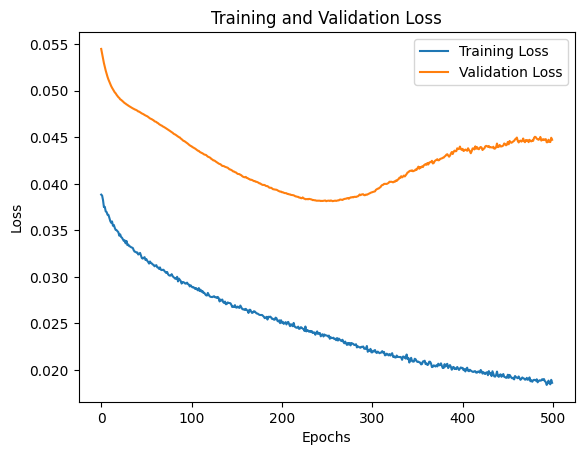

In [ ]:
train_losses, val_losses = train_TSMixer(model,train_data, val_data, optimizer,criterion, epochs=epochs, patience=5)

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

Test Loss (MSE): 9244713524.750
182010480.0


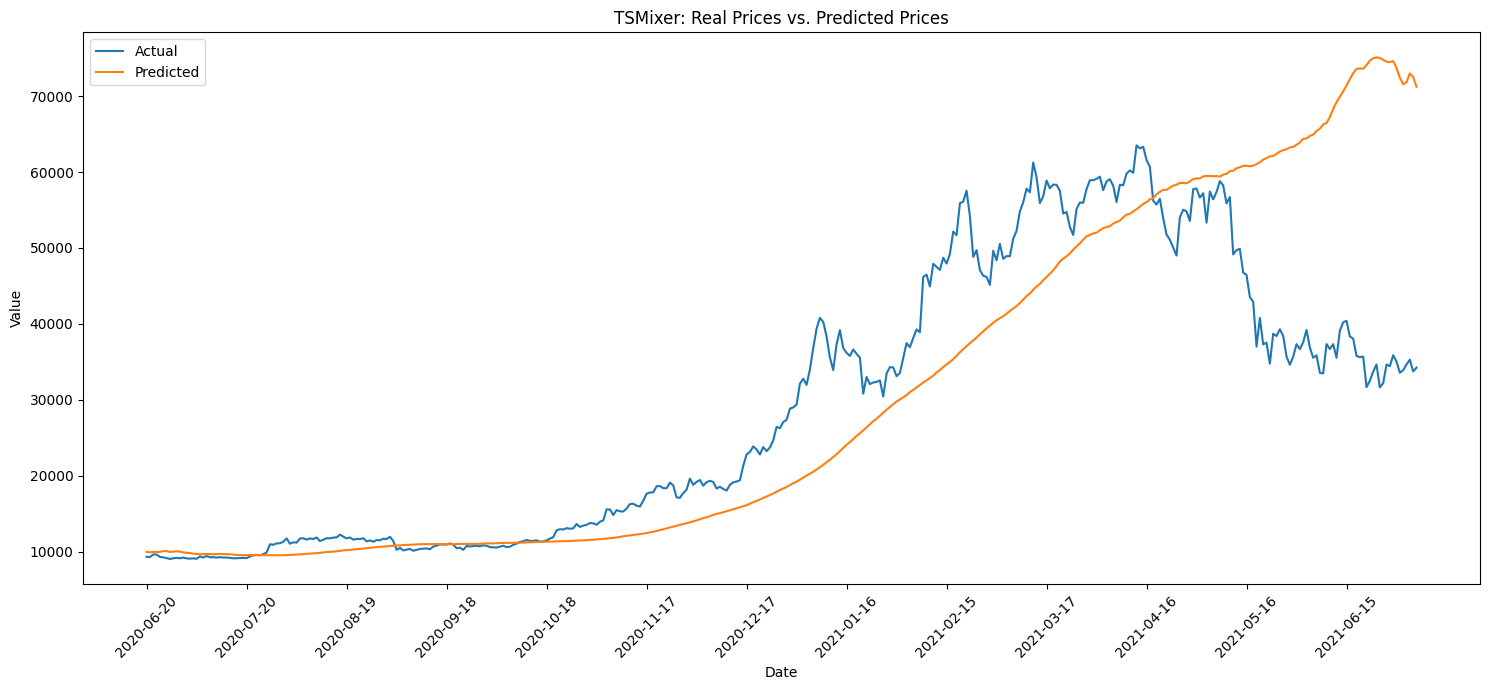

In [ ]:
import datetime

def plot_test_data_with_aggregation(model, test_loader):
    def unix_to_date(unix_timestamp):
        return datetime.datetime.fromtimestamp(unix_timestamp / 1e9).strftime('%Y-%m-%d')

    model.eval()
    aggregated_predictions = {}
    aggregated_actuals = {}
    target_feature_index = 0
    total_loss = 0
    criterion = nn.MSELoss()

    with torch.no_grad():
        for inputs, targets, dates_batch in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            for i in range(outputs.shape[0]):
                # (batch_size, sequence_length, num_features)
                predictions_full = outputs[i].cpu().numpy()  # (sequence_length, num_features)
                actuals_full = np.copy(predictions_full) 
                actuals_full[:, target_feature_index] = targets[i, :, 0].cpu().numpy() 

                # Inverse transform to original scale
                predictions_full_inv = data_loader.scaler.inverse_transform(predictions_full)
                actuals_full_inv = data_loader.scaler.inverse_transform(actuals_full)
                # Calculate loss in original scale
                loss = criterion(torch.tensor(predictions_full_inv[:, 0]), torch.tensor(actuals_full_inv[:, 0]))
                total_loss += loss.item()

                predictions_target = predictions_full_inv[:, target_feature_index]
                actuals_target = actuals_full_inv[:, target_feature_index]

                dates = dates_batch[i]

                for j, date in enumerate(dates):
                    date_str = unix_to_date(date.item()) 
                    if date_str not in aggregated_predictions:
                        aggregated_predictions[date_str] = []
                    if date_str not in aggregated_actuals:
                        aggregated_actuals[date_str] = []

                    aggregated_predictions[date_str].append(predictions_target[j])
                    aggregated_actuals[date_str].append(actuals_target[j])

    total_loss /= len(test_loader)
    print(f'Test Loss (MSE): {total_loss:.3f}')

    # averages of aggregated predictions and actuals (for overlapped output)
    avg_predictions = {date: np.mean(vals) for date, vals in aggregated_predictions.items()}
    avg_actuals = {date: np.mean(vals) for date, vals in aggregated_actuals.items()}

    print(nn.MSELoss()(torch.tensor(list(avg_predictions.values())), torch.tensor(list(avg_actuals.values()))).item())

    # Sort dates for plotting
    sorted_dates = sorted(aggregated_predictions.keys())
    sorted_avg_predictions = [avg_predictions[date] for date in sorted_dates]
    sorted_avg_actuals = [avg_actuals[date] for date in sorted_dates]

    # Plotting
    plt.figure(figsize=(15, 7))
    plt.plot(sorted_dates, sorted_avg_actuals, label='Actual')
    plt.plot(sorted_dates, sorted_avg_predictions, label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('TSMixer: Real Prices vs. Predicted Prices')
    plt.xticks(sorted_dates[::30], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_test_data_with_aggregation(model, test_data)


# Fine-tuning

In [ ]:
!pip install -U "ray[all]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 95.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from ray import tune
import torch
from ray import train

def train_tuning(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TSMixer(
        input_shape=(config["seq_len"], 6),
        pred_len=config["pred_len"],
        n_block=config["n_block"],
        dropout=config["dropout"],
        ff_dim=config["ff_dim"],
    ).to(device)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

    train_loader, val_loader, _ = get_loaders(config)

    train_loss, val_loss = train_TSMixer(model, train_loader, val_loader, optimizer, criterion, config["epochs"])

    for i, loss in enumerate(val_loss):
            train.report({"loss":loss}) 

    # tune.report(loss=min(val_loss))

def get_loaders(config):
    loader = Loader(
        filepath='/content/drive/MyDrive/Colab Notebooks/data/coin_Bitcoin.csv',
        batch_size=config["batch_size"],
        seq_len=config["seq_len"],
        pred_len=config["pred_len"],
        feature_cols=['Close', 'Open', 'High', 'Low', 'Volume', 'Marketcap'],
        target_col='Close'
    )
    return loader.get_loaders()

search_space = {
    "lr": tune.loguniform(1e-6, 1e-3),
    "batch_size": tune.choice([32, 64]),
    "seq_len": tune.choice([5,10,]),
    "pred_len": tune.choice([10,20,30]),
    "n_block": tune.choice([2, 4]),
    "dropout": tune.choice([0.1, 0.3, 0.5, 0.9]),
    "ff_dim": tune.choice([64, 128, 256]),
    "epochs": tune.choice([100, 500, 1000]),
}

# Start the tuning process
analysis = tune.run(
    train_tuning,
    resources_per_trial={"cpu": 1, "gpu": 1 if torch.cuda.is_available() else 0},
    config=search_space,
    num_samples=10,  # Number of trials to run
    metric="loss",  # Objective to optimize
    mode="min",  # Minimize the objective metric
    trial_dirname_creator = lambda trial: f"{trial.trainable_name}_{trial.trial_id[:8]}"
)


2024-04-13 11:57:38,104	INFO tune.py:622 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-04-13 11:57:38,255	INFO trial.py:183 -- Creating a new dirname train_tuning_06002_00_0293 because trial dirname 'train_tuning_06002_00' already exists.
2024-04-13 11:57:38,270	INFO trial.py:183 -- Creating a new dirname train_tuning_06002_00_a490 because trial dirname 'train_tuning_06002_00' already exists.
2024-04-13 11:57:38,282	INFO trial.py:183 -- Creating a new dirname train_tuning_06002_00_52e9 because trial dirname 'train_tuning_06002_00' already exists.
2024-04-13 11:57:38,296	INFO trial.py:183 -- Creating a new dirname train_tuning_06002_00_62da because trial dirname 'train_tuning_06002_00' already exists.
2024-04-13 11:57:38,310	INFO trial.py:183 -- Creating a new dirname train

+---------------------------------------------------------------------+
| Configuration for experiment     train_tuning_2024-04-13_11-57-38   |
+---------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator              |
| Scheduler                        FIFOScheduler                      |
| Number of trials                 10                                 |
+---------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_tuning_2024-04-13_11-57-38
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-04-13_11-53-36_456050_689/artifacts/2024-04-13_11-57-38/train_tuning_2024-04-13_11-57-38/driver_artifacts`


2024-04-13 11:57:38,353	INFO trial.py:183 -- Creating a new dirname train_tuning_06002_00_29fc because trial dirname 'train_tuning_06002_00' already exists.
2024-04-13 11:57:38,368	INFO trial.py:183 -- Creating a new dirname train_tuning_06002_00_a5ba because trial dirname 'train_tuning_06002_00' already exists.



Trial status: 10 PENDING
Current time: 2024-04-13 11:57:38. Total running time: 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status              lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs |
+-----------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00000   PENDING    0.000279503             64           5           30           2         0.5        128       1000 |
| train_tuning_06002_00001   PENDING    0.000833078             32          10           30           4         0.9        256        100 |
| train_tuning_06002_00002   PENDING    0.000668957             32          10           30           4         0.1        256        100 |

(train_tuning pid=3818) <ipython-input-5-d207aeb48842>:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  0%|          | 0/1000 [00:00<?, ?it/s]


(train_tuning pid=3818) Epoch 1, Train Loss: 0.0091, Val Loss: 0.0123


(train_tuning pid=3818) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(train_tuning pid=3818)   warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
  1%|          | 10/1000 [00:03<03:56,  4.18it/s]


(train_tuning pid=3818) Epoch 11, Train Loss: 0.0089, Val Loss: 0.0121


  2%|▏         | 20/1000 [00:05<03:45,  4.34it/s]


(train_tuning pid=3818) Epoch 21, Train Loss: 0.0088, Val Loss: 0.0120


  3%|▎         | 30/1000 [00:07<03:27,  4.68it/s]


(train_tuning pid=3818) Epoch 31, Train Loss: 0.0086, Val Loss: 0.0120


  4%|▍         | 40/1000 [00:10<03:32,  4.51it/s]


(train_tuning pid=3818) Epoch 41, Train Loss: 0.0086, Val Loss: 0.0119


  5%|▌         | 50/1000 [00:12<04:21,  3.63it/s]


(train_tuning pid=3818) Epoch 51, Train Loss: 0.0085, Val Loss: 0.0119


  6%|▌         | 60/1000 [00:15<05:10,  3.03it/s]


(train_tuning pid=3818) Epoch 61, Train Loss: 0.0084, Val Loss: 0.0118


  7%|▋         | 70/1000 [00:18<03:31,  4.40it/s]


(train_tuning pid=3818) Epoch 71, Train Loss: 0.0083, Val Loss: 0.0118


  8%|▊         | 80/1000 [00:20<03:22,  4.54it/s]


(train_tuning pid=3818) Epoch 81, Train Loss: 0.0083, Val Loss: 0.0118


  9%|▉         | 90/1000 [00:22<03:22,  4.50it/s]


(train_tuning pid=3818) Epoch 91, Train Loss: 0.0083, Val Loss: 0.0117


  9%|▉         | 94/1000 [00:23<03:17,  4.60it/s]



Trial status: 1 RUNNING | 9 PENDING
Current time: 2024-04-13 11:58:08. Total running time: 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status              lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs |
+-----------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00000   RUNNING    0.000279503             64           5           30           2         0.5        128       1000 |
| train_tuning_06002_00001   PENDING    0.000833078             32          10           30           4         0.9        256        100 |
| train_tuning_06002_00002   PENDING    0.000668957             32          10           30           4         0.1        256 

 10%|█         | 100/1000 [00:24<03:18,  4.53it/s]


(train_tuning pid=3818) Epoch 101, Train Loss: 0.0082, Val Loss: 0.0117


 11%|█         | 110/1000 [00:27<04:28,  3.31it/s]


(train_tuning pid=3818) Epoch 111, Train Loss: 0.0081, Val Loss: 0.0117


 12%|█▏        | 120/1000 [00:30<04:32,  3.23it/s]


(train_tuning pid=3818) Epoch 121, Train Loss: 0.0081, Val Loss: 0.0117


 13%|█▎        | 130/1000 [00:32<03:07,  4.64it/s]


(train_tuning pid=3818) Epoch 131, Train Loss: 0.0081, Val Loss: 0.0117


 14%|█▍        | 140/1000 [00:35<03:09,  4.54it/s]


(train_tuning pid=3818) Epoch 141, Train Loss: 0.0081, Val Loss: 0.0117


 15%|█▌        | 150/1000 [00:37<03:12,  4.41it/s]


(train_tuning pid=3818) Epoch 151, Train Loss: 0.0081, Val Loss: 0.0117


 16%|█▌        | 160/1000 [00:39<03:07,  4.47it/s]


(train_tuning pid=3818) Epoch 161, Train Loss: 0.0080, Val Loss: 0.0117


 17%|█▋        | 170/1000 [00:42<04:20,  3.18it/s]


(train_tuning pid=3818) Epoch 171, Train Loss: 0.0080, Val Loss: 0.0117


 18%|█▊        | 180/1000 [00:45<04:04,  3.36it/s]


(train_tuning pid=3818) Epoch 181, Train Loss: 0.0080, Val Loss: 0.0118


 19%|█▉        | 190/1000 [00:47<03:05,  4.38it/s]


(train_tuning pid=3818) Epoch 191, Train Loss: 0.0079, Val Loss: 0.0118


 20%|██        | 200/1000 [00:50<03:14,  4.12it/s]


(train_tuning pid=3818) Epoch 201, Train Loss: 0.0080, Val Loss: 0.0118


 21%|██        | 210/1000 [00:52<02:54,  4.52it/s]


(train_tuning pid=3818) Epoch 211, Train Loss: 0.0079, Val Loss: 0.0118


 22%|██▏       | 216/1000 [00:53<02:54,  4.49it/s]


Trial status: 1 RUNNING | 9 PENDING
Current time: 2024-04-13 11:58:38. Total running time: 1min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status              lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs |
+-----------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00000   RUNNING    0.000279503             64           5           30           2         0.5        128       1000 |
| train_tuning_06002_00001   PENDING    0.000833078             32          10           30           4         0.9        256        100 |
| train_tuning_06002_00002   PENDING    0.000668957             32          10           30           4         0.1        2

 22%|██▏       | 220/1000 [00:54<02:51,  4.56it/s]


(train_tuning pid=3818) Epoch 221, Train Loss: 0.0079, Val Loss: 0.0117


 23%|██▎       | 230/1000 [00:57<03:48,  3.37it/s]


(train_tuning pid=3818) Epoch 231, Train Loss: 0.0079, Val Loss: 0.0118


 24%|██▍       | 240/1000 [01:00<03:21,  3.76it/s]


(train_tuning pid=3818) Epoch 241, Train Loss: 0.0079, Val Loss: 0.0118


 25%|██▌       | 250/1000 [01:02<02:54,  4.31it/s]


(train_tuning pid=3818) Epoch 251, Train Loss: 0.0078, Val Loss: 0.0118


 26%|██▌       | 260/1000 [01:04<02:37,  4.70it/s]


(train_tuning pid=3818) Epoch 261, Train Loss: 0.0078, Val Loss: 0.0118


 27%|██▋       | 270/1000 [01:07<02:41,  4.51it/s]


(train_tuning pid=3818) Epoch 271, Train Loss: 0.0078, Val Loss: 0.0118


 28%|██▊       | 280/1000 [01:09<02:38,  4.55it/s]


(train_tuning pid=3818) Epoch 281, Train Loss: 0.0079, Val Loss: 0.0118


 29%|██▊       | 286/1000 [01:11<03:38,  3.27it/s]
 29%|██�
(train_tuning pid=3818) �       | 287/1000 [01:11<03:39,  3.24it/s]
 29%|██▉       | 290/1000 [01:12<03:29,  3.40it/s]


(train_tuning pid=3818) Epoch 291, Train Loss: 0.0080, Val Loss: 0.0118


 30%|███       | 300/1000 [01:15<02:49,  4.14it/s]


(train_tuning pid=3818) Epoch 301, Train Loss: 0.0078, Val Loss: 0.0118


 31%|███       | 310/1000 [01:17<02:30,  4.59it/s]


(train_tuning pid=3818) Epoch 311, Train Loss: 0.0077, Val Loss: 0.0119


 32%|███▏      | 320/1000 [01:19<02:26,  4.64it/s]


(train_tuning pid=3818) Epoch 321, Train Loss: 0.0078, Val Loss: 0.0119


 33%|███▎      | 330/1000 [01:21<02:27,  4.54it/s]


(train_tuning pid=3818) Epoch 331, Train Loss: 0.0077, Val Loss: 0.0119


 34%|███▎      | 336/1000 [01:23<03:39,  3.02it/s]


Trial status: 1 RUNNING | 9 PENDING
Current time: 2024-04-13 11:59:08. Total running time: 1min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status              lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs |
+-----------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00000   RUNNING    0.000279503             64           5           30           2         0.5        128       1000 |
| train_tuning_06002_00001   PENDING    0.000833078             32          10           30           4         0.9        256        100 |
| train_tuning_06002_00002   PENDING    0.000668957             32          10           30           4         0.1        

 34%|███▍      | 340/1000 [01:24<02:52,  3.82it/s]


(train_tuning pid=3818) Epoch 341, Train Loss: 0.0078, Val Loss: 0.0119


 35%|███▌      | 350/1000 [01:27<03:18,  3.27it/s]


(train_tuning pid=3818) Epoch 351, Train Loss: 0.0078, Val Loss: 0.0119


 36%|███▌      | 360/1000 [01:30<02:30,  4.25it/s]


(train_tuning pid=3818) Epoch 361, Train Loss: 0.0079, Val Loss: 0.0119


 37%|███▋      | 370/1000 [01:32<02:21,  4.47it/s]


(train_tuning pid=3818) Epoch 371, Train Loss: 0.0077, Val Loss: 0.0119


 38%|███▊      | 380/1000 [01:34<02:17,  4.51it/s]


(train_tuning pid=3818) Epoch 381, Train Loss: 0.0078, Val Loss: 0.0119


 39%|███▉      | 390/1000 [01:37<02:18,  4.42it/s]


(train_tuning pid=3818) Epoch 391, Train Loss: 0.0075, Val Loss: 0.0119


 40%|████      | 400/1000 [01:39<02:40,  3.74it/s]


(train_tuning pid=3818) Epoch 401, Train Loss: 0.0077, Val Loss: 0.0120


 41%|████      | 410/1000 [01:42<02:59,  3.29it/s]


(train_tuning pid=3818) Epoch 411, Train Loss: 0.0077, Val Loss: 0.0120


 42%|████▏     | 420/1000 [01:44<02:13,  4.36it/s]


(train_tuning pid=3818) Epoch 421, Train Loss: 0.0076, Val Loss: 0.0120


 43%|████▎     | 430/1000 [01:47<02:11,  4.35it/s]


(train_tuning pid=3818) Epoch 431, Train Loss: 0.0077, Val Loss: 0.0120


 44%|████▍     | 440/1000 [01:49<02:02,  4.59it/s]


(train_tuning pid=3818) Epoch 441, Train Loss: 0.0075, Val Loss: 0.0121


 45%|████▌     | 450/1000 [01:51<02:02,  4.50it/s]


(train_tuning pid=3818) Epoch 451, Train Loss: 0.0076, Val Loss: 0.0120


 46%|████▌     | 459/1000 [01:53<02:10,  4.15it/s]


Trial status: 1 RUNNING | 9 PENDING
Current time: 2024-04-13 11:59:38. Total running time: 2min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status              lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs |
+-----------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00000   RUNNING    0.000279503             64           5           30           2         0.5        128       1000 |
| train_tuning_06002_00001   PENDING    0.000833078             32          10           30           4         0.9        256        100 |
| train_tuning_06002_00002   PENDING    0.000668957             32          10           30           4         0.1        2

 46%|████▌     | 460/1000 [01:53<02:26,  3.69it/s]


(train_tuning pid=3818) Epoch 461, Train Loss: 0.0074, Val Loss: 0.0121


 47%|████▋     | 470/1000 [01:57<02:50,  3.11it/s]


(train_tuning pid=3818) Epoch 471, Train Loss: 0.0074, Val Loss: 0.0121


 48%|████▊     | 480/1000 [01:59<01:58,  4.38it/s]


(train_tuning pid=3818) Epoch 481, Train Loss: 0.0076, Val Loss: 0.0121


 49%|████▉     | 490/1000 [02:01<01:53,  4.49it/s]


(train_tuning pid=3818) Epoch 491, Train Loss: 0.0076, Val Loss: 0.0120


 50%|█████     | 500/1000 [02:04<01:50,  4.53it/s]


(train_tuning pid=3818) Epoch 501, Train Loss: 0.0074, Val Loss: 0.0121


 51%|█████     | 510/1000 [02:06<01:49,  4.48it/s]


(train_tuning pid=3818) Epoch 511, Train Loss: 0.0072, Val Loss: 0.0121


 52%|█████▏    | 520/1000 [02:09<02:11,  3.65it/s]


(train_tuning pid=3818) Epoch 521, Train Loss: 0.0074, Val Loss: 0.0121


 53%|█████▎    | 530/1000 [02:12<02:36,  3.01it/s]


(train_tuning pid=3818) Epoch 531, Train Loss: 0.0077, Val Loss: 0.0121


 54%|█████▍    | 540/1000 [02:14<01:42,  4.48it/s]


(train_tuning pid=3818) Epoch 541, Train Loss: 0.0074, Val Loss: 0.0121


 55%|█████▌    | 550/1000 [02:16<01:36,  4.67it/s]


(train_tuning pid=3818) Epoch 551, Train Loss: 0.0075, Val Loss: 0.0121


 56%|█████▌    | 560/1000 [02:19<01:38,  4.45it/s]


(train_tuning pid=3818) Epoch 561, Train Loss: 0.0078, Val Loss: 0.0121


 57%|█████▋    | 570/1000 [02:21<01:35,  4.50it/s]


(train_tuning pid=3818) Epoch 571, Train Loss: 0.0074, Val Loss: 0.0121


 58%|█████▊    | 579/1000 [02:23<02:08,  3.27it/s]


Trial status: 1 RUNNING | 9 PENDING
Current time: 2024-04-13 12:00:09. Total running time: 2min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status              lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs |
+-----------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00000   RUNNING    0.000279503             64           5           30           2         0.5        128       1000 |
| train_tuning_06002_00001   PENDING    0.000833078             32          10           30           4         0.9        256        100 |
| train_tuning_06002_00002   PENDING    0.000668957             32          10           30           4         0.1        

 58%|█████▊    | 580/1000 [02:24<02:12,  3.16it/s]


(train_tuning pid=3818) Epoch 581, Train Loss: 0.0075, Val Loss: 0.0121


 59%|█████▉    | 590/1000 [02:27<02:19,  2.93it/s]


(train_tuning pid=3818) Epoch 591, Train Loss: 0.0075, Val Loss: 0.0122


 60%|██████    | 600/1000 [02:29<01:32,  4.32it/s]


(train_tuning pid=3818) Epoch 601, Train Loss: 0.0075, Val Loss: 0.0123


 61%|██████    | 610/1000 [02:31<01:28,  4.39it/s]


(train_tuning pid=3818) Epoch 611, Train Loss: 0.0073, Val Loss: 0.0122


 62%|██████▏   | 620/1000 [02:34<01:29,  4.25it/s]


(train_tuning pid=3818) Epoch 621, Train Loss: 0.0074, Val Loss: 0.0122


 63%|██████▎   | 630/1000 [02:36<01:25,  4.34it/s]


(train_tuning pid=3818) Epoch 631, Train Loss: 0.0073, Val Loss: 0.0122


 64%|██████▍   | 640/1000 [02:39<01:47,  3.35it/s]


(train_tuning pid=3818) Epoch 641, Train Loss: 0.0075, Val Loss: 0.0122


 65%|██████▌   | 650/1000 [02:42<01:48,  3.23it/s]


(train_tuning pid=3818) Epoch 651, Train Loss: 0.0071, Val Loss: 0.0123


 66%|██████▌   | 660/1000 [02:44<01:17,  4.37it/s]


(train_tuning pid=3818) Epoch 661, Train Loss: 0.0071, Val Loss: 0.0123


 67%|██████▋   | 670/1000 [02:46<01:13,  4.50it/s]


(train_tuning pid=3818) Epoch 671, Train Loss: 0.0072, Val Loss: 0.0123


 68%|██████▊   | 680/1000 [02:48<01:09,  4.57it/s]


(train_tuning pid=3818) Epoch 681, Train Loss: 0.0073, Val Loss: 0.0123


 69%|██████▉   | 690/1000 [02:51<01:07,  4.63it/s]


(train_tuning pid=3818) Epoch 691, Train Loss: 0.0074, Val Loss: 0.0123


 70%|██████▉   | 699/1000 [02:53<01:31,  3.29it/s]



Trial train_tuning_06002_00000 finished iteration 1 at 2024-04-13 12:00:38. Total running time: 3min 0s
+---------------------------------------------------+
| Trial train_tuning_06002_00000 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          176.552 |
| time_total_s                              176.552 |
| training_iteration                              1 |
| loss                                      0.01233 |
+---------------------------------------------------+

Trial train_tuning_06002_00000 finished iteration 2 at 2024-04-13 12:00:38. Total running time: 3min 0s
+---------------------------------------------------+
| Trial train_tuning_06002_00000 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00048 |
| time_total_s                    

 70%|██████▉   | 699/1000 [02:53<01:14,  4.02it/s]


串流輸出內容已截斷至最後 5000 行。
+---------------------------------------------------+

Trial train_tuning_06002_00000 finished iteration 248 at 2024-04-13 12:00:40. Total running time: 3min 2s
+---------------------------------------------------+
| Trial train_tuning_06002_00000 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00015 |
| time_total_s                              176.638 |
| training_iteration                            248 |
| loss                                      0.01178 |
+---------------------------------------------------+

Trial train_tuning_06002_00000 finished iteration 249 at 2024-04-13 12:00:40. Total running time: 3min 2s
+---------------------------------------------------+
| Trial train_tuning_06002_00000 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_th

(train_tuning pid=4663) <ipython-input-5-d207aeb48842>:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  0%|          | 0/100 [00:00<?, ?it/s]


(train_tuning pid=4663) Epoch 1, Train Loss: 0.0143, Val Loss: 0.0139


(train_tuning pid=4663) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(train_tuning pid=4663)   warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
 10%|█         | 10/100 [00:08<01:11,  1.25it/s]


(train_tuning pid=4663) Epoch 11, Train Loss: 0.0101, Val Loss: 0.0132


 20%|██        | 20/100 [00:15<00:50,  1.57it/s]


(train_tuning pid=4663) Epoch 21, Train Loss: 0.0095, Val Loss: 0.0127


 25%|██▌       | 25/100 [00:19<00:58,  1.28it/s]



Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2024-04-13 12:01:09. Total running time: 3min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00000 with loss=0.012256395104082508 and params={'lr': 0.0002795025343119187, 'batch_size': 64, 'seq_len': 5, 'pred_len': 30, 'n_block': 2, 'dropout': 0.5, 'ff_dim': 128, 'epochs': 1000}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00001   RUNNING      0.0008

 30%|███       | 30/100 [00:23<00:52,  1.33it/s]


(train_tuning pid=4663) Epoch 31, Train Loss: 0.0091, Val Loss: 0.0124


 40%|████      | 40/100 [00:29<00:38,  1.56it/s]


(train_tuning pid=4663) Epoch 41, Train Loss: 0.0093, Val Loss: 0.0123


 50%|█████     | 50/100 [00:37<00:39,  1.28it/s]


(train_tuning pid=4663) Epoch 51, Train Loss: 0.0089, Val Loss: 0.0122


 60%|██████    | 60/100 [00:43<00:25,  1.55it/s]


(train_tuning pid=4663) Epoch 61, Train Loss: 0.0091, Val Loss: 0.0123


 67%|██████▋   | 67/100 [00:48<00:27,  1.20it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2024-04-13 12:01:39. Total running time: 4min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00000 with loss=0.012256395104082508 and params={'lr': 0.0002795025343119187, 'batch_size': 64, 'seq_len': 5, 'pred_len': 30, 'n_block': 2, 'dropout': 0.5, 'ff_dim': 128, 'epochs': 1000}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00001   RUNNING      0.000833

 70%|███████   | 70/100 [00:51<00:24,  1.23it/s]


(train_tuning pid=4663) Epoch 71, Train Loss: 0.0084, Val Loss: 0.0122


 80%|████████  | 80/100 [00:57<00:13,  1.54it/s]


(train_tuning pid=4663) Epoch 81, Train Loss: 0.0088, Val Loss: 0.0122


 90%|█████████ | 90/100 [01:05<00:08,  1.19it/s]


(train_tuning pid=4663) Epoch 91, Train Loss: 0.0090, Val Loss: 0.0122


 99%|█████████▉| 99/100 [01:11<00:00,  1.57it/s]



Trial train_tuning_06002_00001 finished iteration 1 at 2024-04-13 12:02:01. Total running time: 4min 23s
+---------------------------------------------------+
| Trial train_tuning_06002_00001 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          73.6186 |
| time_total_s                              73.6186 |
| training_iteration                              1 |
| loss                                      0.01387 |
+---------------------------------------------------+

Trial train_tuning_06002_00001 finished iteration 2 at 2024-04-13 12:02:01. Total running time: 4min 23s
+---------------------------------------------------+
| Trial train_tuning_06002_00001 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00022 |
| time_total_s                  

100%|██████████| 100/100 [01:11<00:00,  1.39it/s]



Trial train_tuning_06002_00001 finished iteration 48 at 2024-04-13 12:02:01. Total running time: 4min 23s
+---------------------------------------------------+
| Trial train_tuning_06002_00001 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00014 |
| time_total_s                              73.6269 |
| training_iteration                             48 |
| loss                                      0.01214 |
+---------------------------------------------------+

Trial train_tuning_06002_00001 finished iteration 49 at 2024-04-13 12:02:01. Total running time: 4min 23s
+---------------------------------------------------+
| Trial train_tuning_06002_00001 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00016 |
| time_total_s                

(train_tuning pid=5048) <ipython-input-5-d207aeb48842>:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  0%|          | 0/100 [00:00<?, ?it/s]


(train_tuning pid=5048) Epoch 1, Train Loss: 0.0101, Val Loss: 0.0134


(train_tuning pid=5048) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(train_tuning pid=5048)   warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
 10%|█         | 10/100 [00:06<00:57,  1.56it/s]


(train_tuning pid=5048) Epoch 11, Train Loss: 0.0093, Val Loss: 0.0129


 20%|██        | 20/100 [00:14<01:05,  1.22it/s]


(train_tuning pid=5048) Epoch 21, Train Loss: 0.0083, Val Loss: 0.0127


 30%|███       | 30/100 [00:20<00:44,  1.59it/s]


(train_tuning pid=5048) Epoch 31, Train Loss: 0.0074, Val Loss: 0.0134


 40%|████      | 40/100 [00:28<00:52,  1.15it/s]


(train_tuning pid=5048) Epoch 41, Train Loss: 0.0064, Val Loss: 0.0138


 41%|████      | 41/100 [00:29<00:47,  1.23it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2024-04-13 12:02:39. Total running time: 5min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00001 with loss=0.012187124559811005 and params={'lr': 0.0008330778916284566, 'batch_size': 32, 'seq_len': 10, 'pred_len': 30, 'n_block': 4, 'dropout': 0.9, 'ff_dim': 256, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00002   RUNNING      0.000668

 50%|█████     | 50/100 [00:34<00:32,  1.55it/s]


(train_tuning pid=5048) Epoch 51, Train Loss: 0.0055, Val Loss: 0.0149


 60%|██████    | 60/100 [00:42<00:35,  1.13it/s]


(train_tuning pid=5048) Epoch 61, Train Loss: 0.0054, Val Loss: 0.0143


 70%|███████   | 70/100 [00:48<00:18,  1.59it/s]


(train_tuning pid=5048) Epoch 71, Train Loss: 0.0058, Val Loss: 0.0137


 80%|████████  | 80/100 [00:56<00:16,  1.19it/s]


(train_tuning pid=5048) Epoch 81, Train Loss: 0.0044, Val Loss: 0.0138


 84%|████████▍ | 84/100 [00:59<00:11,  1.39it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2024-04-13 12:03:09. Total running time: 5min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00001 with loss=0.012187124559811005 and params={'lr': 0.0008330778916284566, 'batch_size': 32, 'seq_len': 10, 'pred_len': 30, 'n_block': 4, 'dropout': 0.9, 'ff_dim': 256, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00002   RUNNING      0.00066

 90%|█████████ | 90/100 [01:02<00:06,  1.56it/s]


(train_tuning pid=5048) Epoch 91, Train Loss: 0.0043, Val Loss: 0.0136


 99%|█████████▉| 99/100 [01:09<00:00,  1.26it/s]



Trial train_tuning_06002_00002 finished iteration 1 at 2024-04-13 12:03:19. Total running time: 5min 41s
+---------------------------------------------------+
| Trial train_tuning_06002_00002 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          72.4351 |
| time_total_s                              72.4351 |
| training_iteration                              1 |
| loss                                      0.01336 |
+---------------------------------------------------+

Trial train_tuning_06002_00002 finished iteration 2 at 2024-04-13 12:03:20. Total running time: 5min 41s
+---------------------------------------------------+
| Trial train_tuning_06002_00002 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00019 |
| time_total_s                  

100%|██████████| 100/100 [01:10<00:00,  1.43it/s]



Trial train_tuning_06002_00002 finished iteration 37 at 2024-04-13 12:03:20. Total running time: 5min 42s
+---------------------------------------------------+
| Trial train_tuning_06002_00002 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00018 |
| time_total_s                              72.4405 |
| training_iteration                             37 |
| loss                                       0.0139 |
+---------------------------------------------------+

Trial train_tuning_06002_00002 finished iteration 38 at 2024-04-13 12:03:20. Total running time: 5min 42s
+---------------------------------------------------+
| Trial train_tuning_06002_00002 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00017 |
| time_total_s                

(train_tuning pid=5428) <ipython-input-5-d207aeb48842>:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  0%|          | 0/500 [00:00<?, ?it/s]
(train_tuning pid=5428) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(train_tuning pid=5428)   warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
  0%|          | 1/500 [00:00<05:22,  1.54it/s]


(train_tuning pid=5428) Epoch 1, Train Loss: 0.0116, Val Loss: 0.0123


  2%|▏         | 11/500 [00:04<02:49,  2.88it/s]


(train_tuning pid=5428) Epoch 11, Train Loss: 0.0129, Val Loss: 0.0123


  4%|▍         | 21/500 [00:08<03:41,  2.16it/s]


(train_tuning pid=5428) Epoch 21, Train Loss: 0.0120, Val Loss: 0.0122


  6%|▌         | 30/500 [00:11<02:35,  3.02it/s]



Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2024-04-13 12:03:39. Total running time: 6min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00001 with loss=0.012187124559811005 and params={'lr': 0.0008330778916284566, 'batch_size': 32, 'seq_len': 10, 'pred_len': 30, 'n_block': 4, 'dropout': 0.9, 'ff_dim': 256, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00003   RUNNING      4.44007

  8%|▊         | 41/500 [00:15<02:30,  3.06it/s]


(train_tuning pid=5428) Epoch 41, Train Loss: 0.0114, Val Loss: 0.0122


 10%|█         | 51/500 [00:18<02:54,  2.58it/s]


(train_tuning pid=5428) Epoch 51, Train Loss: 0.0122, Val Loss: 0.0122


 12%|█▏        | 61/500 [00:23<03:05,  2.36it/s]


(train_tuning pid=5428) Epoch 61, Train Loss: 0.0108, Val Loss: 0.0122


 14%|█▍        | 71/500 [00:27<02:31,  2.83it/s]


(train_tuning pid=5428) Epoch 71, Train Loss: 0.0110, Val Loss: 0.0122


 16%|█▌        | 81/500 [00:30<02:22,  2.94it/s]


(train_tuning pid=5428) Epoch 81, Train Loss: 0.0120, Val Loss: 0.0122


 18%|█▊        | 91/500 [00:34<02:44,  2.49it/s]


(train_tuning pid=5428) Epoch 91, Train Loss: 0.0105, Val Loss: 0.0122


 20%|██        | 101/500 [00:38<02:40,  2.48it/s]


(train_tuning pid=5428) Epoch 101, Train Loss: 0.0110, Val Loss: 0.0122


 22%|██▏       | 111/500 [00:41<02:05,  3.09it/s]


(train_tuning pid=5428) Epoch 111, Train Loss: 0.0112, Val Loss: 0.0122
Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2024-04-13 12:04:09. Total running time: 6min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00001 with loss=0.012187124559811005 and params={'lr': 0.0008330778916284566, 'batch_size': 32, 'seq_len': 10, 'pred_len': 30, 'n_block': 4, 'dropout': 0.9, 'ff_dim': 256, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------

 24%|██▍       | 121/500 [00:45<02:06,  2.99it/s]


(train_tuning pid=5428) Epoch 121, Train Loss: 0.0112, Val Loss: 0.0122


 26%|██▌       | 131/500 [00:48<02:36,  2.36it/s]


(train_tuning pid=5428) Epoch 131, Train Loss: 0.0105, Val Loss: 0.0121


 28%|██▊       | 141/500 [00:53<02:23,  2.51it/s]


(train_tuning pid=5428) Epoch 141, Train Loss: 0.0105, Val Loss: 0.0121


 30%|███       | 151/500 [00:56<01:54,  3.06it/s]


(train_tuning pid=5428) Epoch 151, Train Loss: 0.0103, Val Loss: 0.0121


 32%|███▏      | 161/500 [01:00<01:51,  3.04it/s]


(train_tuning pid=5428) Epoch 161, Train Loss: 0.0101, Val Loss: 0.0121


 34%|███▍      | 171/500 [01:04<02:25,  2.26it/s]


(train_tuning pid=5428) Epoch 171, Train Loss: 0.0104, Val Loss: 0.0121


 36%|███▌      | 181/500 [01:08<01:54,  2.80it/s]


(train_tuning pid=5428) Epoch 181, Train Loss: 0.0108, Val Loss: 0.0121


 38%|███▊      | 191/500 [01:11<01:42,  3.00it/s]


(train_tuning pid=5428) Epoch 191, Train Loss: 0.0100, Val Loss: 0.0121


 38%|███▊      | 192/500 [01:11<01:43,  2.98it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2024-04-13 12:04:39. Total running time: 7min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00001 with loss=0.012187124559811005 and params={'lr': 0.0008330778916284566, 'batch_size': 32, 'seq_len': 10, 'pred_len': 30, 'n_block': 4, 'dropout': 0.9, 'ff_dim': 256, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00003   RUNNING      4.44007e

 40%|████      | 201/500 [01:14<01:37,  3.07it/s]


(train_tuning pid=5428) Epoch 201, Train Loss: 0.0109, Val Loss: 0.0121


 42%|████▏     | 211/500 [01:18<02:12,  2.18it/s]


(train_tuning pid=5428) Epoch 211, Train Loss: 0.0104, Val Loss: 0.0121


 44%|████▍     | 221/500 [01:22<01:40,  2.79it/s]


(train_tuning pid=5428) Epoch 221, Train Loss: 0.0105, Val Loss: 0.0121


 46%|████▌     | 231/500 [01:26<01:31,  2.92it/s]


(train_tuning pid=5428) Epoch 231, Train Loss: 0.0101, Val Loss: 0.0121


 48%|████▊     | 241/500 [01:29<01:27,  2.95it/s]


(train_tuning pid=5428) Epoch 241, Train Loss: 0.0100, Val Loss: 0.0121


 50%|█████     | 251/500 [01:33<01:50,  2.25it/s]


(train_tuning pid=5428) Epoch 251, Train Loss: 0.0102, Val Loss: 0.0121


 52%|█████▏    | 261/500 [01:37<01:25,  2.78it/s]


(train_tuning pid=5428) Epoch 261, Train Loss: 0.0102, Val Loss: 0.0121


 54%|█████▍    | 271/500 [01:41<01:16,  2.99it/s]


(train_tuning pid=5428) Epoch 271, Train Loss: 0.0098, Val Loss: 0.0121


 55%|█████▍    | 273/500 [01:41<01:14,  3.05it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2024-04-13 12:05:09. Total running time: 7min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00001 with loss=0.012187124559811005 and params={'lr': 0.0008330778916284566, 'batch_size': 32, 'seq_len': 10, 'pred_len': 30, 'n_block': 4, 'dropout': 0.9, 'ff_dim': 256, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00003   RUNNING      4.44007

 56%|█████▌    | 281/500 [01:44<01:13,  2.99it/s]


(train_tuning pid=5428) Epoch 281, Train Loss: 0.0099, Val Loss: 0.0121


 58%|█████▊    | 291/500 [01:48<01:32,  2.25it/s]


(train_tuning pid=5428) Epoch 291, Train Loss: 0.0094, Val Loss: 0.0121


 60%|██████    | 301/500 [01:52<01:09,  2.84it/s]


(train_tuning pid=5428) Epoch 301, Train Loss: 0.0098, Val Loss: 0.0121


 62%|██████▏   | 311/500 [01:56<01:03,  2.98it/s]


(train_tuning pid=5428) Epoch 311, Train Loss: 0.0096, Val Loss: 0.0121


 64%|██████▍   | 321/500 [01:59<00:57,  3.11it/s]


(train_tuning pid=5428) Epoch 321, Train Loss: 0.0094, Val Loss: 0.0121


 66%|██████▌   | 331/500 [02:03<01:16,  2.21it/s]


(train_tuning pid=5428) Epoch 331, Train Loss: 0.0094, Val Loss: 0.0121


 68%|██████▊   | 341/500 [02:07<00:55,  2.86it/s]


(train_tuning pid=5428) Epoch 341, Train Loss: 0.0095, Val Loss: 0.0121


 70%|███████   | 351/500 [02:10<00:48,  3.07it/s]


(train_tuning pid=5428) Epoch 351, Train Loss: 0.0094, Val Loss: 0.0121


 71%|███████   | 355/500 [02:12<00:49,  2.95it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2024-04-13 12:05:39. Total running time: 8min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00001 with loss=0.012187124559811005 and params={'lr': 0.0008330778916284566, 'batch_size': 32, 'seq_len': 10, 'pred_len': 30, 'n_block': 4, 'dropout': 0.9, 'ff_dim': 256, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00003   RUNNING      4.44007e

 72%|███████▏  | 361/500 [02:14<00:46,  3.01it/s]


(train_tuning pid=5428) Epoch 361, Train Loss: 0.0092, Val Loss: 0.0121


 74%|███████▍  | 371/500 [02:18<00:57,  2.23it/s]


(train_tuning pid=5428) Epoch 371, Train Loss: 0.0093, Val Loss: 0.0120


 76%|███████▌  | 381/500 [02:22<00:41,  2.86it/s]


(train_tuning pid=5428) Epoch 381, Train Loss: 0.0093, Val Loss: 0.0120


 78%|███████▊  | 391/500 [02:25<00:35,  3.03it/s]


(train_tuning pid=5428) Epoch 391, Train Loss: 0.0093, Val Loss: 0.0120


 80%|████████  | 401/500 [02:28<00:32,  3.02it/s]


(train_tuning pid=5428) Epoch 401, Train Loss: 0.0092, Val Loss: 0.0120


 82%|████████▏ | 411/500 [02:33<00:42,  2.11it/s]


(train_tuning pid=5428) Epoch 411, Train Loss: 0.0092, Val Loss: 0.0120


 84%|████████▍ | 421/500 [02:37<00:26,  2.93it/s]


(train_tuning pid=5428) Epoch 421, Train Loss: 0.0093, Val Loss: 0.0120


 86%|████████▌ | 431/500 [02:40<00:22,  3.13it/s]


(train_tuning pid=5428) Epoch 431, Train Loss: 0.0090, Val Loss: 0.0120


 87%|████████▋ | 437/500 [02:42<00:21,  2.95it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2024-04-13 12:06:09. Total running time: 8min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00001 with loss=0.012187124559811005 and params={'lr': 0.0008330778916284566, 'batch_size': 32, 'seq_len': 10, 'pred_len': 30, 'n_block': 4, 'dropout': 0.9, 'ff_dim': 256, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00003   RUNNING      4.44007

 88%|████████▊ | 441/500 [02:43<00:20,  2.87it/s]


(train_tuning pid=5428) Epoch 441, Train Loss: 0.0091, Val Loss: 0.0120


 90%|█████████ | 451/500 [02:48<00:24,  2.04it/s]


(train_tuning pid=5428) Epoch 451, Train Loss: 0.0093, Val Loss: 0.0120


 92%|█████████▏| 461/500 [02:51<00:13,  2.96it/s]


(train_tuning pid=5428) Epoch 461, Train Loss: 0.0090, Val Loss: 0.0120


 94%|█████████▍| 471/500 [02:55<00:09,  2.98it/s]


(train_tuning pid=5428) Epoch 471, Train Loss: 0.0090, Val Loss: 0.0120


 96%|█████████▌| 481/500 [02:58<00:06,  3.00it/s]


(train_tuning pid=5428) Epoch 481, Train Loss: 0.0089, Val Loss: 0.0120


 98%|█████████▊| 491/500 [03:03<00:04,  1.96it/s]


(train_tuning pid=5428) Epoch 491, Train Loss: 0.0090, Val Loss: 0.0120


100%|█████████▉| 499/500 [03:06<00:00,  2.90it/s]



Trial train_tuning_06002_00003 finished iteration 1 at 2024-04-13 12:06:33. Total running time: 8min 55s
+---------------------------------------------------+
| Trial train_tuning_06002_00003 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          188.042 |
| time_total_s                              188.042 |
| training_iteration                              1 |
| loss                                      0.01227 |
+---------------------------------------------------+

Trial train_tuning_06002_00003 finished iteration 2 at 2024-04-13 12:06:33. Total running time: 8min 55s
+---------------------------------------------------+
| Trial train_tuning_06002_00003 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00023 |
| time_total_s                  

100%|██████████| 500/500 [03:06<00:00,  2.68it/s]


串流輸出內容已截斷至最後 5000 行。
| time_total_s                               188.05 |
| training_iteration                             49 |
| loss                                       0.0122 |
+---------------------------------------------------+

Trial train_tuning_06002_00003 finished iteration 50 at 2024-04-13 12:06:33. Total running time: 8min 55s
+---------------------------------------------------+
| Trial train_tuning_06002_00003 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00013 |
| time_total_s                               188.05 |
| training_iteration                             50 |
| loss                                      0.01221 |
+---------------------------------------------------+

Trial train_tuning_06002_00003 finished iteration 51 at 2024-04-13 12:06:33. Total running time: 8min 55s
+---------------------------------------------------+
| Trial t

(train_tuning pid=6315) <ipython-input-5-d207aeb48842>:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  0%|          | 0/1000 [00:00<?, ?it/s]
(train_tuning pid=6315) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(train_tuning pid=6315)   warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
  0%|          | 1/1000 [00:01<19:54,  1.20s/it]


(train_tuning pid=6315) Epoch 1, Train Loss: 0.0142, Val Loss: 0.0137


  1%|          | 11/1000 [00:05<07:08,  2.31it/s]


(train_tuning pid=6315) Epoch 11, Train Loss: 0.0145, Val Loss: 0.0137


  2%|▏         | 21/1000 [00:09<06:41,  2.44it/s]


(train_tuning pid=6315) Epoch 21, Train Loss: 0.0144, Val Loss: 0.0137


  3%|▎         | 31/1000 [00:14<08:35,  1.88it/s]


(train_tuning pid=6315) Epoch 31, Train Loss: 0.0140, Val Loss: 0.0137


  4%|▍         | 41/1000 [00:19<06:57,  2.29it/s]


(train_tuning pid=6315) Epoch 41, Train Loss: 0.0137, Val Loss: 0.0137


  5%|▌         | 51/1000 [00:23<06:34,  2.41it/s]


(train_tuning pid=6315) Epoch 51, Train Loss: 0.0135, Val Loss: 0.0137


  6%|▌         | 58/1000 [00:26<06:31,  2.40it/s]



Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-04-13 12:07:09. Total running time: 9min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00003 with loss=0.012002768337778334 and params={'lr': 4.440072737111293e-05, 'batch_size': 64, 'seq_len': 5, 'pred_len': 30, 'n_block': 4, 'dropout': 0.9, 'ff_dim': 64, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00004   RUNNING      3.12162e

  6%|▌         | 61/1000 [00:28<07:54,  1.98it/s]


(train_tuning pid=6315) Epoch 61, Train Loss: 0.0143, Val Loss: 0.0137


  7%|▋         | 71/1000 [00:33<06:56,  2.23it/s]


(train_tuning pid=6315) Epoch 71, Train Loss: 0.0133, Val Loss: 0.0137


  8%|▊         | 81/1000 [00:37<06:26,  2.38it/s]


(train_tuning pid=6315) Epoch 81, Train Loss: 0.0157, Val Loss: 0.0137


  9%|▉         | 91/1000 [00:41<07:11,  2.10it/s]


(train_tuning pid=6315) Epoch 91, Train Loss: 0.0142, Val Loss: 0.0137


 10%|█         | 101/1000 [00:47<07:22,  2.03it/s]


(train_tuning pid=6315) Epoch 101, Train Loss: 0.0142, Val Loss: 0.0137


 11%|█         | 111/1000 [00:51<06:08,  2.41it/s]


(train_tuning pid=6315) Epoch 111, Train Loss: 0.0137, Val Loss: 0.0137


 12%|█▏        | 121/1000 [00:55<06:01,  2.43it/s]


(train_tuning pid=6315) Epoch 121, Train Loss: 0.0158, Val Loss: 0.0137


 12%|█▏        | 123/1000 [00:56<06:49,  2.14it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-04-13 12:07:39. Total running time: 10min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00003 with loss=0.012002768337778334 and params={'lr': 4.440072737111293e-05, 'batch_size': 64, 'seq_len': 5, 'pred_len': 30, 'n_block': 4, 'dropout': 0.9, 'ff_dim': 64, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00004   RUNNING      3.12162e-

 13%|█▎        | 131/1000 [01:01<07:31,  1.92it/s]


(train_tuning pid=6315) Epoch 131, Train Loss: 0.0132, Val Loss: 0.0137


 14%|█▍        | 141/1000 [01:05<06:02,  2.37it/s]


(train_tuning pid=6315) Epoch 141, Train Loss: 0.0129, Val Loss: 0.0137


 15%|█▌        | 151/1000 [01:09<05:49,  2.43it/s]


(train_tuning pid=6315) Epoch 151, Train Loss: 0.0142, Val Loss: 0.0137


 16%|█▌        | 161/1000 [01:14<08:05,  1.73it/s]


(train_tuning pid=6315) Epoch 161, Train Loss: 0.0141, Val Loss: 0.0137


 17%|█▋        | 171/1000 [01:18<05:52,  2.35it/s]


(train_tuning pid=6315) Epoch 171, Train Loss: 0.0129, Val Loss: 0.0137


 18%|█▊        | 181/1000 [01:22<05:28,  2.50it/s]


(train_tuning pid=6315) Epoch 181, Train Loss: 0.0133, Val Loss: 0.0137


 19%|█▉        | 188/1000 [01:26<07:15,  1.86it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-04-13 12:08:10. Total running time: 10min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00003 with loss=0.012002768337778334 and params={'lr': 4.440072737111293e-05, 'batch_size': 64, 'seq_len': 5, 'pred_len': 30, 'n_block': 4, 'dropout': 0.9, 'ff_dim': 64, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00004   RUNNING      3.12162e

 19%|█▉        | 191/1000 [01:28<07:19,  1.84it/s]


(train_tuning pid=6315) Epoch 191, Train Loss: 0.0135, Val Loss: 0.0137


 20%|██        | 201/1000 [01:32<05:39,  2.35it/s]


(train_tuning pid=6315) Epoch 201, Train Loss: 0.0142, Val Loss: 0.0137


 21%|██        | 211/1000 [01:36<05:23,  2.44it/s]


(train_tuning pid=6315) Epoch 211, Train Loss: 0.0136, Val Loss: 0.0137


 22%|██▏       | 221/1000 [01:41<07:01,  1.85it/s]


(train_tuning pid=6315) Epoch 221, Train Loss: 0.0132, Val Loss: 0.0137


 23%|██▎       | 231/1000 [01:46<05:31,  2.32it/s]


(train_tuning pid=6315) Epoch 231, Train Loss: 0.0143, Val Loss: 0.0137


 24%|██▍       | 241/1000 [01:50<05:11,  2.44it/s]


(train_tuning pid=6315) Epoch 241, Train Loss: 0.0138, Val Loss: 0.0137


 25%|██▌       | 251/1000 [01:55<06:33,  1.90it/s]


(train_tuning pid=6315) Epoch 251, Train Loss: 0.0136, Val Loss: 0.0137


 25%|██▌       | 253/1000 [01:56<06:39,  1.87it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-04-13 12:08:40. Total running time: 11min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00003 with loss=0.012002768337778334 and params={'lr': 4.440072737111293e-05, 'batch_size': 64, 'seq_len': 5, 'pred_len': 30, 'n_block': 4, 'dropout': 0.9, 'ff_dim': 64, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00004   RUNNING      3.12162e-

 26%|██▌       | 261/1000 [02:00<05:38,  2.18it/s]


(train_tuning pid=6315) Epoch 261, Train Loss: 0.0128, Val Loss: 0.0137


 27%|██▋       | 271/1000 [02:04<05:07,  2.37it/s]


(train_tuning pid=6315) Epoch 271, Train Loss: 0.0131, Val Loss: 0.0137


 28%|██▊       | 281/1000 [02:09<05:45,  2.08it/s]


(train_tuning pid=6315) Epoch 281, Train Loss: 0.0130, Val Loss: 0.0137


 29%|██▉       | 291/1000 [02:14<05:24,  2.18it/s]


(train_tuning pid=6315) Epoch 291, Train Loss: 0.0139, Val Loss: 0.0137


 30%|███       | 301/1000 [02:18<04:56,  2.36it/s]


(train_tuning pid=6315) Epoch 301, Train Loss: 0.0134, Val Loss: 0.0137


 31%|███       | 311/1000 [02:23<04:51,  2.36it/s]


(train_tuning pid=6315) Epoch 311, Train Loss: 0.0130, Val Loss: 0.0137


 32%|███▏      | 317/1000 [02:26<06:28,  1.76it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-04-13 12:09:10. Total running time: 11min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00003 with loss=0.012002768337778334 and params={'lr': 4.440072737111293e-05, 'batch_size': 64, 'seq_len': 5, 'pred_len': 30, 'n_block': 4, 'dropout': 0.9, 'ff_dim': 64, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00004   RUNNING      3.12162e

 32%|███▏      | 321/1000 [02:28<05:39,  2.00it/s]


(train_tuning pid=6315) Epoch 321, Train Loss: 0.0133, Val Loss: 0.0137


 33%|███▎      | 331/1000 [02:32<04:33,  2.44it/s]


(train_tuning pid=6315) Epoch 331, Train Loss: 0.0135, Val Loss: 0.0137


 34%|███▍      | 341/1000 [02:36<04:31,  2.42it/s]


(train_tuning pid=6315) Epoch 341, Train Loss: 0.0133, Val Loss: 0.0137


 35%|███▌      | 351/1000 [02:42<06:01,  1.80it/s]


(train_tuning pid=6315) Epoch 351, Train Loss: 0.0127, Val Loss: 0.0137


 36%|███▌      | 361/1000 [02:46<04:31,  2.35it/s]


(train_tuning pid=6315) Epoch 361, Train Loss: 0.0142, Val Loss: 0.0136


 37%|███▋      | 371/1000 [02:50<04:18,  2.43it/s]


(train_tuning pid=6315) Epoch 371, Train Loss: 0.0126, Val Loss: 0.0136


 38%|███▊      | 381/1000 [02:56<06:05,  1.69it/s]


(train_tuning pid=6315) Epoch 381, Train Loss: 0.0122, Val Loss: 0.0136


 38%|███▊      | 382/1000 [02:56<05:59,  1.72it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-04-13 12:09:40. Total running time: 12min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00003 with loss=0.012002768337778334 and params={'lr': 4.440072737111293e-05, 'batch_size': 64, 'seq_len': 5, 'pred_len': 30, 'n_block': 4, 'dropout': 0.9, 'ff_dim': 64, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00004   RUNNING      3.12162e-

 39%|███▉      | 391/1000 [03:00<04:15,  2.38it/s]


(train_tuning pid=6315) Epoch 391, Train Loss: 0.0131, Val Loss: 0.0136


 40%|████      | 401/1000 [03:04<04:20,  2.30it/s]


(train_tuning pid=6315) Epoch 401, Train Loss: 0.0126, Val Loss: 0.0136


 41%|████      | 411/1000 [03:09<05:15,  1.87it/s]


(train_tuning pid=6315) Epoch 411, Train Loss: 0.0124, Val Loss: 0.0136


 42%|████▏     | 421/1000 [03:14<04:07,  2.34it/s]


(train_tuning pid=6315) Epoch 421, Train Loss: 0.0130, Val Loss: 0.0136


 43%|████▎     | 431/1000 [03:18<03:54,  2.42it/s]


(train_tuning pid=6315) Epoch 431, Train Loss: 0.0129, Val Loss: 0.0136


 44%|████▍     | 441/1000 [03:23<05:07,  1.82it/s]


(train_tuning pid=6315) Epoch 441, Train Loss: 0.0130, Val Loss: 0.0136


 45%|████▍     | 448/1000 [03:27<04:12,  2.19it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-04-13 12:10:10. Total running time: 12min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00003 with loss=0.012002768337778334 and params={'lr': 4.440072737111293e-05, 'batch_size': 64, 'seq_len': 5, 'pred_len': 30, 'n_block': 4, 'dropout': 0.9, 'ff_dim': 64, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00004   RUNNING      3.12162e

 45%|████▌     | 451/1000 [03:28<04:04,  2.25it/s]


(train_tuning pid=6315) Epoch 451, Train Loss: 0.0132, Val Loss: 0.0136


 46%|████▌     | 461/1000 [03:32<03:42,  2.42it/s]


(train_tuning pid=6315) Epoch 461, Train Loss: 0.0134, Val Loss: 0.0136


 47%|████▋     | 471/1000 [03:37<04:37,  1.91it/s]


(train_tuning pid=6315) Epoch 471, Train Loss: 0.0128, Val Loss: 0.0136


 48%|████▊     | 481/1000 [03:42<03:47,  2.28it/s]


(train_tuning pid=6315) Epoch 481, Train Loss: 0.0135, Val Loss: 0.0136


 49%|████▉     | 491/1000 [03:46<03:28,  2.44it/s]


(train_tuning pid=6315) Epoch 491, Train Loss: 0.0128, Val Loss: 0.0136


 50%|█████     | 501/1000 [03:50<03:49,  2.17it/s]


(train_tuning pid=6315) Epoch 501, Train Loss: 0.0130, Val Loss: 0.0136


 51%|█████     | 511/1000 [03:55<03:53,  2.09it/s]


(train_tuning pid=6315) Epoch 511, Train Loss: 0.0123, Val Loss: 0.0136


 51%|█████▏    | 513/1000 [03:56<03:35,  2.26it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-04-13 12:10:40. Total running time: 13min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00003 with loss=0.012002768337778334 and params={'lr': 4.440072737111293e-05, 'batch_size': 64, 'seq_len': 5, 'pred_len': 30, 'n_block': 4, 'dropout': 0.9, 'ff_dim': 64, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00004   RUNNING      3.12162e-

 52%|█████▏    | 521/1000 [04:00<03:32,  2.25it/s]


(train_tuning pid=6315) Epoch 521, Train Loss: 0.0120, Val Loss: 0.0136


 53%|█████▎    | 531/1000 [04:04<03:47,  2.06it/s]


(train_tuning pid=6315) Epoch 531, Train Loss: 0.0133, Val Loss: 0.0136


 54%|█████▍    | 541/1000 [04:10<03:58,  1.92it/s]


(train_tuning pid=6315) Epoch 541, Train Loss: 0.0126, Val Loss: 0.0136


 55%|█████▌    | 551/1000 [04:15<03:23,  2.20it/s]


(train_tuning pid=6315) Epoch 551, Train Loss: 0.0126, Val Loss: 0.0136


 56%|█████▌    | 561/1000 [04:19<03:27,  2.12it/s]


(train_tuning pid=6315) Epoch 561, Train Loss: 0.0129, Val Loss: 0.0136


 57%|█████▋    | 571/1000 [04:25<03:41,  1.94it/s]


(train_tuning pid=6315) Epoch 571, Train Loss: 0.0121, Val Loss: 0.0136


 57%|█████▋    | 574/1000 [04:26<03:10,  2.24it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-04-13 12:11:10. Total running time: 13min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00003 with loss=0.012002768337778334 and params={'lr': 4.440072737111293e-05, 'batch_size': 64, 'seq_len': 5, 'pred_len': 30, 'n_block': 4, 'dropout': 0.9, 'ff_dim': 64, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00004   RUNNING      3.12162e

 58%|█████▊    | 580/1000 [04:29<02:58,  2.35it/s]


(train_tuning pid=6315) Epoch 581, Train Loss: 0.0153, Val Loss: 0.0136


 59%|█████▉    | 591/1000 [04:34<02:55,  2.33it/s]


(train_tuning pid=6315) Epoch 591, Train Loss: 0.0129, Val Loss: 0.0136


 60%|██████    | 601/1000 [04:39<03:23,  1.96it/s]


(train_tuning pid=6315) Epoch 601, Train Loss: 0.0127, Val Loss: 0.0136


 61%|██████    | 611/1000 [04:43<02:45,  2.35it/s]


(train_tuning pid=6315) Epoch 611, Train Loss: 0.0127, Val Loss: 0.0136


 62%|██████▏   | 621/1000 [04:47<02:34,  2.45it/s]


(train_tuning pid=6315) Epoch 621, Train Loss: 0.0121, Val Loss: 0.0136


 63%|██████▎   | 631/1000 [04:53<03:39,  1.68it/s]


(train_tuning pid=6315) Epoch 631, Train Loss: 0.0115, Val Loss: 0.0136


 64%|██████▍   | 639/1000 [04:56<02:39,  2.26it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-04-13 12:11:40. Total running time: 14min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00003 with loss=0.012002768337778334 and params={'lr': 4.440072737111293e-05, 'batch_size': 64, 'seq_len': 5, 'pred_len': 30, 'n_block': 4, 'dropout': 0.9, 'ff_dim': 64, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00004   RUNNING      3.12162e-

 64%|██████▍   | 641/1000 [04:57<02:34,  2.33it/s]


(train_tuning pid=6315) Epoch 641, Train Loss: 0.0118, Val Loss: 0.0136


 65%|██████▌   | 651/1000 [05:01<02:22,  2.45it/s]


(train_tuning pid=6315) Epoch 651, Train Loss: 0.0121, Val Loss: 0.0136


 66%|██████▌   | 661/1000 [05:07<03:14,  1.75it/s]


(train_tuning pid=6315) Epoch 661, Train Loss: 0.0130, Val Loss: 0.0136


 67%|██████▋   | 671/1000 [05:11<02:21,  2.33it/s]


(train_tuning pid=6315) Epoch 671, Train Loss: 0.0120, Val Loss: 0.0136


 68%|██████▊   | 681/1000 [05:15<02:12,  2.42it/s]


(train_tuning pid=6315) Epoch 681, Train Loss: 0.0123, Val Loss: 0.0136


 69%|██████▉   | 691/1000 [05:20<02:52,  1.79it/s]


(train_tuning pid=6315) Epoch 691, Train Loss: 0.0124, Val Loss: 0.0136


 70%|███████   | 701/1000 [05:25<02:08,  2.32it/s]


(train_tuning pid=6315) Epoch 701, Train Loss: 0.0120, Val Loss: 0.0136


 70%|███████   | 705/1000 [05:27<02:02,  2.40it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-04-13 12:12:10. Total running time: 14min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00003 with loss=0.012002768337778334 and params={'lr': 4.440072737111293e-05, 'batch_size': 64, 'seq_len': 5, 'pred_len': 30, 'n_block': 4, 'dropout': 0.9, 'ff_dim': 64, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00004   RUNNING      3.12162e

 71%|███████   | 711/1000 [05:29<01:59,  2.42it/s]


(train_tuning pid=6315) Epoch 711, Train Loss: 0.0123, Val Loss: 0.0136


 72%|███████▏  | 721/1000 [05:34<02:27,  1.89it/s]


(train_tuning pid=6315) Epoch 721, Train Loss: 0.0115, Val Loss: 0.0136


 73%|███████▎  | 731/1000 [05:39<01:58,  2.28it/s]


(train_tuning pid=6315) Epoch 731, Train Loss: 0.0122, Val Loss: 0.0136


 74%|███████▍  | 741/1000 [05:43<01:47,  2.41it/s]


(train_tuning pid=6315) Epoch 741, Train Loss: 0.0121, Val Loss: 0.0136


 75%|███████▌  | 751/1000 [05:47<02:00,  2.06it/s]


(train_tuning pid=6315) Epoch 751, Train Loss: 0.0116, Val Loss: 0.0135


 76%|███████▌  | 761/1000 [05:53<01:49,  2.18it/s]


(train_tuning pid=6315) Epoch 761, Train Loss: 0.0125, Val Loss: 0.0135


 77%|███████▋  | 770/1000 [05:57<01:37,  2.36it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-04-13 12:12:40. Total running time: 15min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00003 with loss=0.012002768337778334 and params={'lr': 4.440072737111293e-05, 'batch_size': 64, 'seq_len': 5, 'pred_len': 30, 'n_block': 4, 'dropout': 0.9, 'ff_dim': 64, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00004   RUNNING      3.12162e-

 78%|███████▊  | 781/1000 [06:01<01:28,  2.46it/s]


(train_tuning pid=6315) Epoch 781, Train Loss: 0.0120, Val Loss: 0.0135


 79%|███████▉  | 791/1000 [06:07<01:48,  1.93it/s]


(train_tuning pid=6315) Epoch 791, Train Loss: 0.0122, Val Loss: 0.0135


 80%|████████  | 801/1000 [06:11<01:23,  2.40it/s]


(train_tuning pid=6315) Epoch 801, Train Loss: 0.0122, Val Loss: 0.0135


 81%|████████  | 811/1000 [06:15<01:19,  2.37it/s]


(train_tuning pid=6315) Epoch 811, Train Loss: 0.0117, Val Loss: 0.0135


 82%|████████▏ | 821/1000 [06:21<01:43,  1.72it/s]


(train_tuning pid=6315) Epoch 821, Train Loss: 0.0120, Val Loss: 0.0135


 83%|████████▎ | 831/1000 [06:25<01:12,  2.34it/s]


(train_tuning pid=6315) Epoch 831, Train Loss: 0.0116, Val Loss: 0.0135


 84%|████████▎ | 836/1000 [06:27<01:10,  2.34it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-04-13 12:13:10. Total running time: 15min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00003 with loss=0.012002768337778334 and params={'lr': 4.440072737111293e-05, 'batch_size': 64, 'seq_len': 5, 'pred_len': 30, 'n_block': 4, 'dropout': 0.9, 'ff_dim': 64, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00004   RUNNING      3.12162e

 84%|████████▍ | 841/1000 [06:29<01:09,  2.30it/s]


(train_tuning pid=6315) Epoch 841, Train Loss: 0.0114, Val Loss: 0.0135


 85%|████████▌ | 851/1000 [06:35<01:29,  1.66it/s]


(train_tuning pid=6315) Epoch 851, Train Loss: 0.0125, Val Loss: 0.0135


 86%|████████▌ | 861/1000 [06:39<00:59,  2.33it/s]


(train_tuning pid=6315) Epoch 861, Train Loss: 0.0114, Val Loss: 0.0135


 87%|████████▋ | 871/1000 [06:43<00:55,  2.33it/s]


(train_tuning pid=6315) Epoch 871, Train Loss: 0.0119, Val Loss: 0.0135


 88%|████████▊ | 881/1000 [06:49<01:10,  1.68it/s]


(train_tuning pid=6315) Epoch 881, Train Loss: 0.0117, Val Loss: 0.0135


 89%|████████▉ | 891/1000 [06:54<00:47,  2.28it/s]


(train_tuning pid=6315) Epoch 891, Train Loss: 0.0116, Val Loss: 0.0135


 90%|████████▉ | 899/1000 [06:57<00:43,  2.30it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-04-13 12:13:40. Total running time: 16min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00003 with loss=0.012002768337778334 and params={'lr': 4.440072737111293e-05, 'batch_size': 64, 'seq_len': 5, 'pred_len': 30, 'n_block': 4, 'dropout': 0.9, 'ff_dim': 64, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00004   RUNNING      3.12162e-

 90%|█████████ | 901/1000 [06:58<00:42,  2.33it/s]


(train_tuning pid=6315) Epoch 901, Train Loss: 0.0113, Val Loss: 0.0135


 91%|█████████ | 911/1000 [07:03<00:51,  1.73it/s]


(train_tuning pid=6315) Epoch 911, Train Loss: 0.0119, Val Loss: 0.0135


 92%|█████████▏| 921/1000 [07:08<00:34,  2.26it/s]


(train_tuning pid=6315) Epoch 921, Train Loss: 0.0120, Val Loss: 0.0135


 93%|█████████▎| 931/1000 [07:12<00:30,  2.26it/s]


(train_tuning pid=6315) Epoch 931, Train Loss: 0.0120, Val Loss: 0.0135


 94%|█████████▍| 941/1000 [07:18<00:33,  1.76it/s]


(train_tuning pid=6315) Epoch 941, Train Loss: 0.0116, Val Loss: 0.0135


 95%|█████████▌| 951/1000 [07:23<00:21,  2.24it/s]


(train_tuning pid=6315) Epoch 951, Train Loss: 0.0115, Val Loss: 0.0135


 96%|█████████▌| 961/1000 [07:27<00:16,  2.34it/s]


(train_tuning pid=6315) Epoch 961, Train Loss: 0.0116, Val Loss: 0.0135
Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-04-13 12:14:10. Total running time: 16min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00003 with loss=0.012002768337778334 and params={'lr': 4.440072737111293e-05, 'batch_size': 64, 'seq_len': 5, 'pred_len': 30, 'n_block': 4, 'dropout': 0.9, 'ff_dim': 64, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------

 97%|█████████▋| 971/1000 [07:32<00:16,  1.80it/s]


(train_tuning pid=6315) Epoch 971, Train Loss: 0.0116, Val Loss: 0.0135


 98%|█████████▊| 981/1000 [07:37<00:08,  2.29it/s]


(train_tuning pid=6315) Epoch 981, Train Loss: 0.0113, Val Loss: 0.0135


 99%|█████████▉| 991/1000 [07:41<00:03,  2.38it/s]


(train_tuning pid=6315) Epoch 991, Train Loss: 0.0115, Val Loss: 0.0135


100%|█████████▉| 999/1000 [07:45<00:00,  2.03it/s]



Trial train_tuning_06002_00004 finished iteration 1 at 2024-04-13 12:14:29. Total running time: 16min 51s
+---------------------------------------------------+
| Trial train_tuning_06002_00004 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          468.683 |
| time_total_s                              468.683 |
| training_iteration                              1 |
| loss                                      0.01374 |
+---------------------------------------------------+

Trial train_tuning_06002_00004 finished iteration 2 at 2024-04-13 12:14:29. Total running time: 16min 51s
+---------------------------------------------------+
| Trial train_tuning_06002_00004 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00024 |
| time_total_s                

100%|██████████| 1000/1000 [07:46<00:00,  2.15it/s]


串流輸出內容已截斷至最後 5000 行。
| time_total_s                              468.863 |
| training_iteration                            549 |
| loss                                       0.0136 |
+---------------------------------------------------+

Trial train_tuning_06002_00004 finished iteration 550 at 2024-04-13 12:14:32. Total running time: 16min 54s
+---------------------------------------------------+
| Trial train_tuning_06002_00004 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00018 |
| time_total_s                              468.863 |
| training_iteration                            550 |
| loss                                       0.0136 |
+---------------------------------------------------+

Trial train_tuning_06002_00004 finished iteration 551 at 2024-04-13 12:14:32. Total running time: 16min 54s
+---------------------------------------------------+
| Tri

(train_tuning pid=8443) <ipython-input-5-d207aeb48842>:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  0%|          | 0/100 [00:00<?, ?it/s]


(train_tuning pid=8443) Epoch 1, Train Loss: 0.0129, Val Loss: 0.0124


(train_tuning pid=8443) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(train_tuning pid=8443)   warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
 10%|█         | 10/100 [00:05<00:54,  1.65it/s]


(train_tuning pid=8443) Epoch 11, Train Loss: 0.0096, Val Loss: 0.0123


 20%|██        | 20/100 [00:09<00:32,  2.43it/s]


(train_tuning pid=8443) Epoch 21, Train Loss: 0.0094, Val Loss: 0.0123


 30%|███       | 30/100 [00:13<00:28,  2.47it/s]


(train_tuning pid=8443) Epoch 31, Train Loss: 0.0090, Val Loss: 0.0122


 40%|████      | 40/100 [00:19<00:34,  1.76it/s]


(train_tuning pid=8443) Epoch 41, Train Loss: 0.0087, Val Loss: 0.0121


 50%|█████     | 50/100 [00:23<00:20,  2.42it/s]


(train_tuning pid=8443) Epoch 51, Train Loss: 0.0087, Val Loss: 0.0121


 60%|██████    | 60/100 [00:27<00:16,  2.44it/s]


(train_tuning pid=8443) Epoch 61, Train Loss: 0.0086, Val Loss: 0.0120


 64%|██████▍   | 64/100 [00:29<00:14,  2.53it/s]


Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2024-04-13 12:15:11. Total running time: 17min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00003 with loss=0.012002768337778334 and params={'lr': 4.440072737111293e-05, 'batch_size': 64, 'seq_len': 5, 'pred_len': 30, 'n_block': 4, 'dropout': 0.9, 'ff_dim': 64, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00005   RUNNING      0.000454

 70%|███████   | 70/100 [00:32<00:15,  1.89it/s]


(train_tuning pid=8443) Epoch 71, Train Loss: 0.0085, Val Loss: 0.0119


 80%|████████  | 80/100 [00:37<00:08,  2.29it/s]


(train_tuning pid=8443) Epoch 81, Train Loss: 0.0083, Val Loss: 0.0119


 90%|█████████ | 90/100 [00:41<00:03,  2.53it/s]


(train_tuning pid=8443) Epoch 91, Train Loss: 0.0083, Val Loss: 0.0118


 99%|█████████▉| 99/100 [00:44<00:00,  2.55it/s]



Trial train_tuning_06002_00005 finished iteration 1 at 2024-04-13 12:15:26. Total running time: 17min 48s
+---------------------------------------------------+
| Trial train_tuning_06002_00005 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          46.8636 |
| time_total_s                              46.8636 |
| training_iteration                              1 |
| loss                                      0.01235 |
+---------------------------------------------------+

Trial train_tuning_06002_00005 finished iteration 2 at 2024-04-13 12:15:26. Total running time: 17min 48s
+---------------------------------------------------+
| Trial train_tuning_06002_00005 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00017 |
| time_total_s                

100%|██████████| 100/100 [00:45<00:00,  2.21it/s]



Trial train_tuning_06002_00005 finished iteration 36 at 2024-04-13 12:15:26. Total running time: 17min 48s
+---------------------------------------------------+
| Trial train_tuning_06002_00005 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00013 |
| time_total_s                              46.8695 |
| training_iteration                             36 |
| loss                                      0.01217 |
+---------------------------------------------------+

Trial train_tuning_06002_00005 finished iteration 37 at 2024-04-13 12:15:26. Total running time: 17min 48s
+---------------------------------------------------+
| Trial train_tuning_06002_00005 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00013 |
| time_total_s              

(train_tuning pid=8707) <ipython-input-5-d207aeb48842>:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  0%|          | 0/100 [00:00<?, ?it/s]



Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-04-13 12:15:41. Total running time: 18min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00005 with loss=0.01179042744075155 and params={'lr': 0.0004549669498651972, 'batch_size': 32, 'seq_len': 5, 'pred_len': 30, 'n_block': 2, 'dropout': 0.9, 'ff_dim': 64, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00006   RUNNING      9.68671e-

(train_tuning pid=8707) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(train_tuning pid=8707)   warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
 10%|█         | 10/100 [00:05<00:52,  1.73it/s]


(train_tuning pid=8707) Epoch 11, Train Loss: 0.0110, Val Loss: 0.0124


 20%|██        | 20/100 [00:10<00:36,  2.21it/s]


(train_tuning pid=8707) Epoch 21, Train Loss: 0.0097, Val Loss: 0.0124


 30%|███       | 30/100 [00:14<00:29,  2.40it/s]


(train_tuning pid=8707) Epoch 31, Train Loss: 0.0096, Val Loss: 0.0124


 40%|████      | 40/100 [00:19<00:35,  1.70it/s]


(train_tuning pid=8707) Epoch 41, Train Loss: 0.0095, Val Loss: 0.0124


 50%|█████     | 50/100 [00:24<00:20,  2.39it/s]


(train_tuning pid=8707) Epoch 51, Train Loss: 0.0096, Val Loss: 0.0123


 60%|██████    | 60/100 [00:28<00:16,  2.37it/s]


(train_tuning pid=8707) Epoch 61, Train Loss: 0.0093, Val Loss: 0.0123


 65%|██████▌   | 65/100 [00:30<00:16,  2.13it/s]


Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-04-13 12:16:11. Total running time: 18min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00005 with loss=0.01179042744075155 and params={'lr': 0.0004549669498651972, 'batch_size': 32, 'seq_len': 5, 'pred_len': 30, 'n_block': 2, 'dropout': 0.9, 'ff_dim': 64, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00006   RUNNING      9.68671e-

 70%|███████   | 70/100 [00:33<00:17,  1.73it/s]


(train_tuning pid=8707) Epoch 71, Train Loss: 0.0092, Val Loss: 0.0123


 80%|████████  | 80/100 [00:38<00:08,  2.32it/s]


(train_tuning pid=8707) Epoch 81, Train Loss: 0.0093, Val Loss: 0.0122


 90%|█████████ | 90/100 [00:42<00:04,  2.35it/s]


(train_tuning pid=8707) Epoch 91, Train Loss: 0.0091, Val Loss: 0.0122


 99%|█████████▉| 99/100 [00:46<00:00,  1.88it/s]



Trial train_tuning_06002_00006 finished iteration 1 at 2024-04-13 12:16:27. Total running time: 18min 49s
+---------------------------------------------------+
| Trial train_tuning_06002_00006 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          52.9539 |
| time_total_s                              52.9539 |
| training_iteration                              1 |
| loss                                      0.01246 |
+---------------------------------------------------+

Trial train_tuning_06002_00006 finished iteration 2 at 2024-04-13 12:16:27. Total running time: 18min 49s
+---------------------------------------------------+
| Trial train_tuning_06002_00006 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00023 |
| time_total_s                

100%|██████████| 100/100 [00:47<00:00,  2.11it/s]



Trial train_tuning_06002_00006 finished iteration 35 at 2024-04-13 12:16:27. Total running time: 18min 49s
+---------------------------------------------------+
| Trial train_tuning_06002_00006 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00021 |
| time_total_s                              52.9589 |
| training_iteration                             35 |
| loss                                      0.01237 |
+---------------------------------------------------+

Trial train_tuning_06002_00006 finished iteration 36 at 2024-04-13 12:16:27. Total running time: 18min 49s
+---------------------------------------------------+
| Trial train_tuning_06002_00006 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00257 |
| time_total_s              

(train_tuning pid=9012) <ipython-input-5-d207aeb48842>:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  0%|          | 0/1000 [00:00<?, ?it/s]


(train_tuning pid=9012) Epoch 1, Train Loss: 0.0075, Val Loss: 0.0109


(train_tuning pid=9012) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(train_tuning pid=9012)   warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
  1%|          | 10/1000 [00:02<03:58,  4.15it/s]


(train_tuning pid=9012) Epoch 11, Train Loss: 0.0069, Val Loss: 0.0101


  2%|▏         | 20/1000 [00:05<04:24,  3.71it/s]


(train_tuning pid=9012) Epoch 21, Train Loss: 0.0066, Val Loss: 0.0099


  2%|▏         | 23/1000 [00:06<04:49,  3.37it/s]



Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2024-04-13 12:16:41. Total running time: 19min 3s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00005 with loss=0.01179042744075155 and params={'lr': 0.0004549669498651972, 'batch_size': 32, 'seq_len': 5, 'pred_len': 30, 'n_block': 2, 'dropout': 0.9, 'ff_dim': 64, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00007   RUNNING      0.0002882

  3%|▎         | 30/1000 [00:08<05:36,  2.88it/s]


(train_tuning pid=9012) Epoch 31, Train Loss: 0.0064, Val Loss: 0.0094


  4%|▍         | 40/1000 [00:11<03:57,  4.04it/s]


(train_tuning pid=9012) Epoch 41, Train Loss: 0.0060, Val Loss: 0.0091


  5%|▌         | 50/1000 [00:13<03:44,  4.23it/s]


(train_tuning pid=9012) Epoch 51, Train Loss: 0.0057, Val Loss: 0.0089


  6%|▌         | 60/1000 [00:16<03:38,  4.31it/s]


(train_tuning pid=9012) Epoch 61, Train Loss: 0.0057, Val Loss: 0.0088


  7%|▋         | 70/1000 [00:18<03:48,  4.07it/s]


(train_tuning pid=9012) Epoch 71, Train Loss: 0.0055, Val Loss: 0.0087


  8%|▊         | 80/1000 [00:21<04:54,  3.12it/s]


(train_tuning pid=9012) Epoch 81, Train Loss: 0.0054, Val Loss: 0.0086


  9%|▉         | 90/1000 [00:24<05:04,  2.99it/s]


(train_tuning pid=9012) Epoch 91, Train Loss: 0.0054, Val Loss: 0.0086


 10%|█         | 100/1000 [00:27<03:31,  4.25it/s]


(train_tuning pid=9012) Epoch 101, Train Loss: 0.0052, Val Loss: 0.0086


 11%|█         | 110/1000 [00:29<03:32,  4.19it/s]


(train_tuning pid=9012) Epoch 111, Train Loss: 0.0053, Val Loss: 0.0085


 12%|█▏        | 120/1000 [00:31<03:17,  4.45it/s]


(train_tuning pid=9012) Epoch 121, Train Loss: 0.0051, Val Loss: 0.0085


 13%|█▎        | 130/1000 [00:34<03:28,  4.17it/s]


(train_tuning pid=9012) Epoch 131, Train Loss: 0.0052, Val Loss: 0.0085


 14%|█▎        | 135/1000 [00:35<04:19,  3.34it/s]


Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2024-04-13 12:17:11. Total running time: 19min 33s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00005 with loss=0.01179042744075155 and params={'lr': 0.0004549669498651972, 'batch_size': 32, 'seq_len': 5, 'pred_len': 30, 'n_block': 2, 'dropout': 0.9, 'ff_dim': 64, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00007   RUNNING      0.0002882

 14%|█▍        | 140/1000 [00:37<04:35,  3.12it/s]


(train_tuning pid=9012) Epoch 141, Train Loss: 0.0051, Val Loss: 0.0085


 15%|█▌        | 150/1000 [00:40<03:44,  3.78it/s]


(train_tuning pid=9012) Epoch 151, Train Loss: 0.0050, Val Loss: 0.0085


 16%|█▌        | 160/1000 [00:44<06:46,  2.06it/s]


(train_tuning pid=9012) Epoch 161, Train Loss: 0.0051, Val Loss: 0.0085


 17%|█▋        | 170/1000 [00:46<03:29,  3.97it/s]


(train_tuning pid=9012) Epoch 171, Train Loss: 0.0049, Val Loss: 0.0085


 18%|█▊        | 180/1000 [00:49<03:20,  4.08it/s]


(train_tuning pid=9012) Epoch 181, Train Loss: 0.0048, Val Loss: 0.0086


 19%|█▉        | 190/1000 [00:52<04:15,  3.17it/s]


(train_tuning pid=9012) Epoch 191, Train Loss: 0.0047, Val Loss: 0.0086


 20%|██        | 200/1000 [00:55<03:29,  3.81it/s]


(train_tuning pid=9012) Epoch 201, Train Loss: 0.0047, Val Loss: 0.0086


 21%|██        | 210/1000 [00:57<03:13,  4.09it/s]


(train_tuning pid=9012) Epoch 211, Train Loss: 0.0045, Val Loss: 0.0086


 22%|██▏       | 220/1000 [01:00<03:00,  4.33it/s]


(train_tuning pid=9012) Epoch 221, Train Loss: 0.0045, Val Loss: 0.0087


 23%|██▎       | 230/1000 [01:02<03:04,  4.17it/s]


(train_tuning pid=9012) Epoch 231, Train Loss: 0.0044, Val Loss: 0.0087


 24%|██▍       | 240/1000 [01:05<03:47,  3.34it/s]


(train_tuning pid=9012) Epoch 241, Train Loss: 0.0045, Val Loss: 0.0087


 24%|██▍       | 243/1000 [01:06<04:01,  3.13it/s]


Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2024-04-13 12:17:41. Total running time: 20min 3s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00005 with loss=0.01179042744075155 and params={'lr': 0.0004549669498651972, 'batch_size': 32, 'seq_len': 5, 'pred_len': 30, 'n_block': 2, 'dropout': 0.9, 'ff_dim': 64, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00007   RUNNING      0.00028823

 25%|██▌       | 250/1000 [01:08<04:24,  2.84it/s]


(train_tuning pid=9012) Epoch 251, Train Loss: 0.0045, Val Loss: 0.0087


 26%|██▌       | 260/1000 [01:11<03:07,  3.95it/s]


(train_tuning pid=9012) Epoch 261, Train Loss: 0.0043, Val Loss: 0.0087


 27%|██▋       | 270/1000 [01:13<02:48,  4.32it/s]


(train_tuning pid=9012) Epoch 271, Train Loss: 0.0044, Val Loss: 0.0088


 28%|██▊       | 280/1000 [01:15<02:50,  4.22it/s]


(train_tuning pid=9012) Epoch 281, Train Loss: 0.0045, Val Loss: 0.0089


 29%|██▉       | 290/1000 [01:18<02:48,  4.22it/s]


(train_tuning pid=9012) Epoch 291, Train Loss: 0.0044, Val Loss: 0.0089


 30%|███       | 300/1000 [01:21<03:49,  3.05it/s]


(train_tuning pid=9012) Epoch 301, Train Loss: 0.0043, Val Loss: 0.0089


 31%|███       | 310/1000 [01:24<03:52,  2.97it/s]


(train_tuning pid=9012) Epoch 311, Train Loss: 0.0043, Val Loss: 0.0089


 32%|███▏      | 320/1000 [01:26<02:37,  4.31it/s]


(train_tuning pid=9012) Epoch 321, Train Loss: 0.0040, Val Loss: 0.0089


 33%|███▎      | 330/1000 [01:29<02:32,  4.41it/s]


(train_tuning pid=9012) Epoch 331, Train Loss: 0.0043, Val Loss: 0.0090


 34%|███▍      | 340/1000 [01:31<02:34,  4.28it/s]


(train_tuning pid=9012) Epoch 341, Train Loss: 0.0043, Val Loss: 0.0089


 35%|███▌      | 350/1000 [01:33<02:35,  4.19it/s]


(train_tuning pid=9012) Epoch 351, Train Loss: 0.0042, Val Loss: 0.0090


 36%|███▌      | 358/1000 [01:36<03:53,  2.76it/s]


Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2024-04-13 12:18:11. Total running time: 20min 33s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00005 with loss=0.01179042744075155 and params={'lr': 0.0004549669498651972, 'batch_size': 32, 'seq_len': 5, 'pred_len': 30, 'n_block': 2, 'dropout': 0.9, 'ff_dim': 64, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00007   RUNNING      0.0002882

 36%|███▌      | 360/1000 [01:36<03:37,  2.95it/s]


(train_tuning pid=9012) Epoch 361, Train Loss: 0.0041, Val Loss: 0.0091


 37%|███▋      | 370/1000 [01:40<02:51,  3.68it/s]


(train_tuning pid=9012) Epoch 371, Train Loss: 0.0040, Val Loss: 0.0091


 38%|███▊      | 380/1000 [01:42<02:25,  4.28it/s]


(train_tuning pid=9012) Epoch 381, Train Loss: 0.0039, Val Loss: 0.0090


 39%|███▉      | 390/1000 [01:44<02:24,  4.24it/s]


(train_tuning pid=9012) Epoch 391, Train Loss: 0.0040, Val Loss: 0.0092


 40%|████      | 400/1000 [01:47<02:24,  4.15it/s]


(train_tuning pid=9012) Epoch 401, Train Loss: 0.0042, Val Loss: 0.0091


 41%|████      | 410/1000 [01:49<02:37,  3.75it/s]


(train_tuning pid=9012) Epoch 411, Train Loss: 0.0040, Val Loss: 0.0091


 42%|████▏     | 420/1000 [01:52<03:07,  3.09it/s]


(train_tuning pid=9012) Epoch 421, Train Loss: 0.0040, Val Loss: 0.0091


 43%|████▎     | 430/1000 [01:55<02:19,  4.08it/s]


(train_tuning pid=9012) Epoch 431, Train Loss: 0.0040, Val Loss: 0.0091


 44%|████▍     | 440/1000 [01:57<02:10,  4.30it/s]


(train_tuning pid=9012) Epoch 441, Train Loss: 0.0040, Val Loss: 0.0092


 45%|████▌     | 450/1000 [02:00<02:06,  4.34it/s]


(train_tuning pid=9012) Epoch 451, Train Loss: 0.0040, Val Loss: 0.0092


 46%|████▌     | 460/1000 [02:02<02:02,  4.41it/s]


(train_tuning pid=9012) Epoch 461, Train Loss: 0.0040, Val Loss: 0.0092


 47%|████▋     | 470/1000 [02:05<02:44,  3.22it/s]


(train_tuning pid=9012) Epoch 471, Train Loss: 0.0040, Val Loss: 0.0092


 47%|████▋     | 472/1000 [02:06<02:48,  3.14it/s]


Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2024-04-13 12:18:41. Total running time: 21min 3s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00005 with loss=0.01179042744075155 and params={'lr': 0.0004549669498651972, 'batch_size': 32, 'seq_len': 5, 'pred_len': 30, 'n_block': 2, 'dropout': 0.9, 'ff_dim': 64, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00007   RUNNING      0.00028823

 48%|████▊     | 480/1000 [02:08<03:07,  2.77it/s]


(train_tuning pid=9012) Epoch 481, Train Loss: 0.0041, Val Loss: 0.0092


 49%|████▉     | 490/1000 [02:11<02:01,  4.20it/s]


(train_tuning pid=9012) Epoch 491, Train Loss: 0.0037, Val Loss: 0.0093


 50%|█████     | 500/1000 [02:13<01:57,  4.24it/s]


(train_tuning pid=9012) Epoch 501, Train Loss: 0.0039, Val Loss: 0.0093


 51%|█████     | 510/1000 [02:15<01:53,  4.33it/s]


(train_tuning pid=9012) Epoch 511, Train Loss: 0.0039, Val Loss: 0.0093


 52%|█████▏    | 520/1000 [02:18<01:56,  4.13it/s]


(train_tuning pid=9012) Epoch 521, Train Loss: 0.0038, Val Loss: 0.0092


 53%|█████▎    | 530/1000 [02:21<02:34,  3.05it/s]


(train_tuning pid=9012) Epoch 531, Train Loss: 0.0039, Val Loss: 0.0092


 54%|█████▍    | 540/1000 [02:24<02:08,  3.57it/s]


(train_tuning pid=9012) Epoch 541, Train Loss: 0.0037, Val Loss: 0.0093


 55%|█████▌    | 550/1000 [02:26<01:42,  4.39it/s]


(train_tuning pid=9012) Epoch 551, Train Loss: 0.0039, Val Loss: 0.0093


 56%|█████▌    | 560/1000 [02:29<01:42,  4.29it/s]


(train_tuning pid=9012) Epoch 561, Train Loss: 0.0037, Val Loss: 0.0092


 57%|█████▋    | 570/1000 [02:31<01:40,  4.28it/s]


(train_tuning pid=9012) Epoch 571, Train Loss: 0.0039, Val Loss: 0.0093


 58%|█████▊    | 580/1000 [02:34<01:51,  3.77it/s]


(train_tuning pid=9012) Epoch 581, Train Loss: 0.0038, Val Loss: 0.0092


 59%|█████▊    | 586/1000 [02:36<02:18,  2.98it/s]


Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2024-04-13 12:19:11. Total running time: 21min 33s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00005 with loss=0.01179042744075155 and params={'lr': 0.0004549669498651972, 'batch_size': 32, 'seq_len': 5, 'pred_len': 30, 'n_block': 2, 'dropout': 0.9, 'ff_dim': 64, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00007   RUNNING      0.0002882

 59%|█████▉    | 590/1000 [02:37<02:15,  3.04it/s]


(train_tuning pid=9012) Epoch 591, Train Loss: 0.0040, Val Loss: 0.0093


 60%|██████    | 600/1000 [02:40<01:38,  4.08it/s]


(train_tuning pid=9012) Epoch 601, Train Loss: 0.0039, Val Loss: 0.0094


 61%|██████    | 610/1000 [02:42<01:31,  4.26it/s]


(train_tuning pid=9012) Epoch 611, Train Loss: 0.0037, Val Loss: 0.0093


 62%|██████▏   | 620/1000 [02:45<01:31,  4.17it/s]


(train_tuning pid=9012) Epoch 621, Train Loss: 0.0037, Val Loss: 0.0094


 63%|██████▎   | 630/1000 [02:47<01:29,  4.12it/s]


(train_tuning pid=9012) Epoch 631, Train Loss: 0.0039, Val Loss: 0.0093


 64%|██████▍   | 640/1000 [02:50<01:54,  3.14it/s]


(train_tuning pid=9012) Epoch 641, Train Loss: 0.0041, Val Loss: 0.0094


 65%|██████▌   | 650/1000 [02:53<01:58,  2.94it/s]


(train_tuning pid=9012) Epoch 651, Train Loss: 0.0037, Val Loss: 0.0094


 66%|██████▌   | 660/1000 [02:56<01:18,  4.36it/s]


(train_tuning pid=9012) Epoch 661, Train Loss: 0.0039, Val Loss: 0.0093


 67%|██████▋   | 670/1000 [02:58<01:14,  4.40it/s]


(train_tuning pid=9012) Epoch 671, Train Loss: 0.0037, Val Loss: 0.0094


 68%|██████▊   | 680/1000 [03:00<01:12,  4.40it/s]


(train_tuning pid=9012) Epoch 681, Train Loss: 0.0036, Val Loss: 0.0092


 69%|██████▉   | 690/1000 [03:02<01:11,  4.35it/s]


(train_tuning pid=9012) Epoch 691, Train Loss: 0.0038, Val Loss: 0.0093


 70%|██████▉   | 699/1000 [03:05<01:33,  3.21it/s]



Trial train_tuning_06002_00007 finished iteration 1 at 2024-04-13 12:19:40. Total running time: 22min 2s
+---------------------------------------------------+
| Trial train_tuning_06002_00007 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          187.568 |
| time_total_s                              187.568 |
| training_iteration                              1 |
| loss                                      0.01091 |
+---------------------------------------------------+

Trial train_tuning_06002_00007 finished iteration 2 at 2024-04-13 12:19:40. Total running time: 22min 2s
+---------------------------------------------------+
| Trial train_tuning_06002_00007 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00018 |
| time_total_s                  

 70%|██████▉   | 699/1000 [03:05<01:20,  3.76it/s]


串流輸出內容已截斷至最後 5000 行。
+---------------------------------------------------+

Trial train_tuning_06002_00007 finished iteration 248 at 2024-04-13 12:19:42. Total running time: 22min 4s
+---------------------------------------------------+
| Trial train_tuning_06002_00007 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00013 |
| time_total_s                               187.64 |
| training_iteration                            248 |
| loss                                      0.00872 |
+---------------------------------------------------+

Trial train_tuning_06002_00007 finished iteration 249 at 2024-04-13 12:19:42. Total running time: 22min 4s
+---------------------------------------------------+
| Trial train_tuning_06002_00007 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_

(train_tuning pid=9904) <ipython-input-5-d207aeb48842>:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  0%|          | 0/100 [00:00<?, ?it/s]


(train_tuning pid=9904) Epoch 1, Train Loss: 0.0060, Val Loss: 0.0090


(train_tuning pid=9904) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(train_tuning pid=9904)   warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
 10%|█         | 10/100 [00:05<00:50,  1.79it/s]


(train_tuning pid=9904) Epoch 11, Train Loss: 0.0059, Val Loss: 0.0090


 20%|██        | 20/100 [00:10<00:35,  2.27it/s]


(train_tuning pid=9904) Epoch 21, Train Loss: 0.0059, Val Loss: 0.0090


 30%|███       | 30/100 [00:14<00:30,  2.33it/s]


(train_tuning pid=9904) Epoch 31, Train Loss: 0.0059, Val Loss: 0.0090


 40%|████      | 40/100 [00:19<00:34,  1.72it/s]



Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-04-13 12:20:11. Total running time: 22min 33s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00007 with loss=0.009352504815776937 and params={'lr': 0.00028823701798051573, 'batch_size': 64, 'seq_len': 10, 'pred_len': 20, 'n_block': 2, 'dropout': 0.5, 'ff_dim': 128, 'epochs': 1000}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00008   RUNNING      1.5

 50%|█████     | 50/100 [00:24<00:21,  2.33it/s]


(train_tuning pid=9904) Epoch 51, Train Loss: 0.0059, Val Loss: 0.0090


 60%|██████    | 60/100 [00:28<00:16,  2.40it/s]


(train_tuning pid=9904) Epoch 61, Train Loss: 0.0059, Val Loss: 0.0090


 70%|███████   | 70/100 [00:33<00:16,  1.83it/s]


(train_tuning pid=9904) Epoch 71, Train Loss: 0.0059, Val Loss: 0.0090


 80%|████████  | 80/100 [00:38<00:08,  2.27it/s]


(train_tuning pid=9904) Epoch 81, Train Loss: 0.0059, Val Loss: 0.0090


 90%|█████████ | 90/100 [00:42<00:04,  2.43it/s]


(train_tuning pid=9904) Epoch 91, Train Loss: 0.0059, Val Loss: 0.0090


 99%|█████████▉| 99/100 [00:46<00:00,  2.11it/s]



Trial train_tuning_06002_00008 finished iteration 1 at 2024-04-13 12:20:38. Total running time: 23min 0s
+---------------------------------------------------+
| Trial train_tuning_06002_00008 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          48.7965 |
| time_total_s                              48.7965 |
| training_iteration                              1 |
| loss                                      0.00901 |
+---------------------------------------------------+

Trial train_tuning_06002_00008 finished iteration 2 at 2024-04-13 12:20:38. Total running time: 23min 0s
+---------------------------------------------------+
| Trial train_tuning_06002_00008 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00022 |
| time_total_s                  

100%|██████████| 100/100 [00:47<00:00,  2.12it/s]



Trial train_tuning_06002_00008 finished iteration 33 at 2024-04-13 12:20:38. Total running time: 23min 0s
+---------------------------------------------------+
| Trial train_tuning_06002_00008 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00222 |
| time_total_s                              48.8128 |
| training_iteration                             33 |
| loss                                        0.009 |
+---------------------------------------------------+

Trial train_tuning_06002_00008 finished iteration 34 at 2024-04-13 12:20:38. Total running time: 23min 0s
+---------------------------------------------------+
| Trial train_tuning_06002_00008 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00019 |
| time_total_s                

(train_tuning pid=10178) <ipython-input-5-d207aeb48842>:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  0%|          | 0/1000 [00:00<?, ?it/s]
(train_tuning pid=10178) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(train_tuning pid=10178)   warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
  0%|          | 1/1000 [00:01<16:52,  1.01s/it]


(train_tuning pid=10178) Epoch 1, Train Loss: 0.0063, Val Loss: 0.0094


  1%|          | 11/1000 [00:08<14:10,  1.16it/s]


(train_tuning pid=10178) Epoch 11, Train Loss: 0.0061, Val Loss: 0.0091


  2%|▏         | 21/1000 [00:15<11:18,  1.44it/s]


(train_tuning pid=10178) Epoch 21, Train Loss: 0.0061, Val Loss: 0.0091


  3%|▎         | 31/1000 [00:23<13:14,  1.22it/s]


(train_tuning pid=10178) Epoch 31, Train Loss: 0.0060, Val Loss: 0.0090


  3%|▎         | 32/1000 [00:24<14:42,  1.10it/s]



Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 12:21:11. Total running time: 23min 33s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00008 with loss=0.008978009545697004 and params={'lr': 1.5652949021840008e-06, 'batch_size': 32, 'seq_len': 5, 'pred_len': 20, 'n_block': 2, 'dropout': 0.3, 'ff_dim': 256, 'epochs': 100}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)         loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00009   RUNNING      5.45189e-05   

  4%|▍         | 41/1000 [00:30<10:48,  1.48it/s]


(train_tuning pid=10178) Epoch 41, Train Loss: 0.0060, Val Loss: 0.0090


  5%|▌         | 51/1000 [00:38<13:49,  1.14it/s]


(train_tuning pid=10178) Epoch 51, Train Loss: 0.0059, Val Loss: 0.0090


  6%|▌         | 61/1000 [00:45<10:47,  1.45it/s]


(train_tuning pid=10178) Epoch 61, Train Loss: 0.0059, Val Loss: 0.0090


  7%|▋         | 71/1000 [00:53<13:32,  1.14it/s]


(train_tuning pid=10178) Epoch 71, Train Loss: 0.0059, Val Loss: 0.0090


  7%|▋         | 72/1000 [00:54<14:16,  1.08it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 12:21:41. Total running time: 24min 3s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00008 with loss=0.008978009545697004 and params={'lr': 1.5652949021840008e-06, 'batch_size': 32, 'seq_len': 5, 'pred_len': 20, 'n_block': 2, 'dropout': 0.3, 'ff_dim': 256, 'epochs': 100}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)         loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00009   RUNNING      5.45189e-05     

  8%|▊         | 81/1000 [01:00<10:34,  1.45it/s]


(train_tuning pid=10178) Epoch 81, Train Loss: 0.0059, Val Loss: 0.0090


  9%|▉         | 91/1000 [01:08<13:39,  1.11it/s]


(train_tuning pid=10178) Epoch 91, Train Loss: 0.0058, Val Loss: 0.0090


 10%|█         | 101/1000 [01:15<09:57,  1.50it/s]


(train_tuning pid=10178) Epoch 101, Train Loss: 0.0058, Val Loss: 0.0090


 11%|█         | 111/1000 [01:23<13:30,  1.10it/s]


(train_tuning pid=10178) Epoch 111, Train Loss: 0.0058, Val Loss: 0.0090


 11%|█▏        | 113/1000 [01:24<12:09,  1.22it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 12:22:11. Total running time: 24min 33s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00008 with loss=0.008978009545697004 and params={'lr': 1.5652949021840008e-06, 'batch_size': 32, 'seq_len': 5, 'pred_len': 20, 'n_block': 2, 'dropout': 0.3, 'ff_dim': 256, 'epochs': 100}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)         loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00009   RUNNING      5.45189e-05    

 12%|█▏        | 121/1000 [01:30<10:21,  1.41it/s]


(train_tuning pid=10178) Epoch 121, Train Loss: 0.0058, Val Loss: 0.0089


 13%|█▎        | 131/1000 [01:38<13:07,  1.10it/s]


(train_tuning pid=10178) Epoch 131, Train Loss: 0.0058, Val Loss: 0.0089


 14%|█▍        | 141/1000 [01:45<09:34,  1.50it/s]


(train_tuning pid=10178) Epoch 141, Train Loss: 0.0058, Val Loss: 0.0089


 15%|█▌        | 151/1000 [01:53<12:03,  1.17it/s]


(train_tuning pid=10178) Epoch 151, Train Loss: 0.0057, Val Loss: 0.0089


 15%|█▌        | 153/1000 [01:54<10:36,  1.33it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 12:22:41. Total running time: 25min 3s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00008 with loss=0.008978009545697004 and params={'lr': 1.5652949021840008e-06, 'batch_size': 32, 'seq_len': 5, 'pred_len': 20, 'n_block': 2, 'dropout': 0.3, 'ff_dim': 256, 'epochs': 100}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)         loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00009   RUNNING      5.45189e-05     

 16%|█▌        | 161/1000 [02:00<09:15,  1.51it/s]


(train_tuning pid=10178) Epoch 161, Train Loss: 0.0056, Val Loss: 0.0088


 17%|█▋        | 171/1000 [02:08<11:16,  1.23it/s]


(train_tuning pid=10178) Epoch 171, Train Loss: 0.0056, Val Loss: 0.0088


 18%|█▊        | 181/1000 [02:14<08:54,  1.53it/s]


(train_tuning pid=10178) Epoch 181, Train Loss: 0.0057, Val Loss: 0.0088


 19%|█▉        | 191/1000 [02:22<11:15,  1.20it/s]


(train_tuning pid=10178) Epoch 191, Train Loss: 0.0056, Val Loss: 0.0088


 19%|█▉        | 194/1000 [02:24<09:48,  1.37it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 12:23:11. Total running time: 25min 33s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00008 with loss=0.008978009545697004 and params={'lr': 1.5652949021840008e-06, 'batch_size': 32, 'seq_len': 5, 'pred_len': 20, 'n_block': 2, 'dropout': 0.3, 'ff_dim': 256, 'epochs': 100}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)         loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00009   RUNNING      5.45189e-05    

 20%|██        | 201/1000 [02:29<09:06,  1.46it/s]


(train_tuning pid=10178) Epoch 201, Train Loss: 0.0056, Val Loss: 0.0087


 21%|██        | 211/1000 [02:37<10:36,  1.24it/s]


(train_tuning pid=10178) Epoch 211, Train Loss: 0.0056, Val Loss: 0.0087


 22%|██▏       | 221/1000 [02:44<08:40,  1.50it/s]


(train_tuning pid=10178) Epoch 221, Train Loss: 0.0056, Val Loss: 0.0087


 23%|██▎       | 231/1000 [02:52<09:45,  1.31it/s]


(train_tuning pid=10178) Epoch 231, Train Loss: 0.0055, Val Loss: 0.0087


 24%|██▎       | 235/1000 [02:55<08:41,  1.47it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 12:23:41. Total running time: 26min 3s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00008 with loss=0.008978009545697004 and params={'lr': 1.5652949021840008e-06, 'batch_size': 32, 'seq_len': 5, 'pred_len': 20, 'n_block': 2, 'dropout': 0.3, 'ff_dim': 256, 'epochs': 100}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)         loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00009   RUNNING      5.45189e-05     

 24%|██▍       | 241/1000 [02:59<08:38,  1.46it/s]


(train_tuning pid=10178) Epoch 241, Train Loss: 0.0055, Val Loss: 0.0086


 25%|██▌       | 251/1000 [03:07<09:32,  1.31it/s]


(train_tuning pid=10178) Epoch 251, Train Loss: 0.0055, Val Loss: 0.0086


 26%|██▌       | 261/1000 [03:13<08:20,  1.48it/s]


(train_tuning pid=10178) Epoch 261, Train Loss: 0.0054, Val Loss: 0.0086


 27%|██▋       | 271/1000 [03:22<09:13,  1.32it/s]


(train_tuning pid=10178) Epoch 271, Train Loss: 0.0055, Val Loss: 0.0086


 28%|██▊       | 275/1000 [03:24<08:22,  1.44it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 12:24:11. Total running time: 26min 33s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00008 with loss=0.008978009545697004 and params={'lr': 1.5652949021840008e-06, 'batch_size': 32, 'seq_len': 5, 'pred_len': 20, 'n_block': 2, 'dropout': 0.3, 'ff_dim': 256, 'epochs': 100}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)         loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00009   RUNNING      5.45189e-05    

 28%|██▊       | 281/1000 [03:28<07:56,  1.51it/s]


(train_tuning pid=10178) Epoch 281, Train Loss: 0.0054, Val Loss: 0.0086


 29%|██▉       | 291/1000 [03:37<08:59,  1.32it/s]


(train_tuning pid=10178) Epoch 291, Train Loss: 0.0054, Val Loss: 0.0085


 30%|███       | 301/1000 [03:43<07:55,  1.47it/s]


(train_tuning pid=10178) Epoch 301, Train Loss: 0.0054, Val Loss: 0.0085


 31%|███       | 311/1000 [03:51<08:23,  1.37it/s]


(train_tuning pid=10178) Epoch 311, Train Loss: 0.0054, Val Loss: 0.0085


 32%|███▏      | 315/1000 [03:54<07:49,  1.46it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 12:24:42. Total running time: 27min 3s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00008 with loss=0.008978009545697004 and params={'lr': 1.5652949021840008e-06, 'batch_size': 32, 'seq_len': 5, 'pred_len': 20, 'n_block': 2, 'dropout': 0.3, 'ff_dim': 256, 'epochs': 100}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)         loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00009   RUNNING      5.45189e-05     

 32%|███▏      | 321/1000 [03:58<07:37,  1.48it/s]


(train_tuning pid=10178) Epoch 321, Train Loss: 0.0054, Val Loss: 0.0085


 33%|███▎      | 331/1000 [04:06<08:01,  1.39it/s]


(train_tuning pid=10178) Epoch 331, Train Loss: 0.0053, Val Loss: 0.0085


 34%|███▍      | 341/1000 [04:13<07:26,  1.48it/s]


(train_tuning pid=10178) Epoch 341, Train Loss: 0.0053, Val Loss: 0.0085


 35%|███▌      | 351/1000 [04:21<07:49,  1.38it/s]


(train_tuning pid=10178) Epoch 351, Train Loss: 0.0054, Val Loss: 0.0085


 36%|███▌      | 356/1000 [04:25<07:09,  1.50it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 12:25:12. Total running time: 27min 33s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00008 with loss=0.008978009545697004 and params={'lr': 1.5652949021840008e-06, 'batch_size': 32, 'seq_len': 5, 'pred_len': 20, 'n_block': 2, 'dropout': 0.3, 'ff_dim': 256, 'epochs': 100}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)         loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00009   RUNNING      5.45189e-05    

 36%|███▌      | 361/1000 [04:28<07:35,  1.40it/s]


(train_tuning pid=10178) Epoch 361, Train Loss: 0.0054, Val Loss: 0.0085


 37%|███▋      | 371/1000 [04:36<07:20,  1.43it/s]


(train_tuning pid=10178) Epoch 371, Train Loss: 0.0053, Val Loss: 0.0084


 38%|███▊      | 381/1000 [04:43<07:23,  1.39it/s]


(train_tuning pid=10178) Epoch 381, Train Loss: 0.0053, Val Loss: 0.0084


 39%|███▉      | 391/1000 [04:51<07:15,  1.40it/s]


(train_tuning pid=10178) Epoch 391, Train Loss: 0.0052, Val Loss: 0.0084


 40%|███▉      | 396/1000 [04:55<06:57,  1.45it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 12:25:42. Total running time: 28min 4s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00008 with loss=0.008978009545697004 and params={'lr': 1.5652949021840008e-06, 'batch_size': 32, 'seq_len': 5, 'pred_len': 20, 'n_block': 2, 'dropout': 0.3, 'ff_dim': 256, 'epochs': 100}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)         loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00009   RUNNING      5.45189e-05     

 40%|████      | 401/1000 [04:59<08:02,  1.24it/s]


(train_tuning pid=10178) Epoch 401, Train Loss: 0.0052, Val Loss: 0.0084


 41%|████      | 411/1000 [05:07<06:53,  1.42it/s]


(train_tuning pid=10178) Epoch 411, Train Loss: 0.0053, Val Loss: 0.0084


 42%|████▏     | 421/1000 [05:14<07:51,  1.23it/s]


(train_tuning pid=10178) Epoch 421, Train Loss: 0.0053, Val Loss: 0.0084


 43%|████▎     | 431/1000 [05:21<06:35,  1.44it/s]


(train_tuning pid=10178) Epoch 431, Train Loss: 0.0052, Val Loss: 0.0084


 44%|████▎     | 436/1000 [05:25<06:26,  1.46it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 12:26:12. Total running time: 28min 34s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00008 with loss=0.008978009545697004 and params={'lr': 1.5652949021840008e-06, 'batch_size': 32, 'seq_len': 5, 'pred_len': 20, 'n_block': 2, 'dropout': 0.3, 'ff_dim': 256, 'epochs': 100}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)         loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00009   RUNNING      5.45189e-05    

 44%|████▍     | 441/1000 [05:29<07:49,  1.19it/s]


(train_tuning pid=10178) Epoch 441, Train Loss: 0.0052, Val Loss: 0.0084


 45%|████▌     | 451/1000 [05:36<06:17,  1.45it/s]


(train_tuning pid=10178) Epoch 451, Train Loss: 0.0052, Val Loss: 0.0084


 46%|████▌     | 461/1000 [05:44<07:24,  1.21it/s]


(train_tuning pid=10178) Epoch 461, Train Loss: 0.0051, Val Loss: 0.0084


 47%|████▋     | 471/1000 [05:51<05:52,  1.50it/s]


(train_tuning pid=10178) Epoch 471, Train Loss: 0.0051, Val Loss: 0.0084


 48%|████▊     | 476/1000 [05:54<05:51,  1.49it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 12:26:42. Total running time: 29min 4s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00008 with loss=0.008978009545697004 and params={'lr': 1.5652949021840008e-06, 'batch_size': 32, 'seq_len': 5, 'pred_len': 20, 'n_block': 2, 'dropout': 0.3, 'ff_dim': 256, 'epochs': 100}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)         loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00009   RUNNING      5.45189e-05     

 48%|████▊     | 481/1000 [05:58<07:04,  1.22it/s]


(train_tuning pid=10178) Epoch 481, Train Loss: 0.0051, Val Loss: 0.0084


 49%|████▉     | 491/1000 [06:06<05:38,  1.50it/s]


(train_tuning pid=10178) Epoch 491, Train Loss: 0.0051, Val Loss: 0.0084


 50%|█████     | 501/1000 [06:14<07:19,  1.14it/s]


(train_tuning pid=10178) Epoch 501, Train Loss: 0.0051, Val Loss: 0.0084


 51%|█████     | 511/1000 [06:21<05:34,  1.46it/s]


(train_tuning pid=10178) Epoch 511, Train Loss: 0.0051, Val Loss: 0.0084


 52%|█████▏    | 517/1000 [06:25<05:25,  1.49it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 12:27:12. Total running time: 29min 34s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00008 with loss=0.008978009545697004 and params={'lr': 1.5652949021840008e-06, 'batch_size': 32, 'seq_len': 5, 'pred_len': 20, 'n_block': 2, 'dropout': 0.3, 'ff_dim': 256, 'epochs': 100}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)         loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00009   RUNNING      5.45189e-05    

 52%|█████▏    | 521/1000 [06:28<06:50,  1.17it/s]


(train_tuning pid=10178) Epoch 521, Train Loss: 0.0050, Val Loss: 0.0084


 53%|█████▎    | 531/1000 [06:36<05:14,  1.49it/s]


(train_tuning pid=10178) Epoch 531, Train Loss: 0.0051, Val Loss: 0.0084


 54%|█████▍    | 541/1000 [06:43<06:20,  1.21it/s]


(train_tuning pid=10178) Epoch 541, Train Loss: 0.0050, Val Loss: 0.0084


 55%|█████▌    | 551/1000 [06:50<05:00,  1.49it/s]


(train_tuning pid=10178) Epoch 551, Train Loss: 0.0050, Val Loss: 0.0084


 56%|█████▌    | 558/1000 [06:55<05:19,  1.39it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 12:27:42. Total running time: 30min 4s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00008 with loss=0.008978009545697004 and params={'lr': 1.5652949021840008e-06, 'batch_size': 32, 'seq_len': 5, 'pred_len': 20, 'n_block': 2, 'dropout': 0.3, 'ff_dim': 256, 'epochs': 100}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)         loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00009   RUNNING      5.45189e-05     

 56%|█████▌    | 561/1000 [06:58<06:17,  1.16it/s]


(train_tuning pid=10178) Epoch 561, Train Loss: 0.0051, Val Loss: 0.0084


 57%|█████▋    | 571/1000 [07:05<05:09,  1.39it/s]


(train_tuning pid=10178) Epoch 571, Train Loss: 0.0050, Val Loss: 0.0085


 58%|█████▊    | 581/1000 [07:14<06:52,  1.02it/s]


(train_tuning pid=10178) Epoch 581, Train Loss: 0.0051, Val Loss: 0.0085


 59%|█████▉    | 589/1000 [07:24<11:05,  1.62s/it]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 12:28:12. Total running time: 30min 34s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00008 with loss=0.008978009545697004 and params={'lr': 1.5652949021840008e-06, 'batch_size': 32, 'seq_len': 5, 'pred_len': 20, 'n_block': 2, 'dropout': 0.3, 'ff_dim': 256, 'epochs': 100}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)         loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00009   RUNNING      5.45189e-05    

 59%|█████▉    | 591/1000 [07:32<19:51,  2.91s/it]


(train_tuning pid=10178) Epoch 591, Train Loss: 0.0049, Val Loss: 0.0085


 60%|██████    | 601/1000 [07:47<10:29,  1.58s/it]


(train_tuning pid=10178) Epoch 601, Train Loss: 0.0050, Val Loss: 0.0085


 61%|██████    | 608/1000 [07:55<06:04,  1.08it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 12:28:42. Total running time: 31min 4s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00008 with loss=0.008978009545697004 and params={'lr': 1.5652949021840008e-06, 'batch_size': 32, 'seq_len': 5, 'pred_len': 20, 'n_block': 2, 'dropout': 0.3, 'ff_dim': 256, 'epochs': 100}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)         loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00009   RUNNING      5.45189e-05     

 61%|██████    | 611/1000 [07:58<06:16,  1.03it/s]


(train_tuning pid=10178) Epoch 611, Train Loss: 0.0050, Val Loss: 0.0085


 62%|██████▏   | 621/1000 [08:06<04:24,  1.43it/s]


(train_tuning pid=10178) Epoch 621, Train Loss: 0.0050, Val Loss: 0.0085


 63%|██████▎   | 631/1000 [08:13<05:07,  1.20it/s]


(train_tuning pid=10178) Epoch 631, Train Loss: 0.0049, Val Loss: 0.0085


 64%|██████▍   | 641/1000 [08:20<03:59,  1.50it/s]


(train_tuning pid=10178) Epoch 641, Train Loss: 0.0049, Val Loss: 0.0085


 65%|██████▍   | 648/1000 [08:25<04:13,  1.39it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 12:29:12. Total running time: 31min 34s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00008 with loss=0.008978009545697004 and params={'lr': 1.5652949021840008e-06, 'batch_size': 32, 'seq_len': 5, 'pred_len': 20, 'n_block': 2, 'dropout': 0.3, 'ff_dim': 256, 'epochs': 100}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)         loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00009   RUNNING      5.45189e-05    

 65%|██████▌   | 651/1000 [08:28<05:01,  1.16it/s]


(train_tuning pid=10178) Epoch 651, Train Loss: 0.0050, Val Loss: 0.0085


 66%|██████▌   | 661/1000 [08:35<03:55,  1.44it/s]


(train_tuning pid=10178) Epoch 661, Train Loss: 0.0049, Val Loss: 0.0085


 67%|██████▋   | 671/1000 [08:43<04:56,  1.11it/s]


(train_tuning pid=10178) Epoch 671, Train Loss: 0.0050, Val Loss: 0.0085


 68%|██████▊   | 681/1000 [08:50<03:32,  1.50it/s]


(train_tuning pid=10178) Epoch 681, Train Loss: 0.0049, Val Loss: 0.0085


 69%|██████▉   | 688/1000 [08:55<04:12,  1.23it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 12:29:42. Total running time: 32min 4s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00008 with loss=0.008978009545697004 and params={'lr': 1.5652949021840008e-06, 'batch_size': 32, 'seq_len': 5, 'pred_len': 20, 'n_block': 2, 'dropout': 0.3, 'ff_dim': 256, 'epochs': 100}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)         loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00009   RUNNING      5.45189e-05     

 69%|██████▉   | 691/1000 [08:58<04:49,  1.07it/s]


(train_tuning pid=10178) Epoch 691, Train Loss: 0.0049, Val Loss: 0.0086


 70%|███████   | 701/1000 [09:05<03:20,  1.49it/s]


(train_tuning pid=10178) Epoch 701, Train Loss: 0.0049, Val Loss: 0.0085


 71%|███████   | 711/1000 [09:13<04:14,  1.13it/s]


(train_tuning pid=10178) Epoch 711, Train Loss: 0.0049, Val Loss: 0.0085


 72%|███████▏  | 721/1000 [09:20<03:04,  1.51it/s]


(train_tuning pid=10178) Epoch 721, Train Loss: 0.0048, Val Loss: 0.0085


 73%|███████▎  | 728/1000 [09:25<03:43,  1.22it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 12:30:12. Total running time: 32min 34s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00008 with loss=0.008978009545697004 and params={'lr': 1.5652949021840008e-06, 'batch_size': 32, 'seq_len': 5, 'pred_len': 20, 'n_block': 2, 'dropout': 0.3, 'ff_dim': 256, 'epochs': 100}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)         loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00009   RUNNING      5.45189e-05    

 73%|███████▎  | 731/1000 [09:28<03:50,  1.17it/s]


(train_tuning pid=10178) Epoch 731, Train Loss: 0.0047, Val Loss: 0.0085


 74%|███████▍  | 741/1000 [09:35<02:58,  1.46it/s]


(train_tuning pid=10178) Epoch 741, Train Loss: 0.0047, Val Loss: 0.0086


 75%|███████▌  | 751/1000 [09:43<03:21,  1.23it/s]


(train_tuning pid=10178) Epoch 751, Train Loss: 0.0048, Val Loss: 0.0086


 76%|███████▌  | 761/1000 [09:49<02:40,  1.49it/s]


(train_tuning pid=10178) Epoch 761, Train Loss: 0.0048, Val Loss: 0.0087


 77%|███████▋  | 768/1000 [09:55<03:14,  1.20it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 12:30:42. Total running time: 33min 4s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00008 with loss=0.008978009545697004 and params={'lr': 1.5652949021840008e-06, 'batch_size': 32, 'seq_len': 5, 'pred_len': 20, 'n_block': 2, 'dropout': 0.3, 'ff_dim': 256, 'epochs': 100}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)         loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00009   RUNNING      5.45189e-05     

 77%|███████▋  | 771/1000 [09:57<03:02,  1.26it/s]


(train_tuning pid=10178) Epoch 771, Train Loss: 0.0048, Val Loss: 0.0086


 78%|███████▊  | 781/1000 [10:04<02:30,  1.46it/s]


(train_tuning pid=10178) Epoch 781, Train Loss: 0.0048, Val Loss: 0.0086


 79%|███████▉  | 791/1000 [10:12<02:43,  1.28it/s]


(train_tuning pid=10178) Epoch 791, Train Loss: 0.0050, Val Loss: 0.0086


 80%|████████  | 801/1000 [10:19<02:12,  1.50it/s]


(train_tuning pid=10178) Epoch 801, Train Loss: 0.0048, Val Loss: 0.0086


 81%|████████  | 809/1000 [10:26<02:51,  1.11it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 12:31:12. Total running time: 33min 34s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00008 with loss=0.008978009545697004 and params={'lr': 1.5652949021840008e-06, 'batch_size': 32, 'seq_len': 5, 'pred_len': 20, 'n_block': 2, 'dropout': 0.3, 'ff_dim': 256, 'epochs': 100}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)         loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00009   RUNNING      5.45189e-05    

 81%|████████  | 811/1000 [10:27<02:30,  1.25it/s]


(train_tuning pid=10178) Epoch 811, Train Loss: 0.0048, Val Loss: 0.0086


 82%|████████▏ | 821/1000 [10:34<02:06,  1.41it/s]


(train_tuning pid=10178) Epoch 821, Train Loss: 0.0048, Val Loss: 0.0086


 83%|████████▎ | 831/1000 [10:42<02:08,  1.31it/s]


(train_tuning pid=10178) Epoch 831, Train Loss: 0.0049, Val Loss: 0.0087


 84%|████████▍ | 841/1000 [10:49<01:48,  1.47it/s]


(train_tuning pid=10178) Epoch 841, Train Loss: 0.0048, Val Loss: 0.0086


 85%|████████▍ | 848/1000 [10:55<02:06,  1.20it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 12:31:42. Total running time: 34min 4s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00008 with loss=0.008978009545697004 and params={'lr': 1.5652949021840008e-06, 'batch_size': 32, 'seq_len': 5, 'pred_len': 20, 'n_block': 2, 'dropout': 0.3, 'ff_dim': 256, 'epochs': 100}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)         loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00009   RUNNING      5.45189e-05     

 85%|████████▌ | 851/1000 [10:57<01:47,  1.39it/s]


(train_tuning pid=10178) Epoch 851, Train Loss: 0.0047, Val Loss: 0.0087


 86%|████████▌ | 861/1000 [11:04<01:33,  1.49it/s]


(train_tuning pid=10178) Epoch 861, Train Loss: 0.0048, Val Loss: 0.0086


 87%|████████▋ | 871/1000 [11:12<01:34,  1.36it/s]


(train_tuning pid=10178) Epoch 871, Train Loss: 0.0049, Val Loss: 0.0087


 88%|████████▊ | 881/1000 [11:20<01:35,  1.25it/s]


(train_tuning pid=10178) Epoch 881, Train Loss: 0.0046, Val Loss: 0.0087


 89%|████████▉ | 888/1000 [11:26<01:24,  1.33it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 12:32:12. Total running time: 34min 34s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00008 with loss=0.008978009545697004 and params={'lr': 1.5652949021840008e-06, 'batch_size': 32, 'seq_len': 5, 'pred_len': 20, 'n_block': 2, 'dropout': 0.3, 'ff_dim': 256, 'epochs': 100}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)         loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00009   RUNNING      5.45189e-05    

 89%|████████▉ | 891/1000 [11:28<01:16,  1.42it/s]


(train_tuning pid=10178) Epoch 891, Train Loss: 0.0047, Val Loss: 0.0087


 90%|█████████ | 901/1000 [11:35<01:16,  1.29it/s]


(train_tuning pid=10178) Epoch 901, Train Loss: 0.0050, Val Loss: 0.0088


 91%|█████████ | 911/1000 [11:43<01:02,  1.43it/s]


(train_tuning pid=10178) Epoch 911, Train Loss: 0.0046, Val Loss: 0.0088


 92%|█████████▏| 921/1000 [11:50<01:03,  1.25it/s]


(train_tuning pid=10178) Epoch 921, Train Loss: 0.0047, Val Loss: 0.0088


 93%|█████████▎| 928/1000 [11:55<00:53,  1.34it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 12:32:43. Total running time: 35min 4s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00008 with loss=0.008978009545697004 and params={'lr': 1.5652949021840008e-06, 'batch_size': 32, 'seq_len': 5, 'pred_len': 20, 'n_block': 2, 'dropout': 0.3, 'ff_dim': 256, 'epochs': 100}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)         loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00009   RUNNING      5.45189e-05     

 93%|█████████▎| 931/1000 [11:57<00:48,  1.44it/s]


(train_tuning pid=10178) Epoch 931, Train Loss: 0.0046, Val Loss: 0.0088


 94%|█████████▍| 941/1000 [12:05<00:50,  1.16it/s]


(train_tuning pid=10178) Epoch 941, Train Loss: 0.0047, Val Loss: 0.0087


 95%|█████████▌| 951/1000 [12:13<00:35,  1.39it/s]


(train_tuning pid=10178) Epoch 951, Train Loss: 0.0046, Val Loss: 0.0088


 96%|█████████▌| 961/1000 [12:20<00:32,  1.21it/s]


(train_tuning pid=10178) Epoch 961, Train Loss: 0.0046, Val Loss: 0.0087


 97%|█████████▋| 968/1000 [12:26<00:23,  1.38it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 12:33:13. Total running time: 35min 34s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 06002_00008 with loss=0.008978009545697004 and params={'lr': 1.5652949021840008e-06, 'batch_size': 32, 'seq_len': 5, 'pred_len': 20, 'n_block': 2, 'dropout': 0.3, 'ff_dim': 256, 'epochs': 100}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)         loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_06002_00009   RUNNING      5.45189e-05    

 97%|█████████▋| 971/1000 [12:28<00:20,  1.44it/s]


(train_tuning pid=10178) Epoch 971, Train Loss: 0.0047, Val Loss: 0.0087


 98%|█████████▊| 981/1000 [12:36<00:17,  1.10it/s]


(train_tuning pid=10178) Epoch 981, Train Loss: 0.0048, Val Loss: 0.0088


 99%|█████████▉| 991/1000 [12:43<00:06,  1.42it/s]


(train_tuning pid=10178) Epoch 991, Train Loss: 0.0045, Val Loss: 0.0088


100%|█████████▉| 999/1000 [12:50<00:00,  1.13it/s]



Trial train_tuning_06002_00009 finished iteration 1 at 2024-04-13 12:33:37. Total running time: 35min 59s
+---------------------------------------------------+
| Trial train_tuning_06002_00009 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          772.926 |
| time_total_s                              772.926 |
| training_iteration                              1 |
| loss                                      0.00937 |
+---------------------------------------------------+

Trial train_tuning_06002_00009 finished iteration 2 at 2024-04-13 12:33:37. Total running time: 35min 59s
+---------------------------------------------------+
| Trial train_tuning_06002_00009 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00033 |
| time_total_s                

100%|█████████▉| 999/1000 [12:51<00:00,  1.30it/s]


串流輸出內容已截斷至最後 5000 行。
+---------------------------------------------------+
| Trial train_tuning_06002_00009 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00013 |
| time_total_s                              773.061 |
| training_iteration                            527 |
| loss                                      0.00842 |
+---------------------------------------------------+

Trial train_tuning_06002_00009 finished iteration 528 at 2024-04-13 12:33:40. Total running time: 36min 2s
+---------------------------------------------------+
| Trial train_tuning_06002_00009 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00014 |
| time_total_s                              773.061 |
| training_iteration                            528 |
| loss 

2024-04-13 12:33:43,308	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-04-13 12:33:43,335	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_tuning_2024-04-13_11-57-38' in 0.0303s.



Trial train_tuning_06002_00009 finished iteration 980 at 2024-04-13 12:33:43. Total running time: 36min 5s
+---------------------------------------------------+
| Trial train_tuning_06002_00009 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00014 |
| time_total_s                              773.169 |
| training_iteration                            980 |
| loss                                      0.00883 |
+---------------------------------------------------+

Trial train_tuning_06002_00009 finished iteration 981 at 2024-04-13 12:33:43. Total running time: 36min 5s
+---------------------------------------------------+
| Trial train_tuning_06002_00009 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00109 |
| time_total_s              

In [ ]:
analysis.get_best_config(), analysis.get_best_trial()

({'lr': 5.451889223359572e-05,
  'batch_size': 32,
  'seq_len': 5,
  'pred_len': 20,
  'n_block': 4,
  'dropout': 0.5,
  'ff_dim': 128,
  'epochs': 1000},
 train_tuning_06002_00009)

In [ ]:
search_space = {
    "lr": tune.loguniform(1e-6, 1e-3),
    "batch_size": tune.choice([32, 64]),
    "seq_len": tune.choice([64,100]),
    "pred_len": tune.choice([100,200,300]),
    "n_block": tune.choice([2, 4]),
    "dropout": tune.choice([0.1, 0.3, 0.5, 0.9]),
    "ff_dim": tune.choice([64, 128, 256]),
    "epochs": tune.choice([100, 500, 1000]),  # Fixed or you can use tune.grid_search([10, 20, 30]) to try different values
}

# Start the tuning process
analysis = tune.run(
    train_tuning,
    resources_per_trial={"cpu": 1, "gpu": 1 if torch.cuda.is_available() else 0},
    config=search_space,
    num_samples=10,  # Number of trials to run
    metric="loss",  # Objective to optimize
    mode="min",  # Minimize the objective metric
    trial_dirname_creator = lambda trial: f"{trial.trainable_name}_{trial.trial_id[:8]}"
)

2024-04-13 12:35:23,940	INFO tune.py:622 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-04-13 12:35:24,091	INFO trial.py:183 -- Creating a new dirname train_tuning_4c8c2_00_0dc3 because trial dirname 'train_tuning_4c8c2_00' already exists.
2024-04-13 12:35:24,106	INFO trial.py:183 -- Creating a new dirname train_tuning_4c8c2_00_3b3a because trial dirname 'train_tuning_4c8c2_00' already exists.
2024-04-13 12:35:24,118	INFO trial.py:183 -- Creating a new dirname train_tuning_4c8c2_00_94db because trial dirname 'train_tuning_4c8c2_00' already exists.
2024-04-13 12:35:24,130	INFO trial.py:183 -- Creating a new dirname train_tuning_4c8c2_00_e242 because trial dirname 'train_tuning_4c8c2_00' already exists.
2024-04-13 12:35:24,146	INFO trial.py:183 -- Creating a new dirname train

+---------------------------------------------------------------------+
| Configuration for experiment     train_tuning_2024-04-13_12-35-23   |
+---------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator              |
| Scheduler                        FIFOScheduler                      |
| Number of trials                 10                                 |
+---------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_tuning_2024-04-13_12-35-23
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-04-13_11-53-36_456050_689/artifacts/2024-04-13_12-35-23/train_tuning_2024-04-13_12-35-23/driver_artifacts`


2024-04-13 12:35:24,209	INFO trial.py:183 -- Creating a new dirname train_tuning_4c8c2_00_b487 because trial dirname 'train_tuning_4c8c2_00' already exists.
2024-04-13 12:35:24,222	INFO trial.py:183 -- Creating a new dirname train_tuning_4c8c2_00_6726 because trial dirname 'train_tuning_4c8c2_00' already exists.



Trial status: 10 PENDING
Current time: 2024-04-13 12:35:24. Total running time: 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status              lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs |
+-----------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00000   PENDING    0.000386735             32         100          100           4         0.3         64        100 |
| train_tuning_4c8c2_00001   PENDING    0.000687456             32         100          300           2         0.5        128       1000 |
| train_tuning_4c8c2_00002   PENDING    2.41146e-05             64          64          100           4         0.5        256        500 |

(train_tuning pid=14063) <ipython-input-5-d207aeb48842>:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  0%|          | 0/100 [00:00<?, ?it/s]


(train_tuning pid=14063) Epoch 1, Train Loss: 0.0426, Val Loss: 0.0583


(train_tuning pid=14063) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(train_tuning pid=14063)   warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
 10%|█         | 10/100 [00:07<01:00,  1.49it/s]


(train_tuning pid=14063) Epoch 11, Train Loss: 0.0250, Val Loss: 0.0618


 20%|██        | 20/100 [00:13<00:47,  1.68it/s]


(train_tuning pid=14063) Epoch 21, Train Loss: 0.0185, Val Loss: 0.0730


 30%|███       | 30/100 [00:20<00:53,  1.30it/s]


(train_tuning pid=14063) Epoch 31, Train Loss: 0.0139, Val Loss: 0.0781


 35%|███▌      | 35/100 [00:23<00:40,  1.62it/s]



Trial status: 1 RUNNING | 9 PENDING
Current time: 2024-04-13 12:35:54. Total running time: 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status              lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs |
+-----------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00000   RUNNING    0.000386735             32         100          100           4         0.3         64        100 |
| train_tuning_4c8c2_00001   PENDING    0.000687456             32         100          300           2         0.5        128       1000 |
| train_tuning_4c8c2_00002   PENDING    2.41146e-05             64          64          100           4         0.5        256 

 40%|████      | 40/100 [00:26<00:35,  1.71it/s]


(train_tuning pid=14063) Epoch 41, Train Loss: 0.0107, Val Loss: 0.0812


 50%|█████     | 50/100 [00:33<00:39,  1.25it/s]


(train_tuning pid=14063) Epoch 51, Train Loss: 0.0090, Val Loss: 0.0762


 60%|██████    | 60/100 [00:40<00:23,  1.70it/s]


(train_tuning pid=14063) Epoch 61, Train Loss: 0.0090, Val Loss: 0.0799


 70%|███████   | 70/100 [00:46<00:22,  1.32it/s]


(train_tuning pid=14063) Epoch 71, Train Loss: 0.0080, Val Loss: 0.0792


 80%|████████  | 80/100 [00:53<00:12,  1.66it/s]


Trial status: 1 RUNNING | 9 PENDING
Current time: 2024-04-13 12:36:24. Total running time: 1min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status              lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs |
+-----------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00000   RUNNING    0.000386735             32         100          100           4         0.3         64        100 |
| train_tuning_4c8c2_00001   PENDING    0.000687456             32         100          300           2         0.5        128       1000 |
| train_tuning_4c8c2_00002   PENDING    2.41146e-05             64          64          100           4         0.5        2

 90%|█████████ | 90/100 [00:59<00:06,  1.55it/s]


(train_tuning pid=14063) Epoch 91, Train Loss: 0.0057, Val Loss: 0.0778


 99%|█████████▉| 99/100 [01:06<00:00,  1.57it/s]



Trial train_tuning_4c8c2_00000 finished iteration 1 at 2024-04-13 12:36:37. Total running time: 1min 13s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00000 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          69.2677 |
| time_total_s                              69.2677 |
| training_iteration                              1 |
| loss                                      0.05834 |
+---------------------------------------------------+

Trial train_tuning_4c8c2_00000 finished iteration 2 at 2024-04-13 12:36:37. Total running time: 1min 13s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00000 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                           0.0002 |
| time_total_s                  

100%|██████████| 100/100 [01:06<00:00,  1.50it/s]



Trial train_tuning_4c8c2_00000 finished iteration 44 at 2024-04-13 12:36:37. Total running time: 1min 13s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00000 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00461 |
| time_total_s                              69.2826 |
| training_iteration                             44 |
| loss                                      0.08176 |
+---------------------------------------------------+

Trial train_tuning_4c8c2_00000 finished iteration 45 at 2024-04-13 12:36:37. Total running time: 1min 13s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00000 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00037 |
| time_total_s                

(train_tuning pid=14420) <ipython-input-5-d207aeb48842>:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  0%|          | 0/1000 [00:00<?, ?it/s]
(train_tuning pid=14420) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(train_tuning pid=14420)   warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
  0%|          | 1/1000 [00:00<15:32,  1.07it/s]


(train_tuning pid=14420) Epoch 1, Train Loss: 0.0570, Val Loss: 0.0829


  1%|          | 11/1000 [00:04<05:59,  2.75it/s]


(train_tuning pid=14420) Epoch 11, Train Loss: 0.0316, Val Loss: 1.2285


  2%|▏         | 21/1000 [00:08<05:11,  3.15it/s]


(train_tuning pid=14420) Epoch 21, Train Loss: 0.0284, Val Loss: 1.3293


  2%|▎         | 25/1000 [00:09<04:57,  3.28it/s]



Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2024-04-13 12:36:54. Total running time: 1min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00000 with loss=0.07575748128195604 and params={'lr': 0.0003867352983683242, 'batch_size': 32, 'seq_len': 100, 'pred_len': 100, 'n_block': 4, 'dropout': 0.3, 'ff_dim': 64, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00001   RUNNING      0.0006

  3%|▎         | 31/1000 [00:11<04:52,  3.31it/s]


(train_tuning pid=14420) Epoch 31, Train Loss: 0.0251, Val Loss: 1.1587


  4%|▍         | 41/1000 [00:14<06:12,  2.57it/s]


(train_tuning pid=14420) Epoch 41, Train Loss: 0.0212, Val Loss: 0.8725


  5%|▌         | 51/1000 [00:18<05:47,  2.73it/s]


(train_tuning pid=14420) Epoch 51, Train Loss: 0.0182, Val Loss: 1.2478


  6%|▌         | 61/1000 [00:21<04:50,  3.23it/s]


(train_tuning pid=14420) Epoch 61, Train Loss: 0.0166, Val Loss: 1.3352


  7%|▋         | 71/1000 [00:24<04:36,  3.36it/s]


(train_tuning pid=14420) Epoch 71, Train Loss: 0.0155, Val Loss: 0.7936


  8%|▊         | 81/1000 [00:28<04:37,  3.31it/s]


(train_tuning pid=14420) Epoch 81, Train Loss: 0.0158, Val Loss: 0.8661


  9%|▉         | 91/1000 [00:32<06:48,  2.23it/s]


(train_tuning pid=14420) Epoch 91, Train Loss: 0.0143, Val Loss: 1.0642


 10%|█         | 101/1000 [00:35<04:40,  3.20it/s]


(train_tuning pid=14420) Epoch 101, Train Loss: 0.0145, Val Loss: 0.7063


 11%|█         | 111/1000 [00:38<04:35,  3.23it/s]


(train_tuning pid=14420) Epoch 111, Train Loss: 0.0119, Val Loss: 1.3574


 11%|█▏        | 113/1000 [00:39<04:38,  3.19it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2024-04-13 12:37:24. Total running time: 2min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00000 with loss=0.07575748128195604 and params={'lr': 0.0003867352983683242, 'batch_size': 32, 'seq_len': 100, 'pred_len': 100, 'n_block': 4, 'dropout': 0.3, 'ff_dim': 64, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00001   RUNNING      0.000687

 12%|█▏        | 121/1000 [00:41<04:39,  3.14it/s]


(train_tuning pid=14420) Epoch 121, Train Loss: 0.0117, Val Loss: 2.8321


 13%|█▎        | 131/1000 [00:45<05:44,  2.53it/s]


(train_tuning pid=14420) Epoch 131, Train Loss: 0.0094, Val Loss: 1.4921


 14%|█▍        | 141/1000 [00:49<04:38,  3.09it/s]


(train_tuning pid=14420) Epoch 141, Train Loss: 0.0111, Val Loss: 1.0986


 15%|█▌        | 151/1000 [00:52<04:18,  3.29it/s]


(train_tuning pid=14420) Epoch 151, Train Loss: 0.0094, Val Loss: 1.1790


 16%|█▌        | 161/1000 [00:55<04:20,  3.23it/s]


(train_tuning pid=14420) Epoch 161, Train Loss: 0.0091, Val Loss: 2.5728


 17%|█▋        | 171/1000 [00:59<05:33,  2.48it/s]


(train_tuning pid=14420) Epoch 171, Train Loss: 0.0083, Val Loss: 1.6251


 18%|█▊        | 181/1000 [01:03<04:35,  2.97it/s]


(train_tuning pid=14420) Epoch 181, Train Loss: 0.0076, Val Loss: 1.6430


 19%|█▉        | 191/1000 [01:06<04:10,  3.23it/s]


(train_tuning pid=14420) Epoch 191, Train Loss: 0.0077, Val Loss: 1.1984


 20%|██        | 201/1000 [01:09<04:06,  3.24it/s]


(train_tuning pid=14420) Epoch 201, Train Loss: 0.0074, Val Loss: 1.5888
Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2024-04-13 12:37:54. Total running time: 2min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00000 with loss=0.07575748128195604 and params={'lr': 0.0003867352983683242, 'batch_size': 32, 'seq_len': 100, 'pred_len': 100, 'n_block': 4, 'dropout': 0.3, 'ff_dim': 64, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------

 21%|██        | 211/1000 [01:12<05:16,  2.50it/s]


(train_tuning pid=14420) Epoch 211, Train Loss: 0.0086, Val Loss: 0.9632


 22%|██▏       | 221/1000 [01:16<04:55,  2.64it/s]


(train_tuning pid=14420) Epoch 221, Train Loss: 0.0075, Val Loss: 0.9605


 23%|██▎       | 231/1000 [01:19<03:57,  3.24it/s]


(train_tuning pid=14420) Epoch 231, Train Loss: 0.0072, Val Loss: 1.0767


 24%|██▍       | 241/1000 [01:23<03:57,  3.19it/s]


(train_tuning pid=14420) Epoch 241, Train Loss: 0.0095, Val Loss: 0.8191


 25%|██▌       | 251/1000 [01:26<03:57,  3.15it/s]


(train_tuning pid=14420) Epoch 251, Train Loss: 0.0071, Val Loss: 0.9242


 26%|██▌       | 261/1000 [01:30<05:29,  2.25it/s]


(train_tuning pid=14420) Epoch 261, Train Loss: 0.0065, Val Loss: 1.0612


 27%|██▋       | 271/1000 [01:33<03:49,  3.18it/s]


(train_tuning pid=14420) Epoch 271, Train Loss: 0.0075, Val Loss: 1.8320


 28%|██▊       | 281/1000 [01:36<03:44,  3.20it/s]


(train_tuning pid=14420) Epoch 281, Train Loss: 0.0069, Val Loss: 1.0645


 29%|██▉       | 290/1000 [01:39<03:42,  3.19it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2024-04-13 12:38:24. Total running time: 3min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00000 with loss=0.07575748128195604 and params={'lr': 0.0003867352983683242, 'batch_size': 32, 'seq_len': 100, 'pred_len': 100, 'n_block': 4, 'dropout': 0.3, 'ff_dim': 64, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00001   RUNNING      0.000687

 29%|██▉       | 291/1000 [01:39<03:41,  3.21it/s]


(train_tuning pid=14420) Epoch 291, Train Loss: 0.0062, Val Loss: 1.2570


 30%|███       | 301/1000 [01:43<05:02,  2.31it/s]


(train_tuning pid=14420) Epoch 301, Train Loss: 0.0095, Val Loss: 2.2311


 31%|███       | 311/1000 [01:47<03:38,  3.15it/s]


(train_tuning pid=14420) Epoch 311, Train Loss: 0.0060, Val Loss: 1.5746


 32%|███▏      | 321/1000 [01:50<03:27,  3.28it/s]


(train_tuning pid=14420) Epoch 321, Train Loss: 0.0060, Val Loss: 1.1974


 33%|███▎      | 331/1000 [01:53<03:23,  3.28it/s]


(train_tuning pid=14420) Epoch 331, Train Loss: 0.0062, Val Loss: 1.6251


 34%|███▍      | 341/1000 [01:57<04:35,  2.39it/s]


(train_tuning pid=14420) Epoch 341, Train Loss: 0.0079, Val Loss: 0.7537


 35%|███▌      | 351/1000 [02:01<03:42,  2.92it/s]


(train_tuning pid=14420) Epoch 351, Train Loss: 0.0061, Val Loss: 1.4603


 36%|███▌      | 361/1000 [02:04<03:25,  3.11it/s]


(train_tuning pid=14420) Epoch 361, Train Loss: 0.0056, Val Loss: 1.6019


 37%|███▋      | 371/1000 [02:07<03:18,  3.17it/s]


(train_tuning pid=14420) Epoch 371, Train Loss: 0.0058, Val Loss: 1.3791


 38%|███▊      | 377/1000 [02:09<03:14,  3.21it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2024-04-13 12:38:54. Total running time: 3min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00000 with loss=0.07575748128195604 and params={'lr': 0.0003867352983683242, 'batch_size': 32, 'seq_len': 100, 'pred_len': 100, 'n_block': 4, 'dropout': 0.3, 'ff_dim': 64, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00001   RUNNING      0.00068

 38%|███▊      | 381/1000 [02:11<04:02,  2.56it/s]


(train_tuning pid=14420) Epoch 381, Train Loss: 0.0064, Val Loss: 1.3862


 39%|███▉      | 391/1000 [02:15<03:41,  2.75it/s]


(train_tuning pid=14420) Epoch 391, Train Loss: 0.0056, Val Loss: 0.9771


 40%|████      | 401/1000 [02:18<03:09,  3.16it/s]


(train_tuning pid=14420) Epoch 401, Train Loss: 0.0055, Val Loss: 1.4441


 41%|████      | 411/1000 [02:21<02:58,  3.29it/s]


(train_tuning pid=14420) Epoch 411, Train Loss: 0.0052, Val Loss: 0.9172


 42%|████▏     | 421/1000 [02:24<03:20,  2.89it/s]


(train_tuning pid=14420) Epoch 421, Train Loss: 0.0054, Val Loss: 1.4609


 43%|████▎     | 431/1000 [02:29<04:02,  2.34it/s]


(train_tuning pid=14420) Epoch 431, Train Loss: 0.0057, Val Loss: 1.2497


 44%|████▍     | 441/1000 [02:32<02:58,  3.13it/s]


(train_tuning pid=14420) Epoch 441, Train Loss: 0.0053, Val Loss: 1.0683


 45%|████▌     | 451/1000 [02:35<02:57,  3.10it/s]


(train_tuning pid=14420) Epoch 451, Train Loss: 0.0050, Val Loss: 1.3433


 46%|████▌     | 461/1000 [02:38<02:51,  3.15it/s]


(train_tuning pid=14420) Epoch 461, Train Loss: 0.0058, Val Loss: 1.4561


 46%|████▋     | 463/1000 [02:39<03:12,  2.78it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2024-04-13 12:39:24. Total running time: 4min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00000 with loss=0.07575748128195604 and params={'lr': 0.0003867352983683242, 'batch_size': 32, 'seq_len': 100, 'pred_len': 100, 'n_block': 4, 'dropout': 0.3, 'ff_dim': 64, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00001   RUNNING      0.000687

 47%|████▋     | 471/1000 [02:42<03:57,  2.22it/s]


(train_tuning pid=14420) Epoch 471, Train Loss: 0.0051, Val Loss: 0.7404


 48%|████▊     | 481/1000 [02:46<02:40,  3.24it/s]


(train_tuning pid=14420) Epoch 481, Train Loss: 0.0056, Val Loss: 0.9986


 49%|████▉     | 491/1000 [02:49<02:41,  3.16it/s]


(train_tuning pid=14420) Epoch 491, Train Loss: 0.0056, Val Loss: 0.9556


 50%|█████     | 501/1000 [02:52<02:34,  3.23it/s]


(train_tuning pid=14420) Epoch 501, Train Loss: 0.0053, Val Loss: 0.9580


 51%|█████     | 511/1000 [02:56<03:22,  2.42it/s]


(train_tuning pid=14420) Epoch 511, Train Loss: 0.0055, Val Loss: 1.0617


 52%|█████▏    | 521/1000 [02:59<02:31,  3.16it/s]


(train_tuning pid=14420) Epoch 521, Train Loss: 0.0057, Val Loss: 0.6446


 53%|█████▎    | 531/1000 [03:02<02:22,  3.29it/s]


(train_tuning pid=14420) Epoch 531, Train Loss: 0.0048, Val Loss: 1.0264


 54%|█████▍    | 541/1000 [03:06<02:22,  3.23it/s]


(train_tuning pid=14420) Epoch 541, Train Loss: 0.0057, Val Loss: 0.7285


 55%|█████▌    | 550/1000 [03:09<03:03,  2.46it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2024-04-13 12:39:55. Total running time: 4min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00000 with loss=0.07575748128195604 and params={'lr': 0.0003867352983683242, 'batch_size': 32, 'seq_len': 100, 'pred_len': 100, 'n_block': 4, 'dropout': 0.3, 'ff_dim': 64, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00001   RUNNING      0.00068

 56%|█████▌    | 561/1000 [03:13<02:33,  2.86it/s]


(train_tuning pid=14420) Epoch 561, Train Loss: 0.0053, Val Loss: 1.4177


 57%|█████▋    | 571/1000 [03:17<02:15,  3.16it/s]


(train_tuning pid=14420) Epoch 571, Train Loss: 0.0049, Val Loss: 1.1061


 58%|█████▊    | 581/1000 [03:20<02:09,  3.23it/s]


(train_tuning pid=14420) Epoch 581, Train Loss: 0.0048, Val Loss: 0.9710


 59%|█████▉    | 591/1000 [03:23<02:48,  2.43it/s]


(train_tuning pid=14420) Epoch 591, Train Loss: 0.0060, Val Loss: 1.0009


 60%|██████    | 601/1000 [03:28<02:20,  2.85it/s]


(train_tuning pid=14420) Epoch 601, Train Loss: 0.0047, Val Loss: 0.8318


 61%|██████    | 611/1000 [03:31<02:05,  3.10it/s]


(train_tuning pid=14420) Epoch 611, Train Loss: 0.0047, Val Loss: 1.2448


 62%|██████▏   | 621/1000 [03:34<01:55,  3.28it/s]


(train_tuning pid=14420) Epoch 621, Train Loss: 0.0048, Val Loss: 0.8375


 63%|██████▎   | 631/1000 [03:37<02:18,  2.66it/s]


(train_tuning pid=14420) Epoch 631, Train Loss: 0.0045, Val Loss: 1.1093


 64%|██████▎   | 635/1000 [03:39<02:34,  2.36it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2024-04-13 12:40:25. Total running time: 5min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00000 with loss=0.07575748128195604 and params={'lr': 0.0003867352983683242, 'batch_size': 32, 'seq_len': 100, 'pred_len': 100, 'n_block': 4, 'dropout': 0.3, 'ff_dim': 64, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00001   RUNNING      0.000687

 64%|██████▍   | 641/1000 [03:42<02:25,  2.47it/s]


(train_tuning pid=14420) Epoch 641, Train Loss: 0.0043, Val Loss: 0.9652


 65%|██████▌   | 651/1000 [03:45<01:51,  3.14it/s]


(train_tuning pid=14420) Epoch 651, Train Loss: 0.0046, Val Loss: 0.8338


 66%|██████▌   | 661/1000 [03:48<01:44,  3.25it/s]


(train_tuning pid=14420) Epoch 661, Train Loss: 0.0043, Val Loss: 0.9496


 67%|██████▋   | 671/1000 [03:51<01:41,  3.25it/s]


(train_tuning pid=14420) Epoch 671, Train Loss: 0.0044, Val Loss: 1.0847


 68%|██████▊   | 681/1000 [03:55<02:29,  2.13it/s]


(train_tuning pid=14420) Epoch 681, Train Loss: 0.0051, Val Loss: 0.6327


 69%|██████▉   | 691/1000 [03:59<01:35,  3.23it/s]


(train_tuning pid=14420) Epoch 691, Train Loss: 0.0044, Val Loss: 0.7552


 70%|███████   | 701/1000 [04:02<01:34,  3.16it/s]


(train_tuning pid=14420) Epoch 701, Train Loss: 0.0051, Val Loss: 1.2704


 71%|███████   | 711/1000 [04:05<01:31,  3.17it/s]


(train_tuning pid=14420) Epoch 711, Train Loss: 0.0046, Val Loss: 0.9487


 72%|███████▏  | 721/1000 [04:09<01:55,  2.41it/s]


(train_tuning pid=14420) Epoch 721, Train Loss: 0.0051, Val Loss: 0.8130


 72%|███████▏  | 722/1000 [04:09<02:05,  2.21it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2024-04-13 12:40:55. Total running time: 5min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00000 with loss=0.07575748128195604 and params={'lr': 0.0003867352983683242, 'batch_size': 32, 'seq_len': 100, 'pred_len': 100, 'n_block': 4, 'dropout': 0.3, 'ff_dim': 64, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00001   RUNNING      0.00068

 73%|███████▎  | 731/1000 [04:12<01:27,  3.08it/s]


(train_tuning pid=14420) Epoch 731, Train Loss: 0.0047, Val Loss: 0.7850


 74%|███████▍  | 741/1000 [04:16<01:19,  3.27it/s]


(train_tuning pid=14420) Epoch 741, Train Loss: 0.0046, Val Loss: 0.7872


 75%|███████▌  | 751/1000 [04:19<01:15,  3.29it/s]


(train_tuning pid=14420) Epoch 751, Train Loss: 0.0049, Val Loss: 1.0788


 76%|███████▌  | 761/1000 [04:23<01:43,  2.31it/s]


(train_tuning pid=14420) Epoch 761, Train Loss: 0.0045, Val Loss: 1.1942


 77%|███████▋  | 771/1000 [04:26<01:15,  3.03it/s]


(train_tuning pid=14420) Epoch 771, Train Loss: 0.0042, Val Loss: 0.9897


 78%|███████▊  | 781/1000 [04:29<01:08,  3.18it/s]


(train_tuning pid=14420) Epoch 781, Train Loss: 0.0051, Val Loss: 1.2382


 79%|███████▉  | 791/1000 [04:33<01:05,  3.20it/s]


(train_tuning pid=14420) Epoch 791, Train Loss: 0.0043, Val Loss: 1.1099


 80%|████████  | 801/1000 [04:36<01:19,  2.50it/s]


(train_tuning pid=14420) Epoch 801, Train Loss: 0.0044, Val Loss: 1.1989


 81%|████████  | 809/1000 [04:40<01:13,  2.59it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2024-04-13 12:41:25. Total running time: 6min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00000 with loss=0.07575748128195604 and params={'lr': 0.0003867352983683242, 'batch_size': 32, 'seq_len': 100, 'pred_len': 100, 'n_block': 4, 'dropout': 0.3, 'ff_dim': 64, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00001   RUNNING      0.000687

 81%|████████  | 811/1000 [04:40<01:05,  2.91it/s]


(train_tuning pid=14420) Epoch 811, Train Loss: 0.0048, Val Loss: 1.1621


 82%|████████▏ | 821/1000 [04:43<00:56,  3.19it/s]


(train_tuning pid=14420) Epoch 821, Train Loss: 0.0043, Val Loss: 1.2160


 83%|████████▎ | 831/1000 [04:46<00:52,  3.19it/s]


(train_tuning pid=14420) Epoch 831, Train Loss: 0.0053, Val Loss: 1.2677


 84%|████████▍ | 841/1000 [04:50<00:55,  2.85it/s]


(train_tuning pid=14420) Epoch 841, Train Loss: 0.0050, Val Loss: 1.1951


 85%|████████▌ | 851/1000 [04:54<00:59,  2.48it/s]


(train_tuning pid=14420) Epoch 851, Train Loss: 0.0073, Val Loss: 0.6172


 86%|████████▌ | 861/1000 [04:57<00:43,  3.21it/s]


(train_tuning pid=14420) Epoch 861, Train Loss: 0.0042, Val Loss: 0.8749


 87%|████████▋ | 871/1000 [05:00<00:41,  3.14it/s]


(train_tuning pid=14420) Epoch 871, Train Loss: 0.0052, Val Loss: 1.1755


 88%|████████▊ | 881/1000 [05:03<00:37,  3.19it/s]


(train_tuning pid=14420) Epoch 881, Train Loss: 0.0044, Val Loss: 1.1084


 89%|████████▉ | 891/1000 [05:08<00:51,  2.10it/s]


(train_tuning pid=14420) Epoch 891, Train Loss: 0.0051, Val Loss: 0.6634


 90%|████████▉ | 895/1000 [05:09<00:38,  2.73it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2024-04-13 12:41:55. Total running time: 6min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00000 with loss=0.07575748128195604 and params={'lr': 0.0003867352983683242, 'batch_size': 32, 'seq_len': 100, 'pred_len': 100, 'n_block': 4, 'dropout': 0.3, 'ff_dim': 64, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00001   RUNNING      0.00068

 90%|█████████ | 901/1000 [05:11<00:31,  3.11it/s]


(train_tuning pid=14420) Epoch 901, Train Loss: 0.0042, Val Loss: 0.7663


 91%|█████████ | 911/1000 [05:15<00:29,  2.98it/s]


(train_tuning pid=14420) Epoch 911, Train Loss: 0.0041, Val Loss: 0.7443


 92%|█████████▏| 921/1000 [05:18<00:25,  3.11it/s]


(train_tuning pid=14420) Epoch 921, Train Loss: 0.0043, Val Loss: 0.7050


 93%|█████████▎| 931/1000 [05:22<00:30,  2.25it/s]


(train_tuning pid=14420) Epoch 931, Train Loss: 0.0042, Val Loss: 0.8647


 94%|█████████▍| 941/1000 [05:26<00:19,  3.04it/s]


(train_tuning pid=14420) Epoch 941, Train Loss: 0.0039, Val Loss: 1.1409


 95%|█████████▌| 951/1000 [05:29<00:15,  3.20it/s]


(train_tuning pid=14420) Epoch 951, Train Loss: 0.0051, Val Loss: 1.2261


 96%|█████████▌| 961/1000 [05:32<00:12,  3.23it/s]


(train_tuning pid=14420) Epoch 961, Train Loss: 0.0042, Val Loss: 1.0334


 97%|█████████▋| 971/1000 [05:36<00:12,  2.30it/s]


(train_tuning pid=14420) Epoch 971, Train Loss: 0.0048, Val Loss: 0.6794


 98%|█████████▊| 981/1000 [05:40<00:06,  3.02it/s]


(train_tuning pid=14420) Epoch 981, Train Loss: 0.0048, Val Loss: 0.7596
Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2024-04-13 12:42:25. Total running time: 7min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00000 with loss=0.07575748128195604 and params={'lr': 0.0003867352983683242, 'batch_size': 32, 'seq_len': 100, 'pred_len': 100, 'n_block': 4, 'dropout': 0.3, 'ff_dim': 64, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------

 99%|█████████▉| 991/1000 [05:43<00:02,  3.13it/s]


(train_tuning pid=14420) Epoch 991, Train Loss: 0.0049, Val Loss: 1.0457


100%|█████████▉| 999/1000 [05:45<00:00,  3.19it/s]



Trial train_tuning_4c8c2_00001 finished iteration 1 at 2024-04-13 12:42:31. Total running time: 7min 7s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00001 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          349.635 |
| time_total_s                              349.635 |
| training_iteration                              1 |
| loss                                      0.08289 |
+---------------------------------------------------+

Trial train_tuning_4c8c2_00001 finished iteration 2 at 2024-04-13 12:42:31. Total running time: 7min 7s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00001 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00022 |
| time_total_s                    

100%|█████████▉| 999/1000 [05:46<00:00,  2.89it/s]


串流輸出內容已截斷至最後 5000 行。
+---------------------------------------------------+

Trial train_tuning_4c8c2_00001 finished iteration 548 at 2024-04-13 12:42:34. Total running time: 7min 10s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00001 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00014 |
| time_total_s                              349.817 |
| training_iteration                            548 |
| loss                                      1.41109 |
+---------------------------------------------------+

Trial train_tuning_4c8c2_00001 finished iteration 549 at 2024-04-13 12:42:34. Total running time: 7min 10s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00001 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_

(train_tuning pid=16030) <ipython-input-5-d207aeb48842>:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  0%|          | 0/500 [00:00<?, ?it/s]


(train_tuning pid=16030) Epoch 1, Train Loss: 0.0370, Val Loss: 0.0512


(train_tuning pid=16030) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(train_tuning pid=16030)   warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
  2%|▏         | 10/500 [00:03<03:11,  2.55it/s]


(train_tuning pid=16030) Epoch 11, Train Loss: 0.0355, Val Loss: 0.0495


  4%|▍         | 20/500 [00:08<03:25,  2.34it/s]


(train_tuning pid=16030) Epoch 21, Train Loss: 0.0339, Val Loss: 0.0488


  5%|▌         | 26/500 [00:10<02:41,  2.94it/s]



Trial status: 2 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2024-04-13 12:42:55. Total running time: 7min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00000 with loss=0.07575748128195604 and params={'lr': 0.0003867352983683242, 'batch_size': 32, 'seq_len': 100, 'pred_len': 100, 'n_block': 4, 'dropout': 0.3, 'ff_dim': 64, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00002   RUNNING      2.4114

  6%|▌         | 30/500 [00:11<02:38,  2.97it/s]


(train_tuning pid=16030) Epoch 31, Train Loss: 0.0330, Val Loss: 0.0484


  8%|▊         | 40/500 [00:15<02:32,  3.02it/s]


(train_tuning pid=16030) Epoch 41, Train Loss: 0.0323, Val Loss: 0.0481


 10%|█         | 50/500 [00:18<02:54,  2.58it/s]


(train_tuning pid=16030) Epoch 51, Train Loss: 0.0317, Val Loss: 0.0477


 12%|█▏        | 60/500 [00:23<03:05,  2.37it/s]


(train_tuning pid=16030) Epoch 61, Train Loss: 0.0315, Val Loss: 0.0473


 14%|█▍        | 70/500 [00:26<02:23,  2.99it/s]


(train_tuning pid=16030) Epoch 71, Train Loss: 0.0305, Val Loss: 0.0468


 16%|█▌        | 80/500 [00:29<02:18,  3.03it/s]


(train_tuning pid=16030) Epoch 81, Train Loss: 0.0302, Val Loss: 0.0463


 18%|█▊        | 90/500 [00:33<02:34,  2.65it/s]


(train_tuning pid=16030) Epoch 91, Train Loss: 0.0296, Val Loss: 0.0457


 20%|██        | 100/500 [00:37<02:51,  2.34it/s]


(train_tuning pid=16030) Epoch 101, Train Loss: 0.0293, Val Loss: 0.0451


 22%|██▏       | 108/500 [00:40<02:07,  3.07it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2024-04-13 12:43:25. Total running time: 8min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00000 with loss=0.07575748128195604 and params={'lr': 0.0003867352983683242, 'batch_size': 32, 'seq_len': 100, 'pred_len': 100, 'n_block': 4, 'dropout': 0.3, 'ff_dim': 64, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00002   RUNNING      2.41146e

 22%|██▏       | 110/500 [00:41<02:08,  3.05it/s]


(train_tuning pid=16030) Epoch 111, Train Loss: 0.0287, Val Loss: 0.0443


 24%|██▍       | 120/500 [00:44<02:02,  3.11it/s]


(train_tuning pid=16030) Epoch 121, Train Loss: 0.0285, Val Loss: 0.0437


 26%|██▌       | 130/500 [00:47<02:15,  2.74it/s]


(train_tuning pid=16030) Epoch 131, Train Loss: 0.0280, Val Loss: 0.0431


 28%|██▊       | 140/500 [00:52<02:31,  2.38it/s]


(train_tuning pid=16030) Epoch 141, Train Loss: 0.0276, Val Loss: 0.0426


 30%|███       | 150/500 [00:55<01:50,  3.16it/s]


(train_tuning pid=16030) Epoch 151, Train Loss: 0.0272, Val Loss: 0.0420


 32%|███▏      | 160/500 [00:58<01:50,  3.07it/s]


(train_tuning pid=16030) Epoch 161, Train Loss: 0.0267, Val Loss: 0.0414


 34%|███▍      | 170/500 [01:02<01:58,  2.79it/s]


(train_tuning pid=16030) Epoch 171, Train Loss: 0.0264, Val Loss: 0.0410


 36%|███▌      | 180/500 [01:06<02:17,  2.33it/s]


(train_tuning pid=16030) Epoch 181, Train Loss: 0.0262, Val Loss: 0.0406


 38%|███▊      | 190/500 [01:09<01:37,  3.17it/s]


(train_tuning pid=16030) Epoch 191, Train Loss: 0.0259, Val Loss: 0.0400


 38%|███▊      | 192/500 [01:10<01:44,  2.96it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2024-04-13 12:43:55. Total running time: 8min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00000 with loss=0.07575748128195604 and params={'lr': 0.0003867352983683242, 'batch_size': 32, 'seq_len': 100, 'pred_len': 100, 'n_block': 4, 'dropout': 0.3, 'ff_dim': 64, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00002   RUNNING      2.41146

 40%|████      | 200/500 [01:13<01:43,  2.91it/s]


(train_tuning pid=16030) Epoch 201, Train Loss: 0.0256, Val Loss: 0.0396


 42%|████▏     | 210/500 [01:16<01:47,  2.70it/s]


(train_tuning pid=16030) Epoch 211, Train Loss: 0.0252, Val Loss: 0.0392


 44%|████▍     | 220/500 [01:21<02:04,  2.25it/s]


(train_tuning pid=16030) Epoch 221, Train Loss: 0.0247, Val Loss: 0.0388


 46%|████▌     | 230/500 [01:24<01:26,  3.12it/s]


(train_tuning pid=16030) Epoch 231, Train Loss: 0.0245, Val Loss: 0.0386


 48%|████▊     | 240/500 [01:27<01:26,  3.00it/s]


(train_tuning pid=16030) Epoch 241, Train Loss: 0.0240, Val Loss: 0.0384


 50%|█████     | 250/500 [01:31<01:31,  2.72it/s]


(train_tuning pid=16030) Epoch 251, Train Loss: 0.0239, Val Loss: 0.0383


 52%|█████▏    | 260/500 [01:35<01:44,  2.30it/s]


(train_tuning pid=16030) Epoch 261, Train Loss: 0.0236, Val Loss: 0.0383


 54%|█████▍    | 270/500 [01:39<01:17,  2.98it/s]


(train_tuning pid=16030) Epoch 271, Train Loss: 0.0232, Val Loss: 0.0383


 55%|█████▌    | 275/500 [01:40<01:15,  2.99it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2024-04-13 12:44:25. Total running time: 9min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00000 with loss=0.07575748128195604 and params={'lr': 0.0003867352983683242, 'batch_size': 32, 'seq_len': 100, 'pred_len': 100, 'n_block': 4, 'dropout': 0.3, 'ff_dim': 64, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00002   RUNNING      2.41146e

 56%|█████▌    | 280/500 [01:42<01:12,  3.02it/s]


(train_tuning pid=16030) Epoch 281, Train Loss: 0.0230, Val Loss: 0.0386


 58%|█████▊    | 290/500 [01:45<01:18,  2.67it/s]


(train_tuning pid=16030) Epoch 291, Train Loss: 0.0228, Val Loss: 0.0389


 60%|██████    | 300/500 [01:50<01:27,  2.30it/s]


(train_tuning pid=16030) Epoch 301, Train Loss: 0.0223, Val Loss: 0.0394


 62%|██████▏   | 310/500 [01:53<01:02,  3.05it/s]


(train_tuning pid=16030) Epoch 311, Train Loss: 0.0219, Val Loss: 0.0399


 64%|██████▍   | 320/500 [01:57<01:01,  2.95it/s]


(train_tuning pid=16030) Epoch 321, Train Loss: 0.0217, Val Loss: 0.0402


 66%|██████▌   | 330/500 [02:00<01:03,  2.67it/s]


(train_tuning pid=16030) Epoch 331, Train Loss: 0.0216, Val Loss: 0.0408


 68%|██████▊   | 340/500 [02:05<01:07,  2.36it/s]


(train_tuning pid=16030) Epoch 341, Train Loss: 0.0211, Val Loss: 0.0413


 70%|███████   | 350/500 [02:08<00:49,  3.04it/s]


(train_tuning pid=16030) Epoch 351, Train Loss: 0.0208, Val Loss: 0.0421


 71%|███████▏  | 357/500 [02:10<00:46,  3.06it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2024-04-13 12:44:55. Total running time: 9min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00000 with loss=0.07575748128195604 and params={'lr': 0.0003867352983683242, 'batch_size': 32, 'seq_len': 100, 'pred_len': 100, 'n_block': 4, 'dropout': 0.3, 'ff_dim': 64, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00002   RUNNING      2.41146

 72%|███████▏  | 360/500 [02:11<00:44,  3.12it/s]


(train_tuning pid=16030) Epoch 361, Train Loss: 0.0208, Val Loss: 0.0424


 74%|███████▍  | 370/500 [02:14<00:45,  2.83it/s]


(train_tuning pid=16030) Epoch 371, Train Loss: 0.0205, Val Loss: 0.0432


 76%|███████▌  | 380/500 [02:19<00:52,  2.29it/s]


(train_tuning pid=16030) Epoch 381, Train Loss: 0.0208, Val Loss: 0.0437


 78%|███████▊  | 390/500 [02:22<00:35,  3.10it/s]


(train_tuning pid=16030) Epoch 391, Train Loss: 0.0204, Val Loss: 0.0443


 80%|████████  | 400/500 [02:26<00:34,  2.93it/s]


(train_tuning pid=16030) Epoch 401, Train Loss: 0.0204, Val Loss: 0.0447


 82%|████████▏ | 410/500 [02:29<00:34,  2.58it/s]


(train_tuning pid=16030) Epoch 411, Train Loss: 0.0198, Val Loss: 0.0450


 84%|████████▍ | 420/500 [02:34<00:33,  2.36it/s]


(train_tuning pid=16030) Epoch 421, Train Loss: 0.0198, Val Loss: 0.0451


 86%|████████▌ | 430/500 [02:37<00:24,  2.89it/s]


(train_tuning pid=16030) Epoch 431, Train Loss: 0.0194, Val Loss: 0.0454


 88%|████████▊ | 439/500 [02:40<00:20,  2.96it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2024-04-13 12:45:25. Total running time: 10min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00000 with loss=0.07575748128195604 and params={'lr': 0.0003867352983683242, 'batch_size': 32, 'seq_len': 100, 'pred_len': 100, 'n_block': 4, 'dropout': 0.3, 'ff_dim': 64, 'epochs': 100}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00002   RUNNING      2.41146

 88%|████████▊ | 440/500 [02:41<00:20,  2.97it/s]


(train_tuning pid=16030) Epoch 441, Train Loss: 0.0195, Val Loss: 0.0456


 90%|█████████ | 450/500 [02:44<00:19,  2.58it/s]


(train_tuning pid=16030) Epoch 451, Train Loss: 0.0190, Val Loss: 0.0457


 92%|█████████▏| 460/500 [02:49<00:15,  2.52it/s]


(train_tuning pid=16030) Epoch 461, Train Loss: 0.0193, Val Loss: 0.0458


 94%|█████████▍| 470/500 [02:52<00:09,  3.03it/s]


(train_tuning pid=16030) Epoch 471, Train Loss: 0.0190, Val Loss: 0.0462


 96%|█████████▌| 480/500 [02:55<00:06,  3.11it/s]


(train_tuning pid=16030) Epoch 481, Train Loss: 0.0188, Val Loss: 0.0462


 98%|█████████▊| 490/500 [02:59<00:03,  2.62it/s]


(train_tuning pid=16030) Epoch 491, Train Loss: 0.0189, Val Loss: 0.0460


100%|█████████▉| 499/500 [03:03<00:00,  2.29it/s]



Trial train_tuning_4c8c2_00002 finished iteration 1 at 2024-04-13 12:45:48. Total running time: 10min 24s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00002 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          186.028 |
| time_total_s                              186.028 |
| training_iteration                              1 |
| loss                                      0.05121 |
+---------------------------------------------------+

Trial train_tuning_4c8c2_00002 finished iteration 2 at 2024-04-13 12:45:48. Total running time: 10min 24s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00002 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00022 |
| time_total_s                

100%|██████████| 500/500 [03:03<00:00,  2.72it/s]


串流輸出內容已截斷至最後 5000 行。
| time_total_s                              186.037 |
| training_iteration                             49 |
| loss                                      0.04781 |
+---------------------------------------------------+

Trial train_tuning_4c8c2_00002 finished iteration 50 at 2024-04-13 12:45:48. Total running time: 10min 24s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00002 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00013 |
| time_total_s                              186.037 |
| training_iteration                             50 |
| loss                                      0.04778 |
+---------------------------------------------------+

Trial train_tuning_4c8c2_00002 finished iteration 51 at 2024-04-13 12:45:48. Total running time: 10min 24s
+---------------------------------------------------+
| Trial

(train_tuning pid=16907) <ipython-input-5-d207aeb48842>:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  0%|          | 0/1000 [00:00<?, ?it/s]
(train_tuning pid=16907) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(train_tuning pid=16907)   warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
  0%|          | 1/1000 [00:00<14:14,  1.17it/s]


(train_tuning pid=16907) Epoch 1, Train Loss: 0.0629, Val Loss: 0.1012


  1%|          | 11/1000 [00:04<06:02,  2.73it/s]


(train_tuning pid=16907) Epoch 11, Train Loss: 0.0599, Val Loss: 0.0992


  2%|▏         | 21/1000 [00:07<04:21,  3.74it/s]


(train_tuning pid=16907) Epoch 21, Train Loss: 0.0540, Val Loss: 0.0994


  3%|▎         | 31/1000 [00:09<04:20,  3.72it/s]


(train_tuning pid=16907) Epoch 31, Train Loss: 0.0462, Val Loss: 0.1299


  4%|▍         | 41/1000 [00:12<04:26,  3.60it/s]


(train_tuning pid=16907) Epoch 41, Train Loss: 0.0395, Val Loss: 0.2058


  5%|▌         | 51/1000 [00:15<05:34,  2.84it/s]


(train_tuning pid=16907) Epoch 51, Train Loss: 0.0354, Val Loss: 0.2942


  6%|▌         | 61/1000 [00:19<05:18,  2.95it/s]


(train_tuning pid=16907) Epoch 61, Train Loss: 0.0335, Val Loss: 0.3746


  7%|▋         | 71/1000 [00:21<03:51,  4.01it/s]


(train_tuning pid=16907) Epoch 71, Train Loss: 0.0322, Val Loss: 0.4222


  8%|▊         | 81/1000 [00:24<03:57,  3.86it/s]


(train_tuning pid=16907) Epoch 81, Train Loss: 0.0316, Val Loss: 0.4529


  9%|▉         | 91/1000 [00:26<03:48,  3.98it/s]


(train_tuning pid=16907) Epoch 91, Train Loss: 0.0313, Val Loss: 0.4684


  9%|▉         | 93/1000 [00:27<03:52,  3.90it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2024-04-13 12:46:25. Total running time: 11min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00003   RUNNING      4.6893

 10%|█         | 101/1000 [00:29<04:57,  3.03it/s]


(train_tuning pid=16907) Epoch 101, Train Loss: 0.0309, Val Loss: 0.4733


 11%|█         | 111/1000 [00:33<05:11,  2.86it/s]


(train_tuning pid=16907) Epoch 111, Train Loss: 0.0308, Val Loss: 0.4812


 12%|█▏        | 121/1000 [00:36<03:55,  3.73it/s]


(train_tuning pid=16907) Epoch 121, Train Loss: 0.0306, Val Loss: 0.4789


 13%|█▎        | 131/1000 [00:38<03:34,  4.06it/s]


(train_tuning pid=16907) Epoch 131, Train Loss: 0.0306, Val Loss: 0.4766


 14%|█▍        | 141/1000 [00:41<03:34,  4.00it/s]


(train_tuning pid=16907) Epoch 141, Train Loss: 0.0303, Val Loss: 0.4751


 15%|█▌        | 151/1000 [00:44<04:24,  3.21it/s]


(train_tuning pid=16907) Epoch 151, Train Loss: 0.0302, Val Loss: 0.4724


 16%|█▌        | 161/1000 [00:47<05:34,  2.51it/s]


(train_tuning pid=16907) Epoch 161, Train Loss: 0.0301, Val Loss: 0.4733


 17%|█▋        | 171/1000 [00:50<03:29,  3.96it/s]


(train_tuning pid=16907) Epoch 171, Train Loss: 0.0300, Val Loss: 0.4727


 18%|█▊        | 181/1000 [00:53<03:22,  4.03it/s]


(train_tuning pid=16907) Epoch 181, Train Loss: 0.0299, Val Loss: 0.4687


 19%|█▉        | 191/1000 [00:55<03:32,  3.80it/s]


(train_tuning pid=16907) Epoch 191, Train Loss: 0.0298, Val Loss: 0.4717


 20%|█▉        | 198/1000 [00:57<03:25,  3.90it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2024-04-13 12:46:55. Total running time: 11min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00003   RUNNING      4.689

 20%|██        | 201/1000 [00:58<03:39,  3.64it/s]


(train_tuning pid=16907) Epoch 201, Train Loss: 0.0296, Val Loss: 0.4732


 21%|██        | 211/1000 [01:01<04:47,  2.75it/s]


(train_tuning pid=16907) Epoch 211, Train Loss: 0.0295, Val Loss: 0.4795


 22%|██▏       | 221/1000 [01:04<03:26,  3.78it/s]


(train_tuning pid=16907) Epoch 221, Train Loss: 0.0294, Val Loss: 0.4783


 23%|██▎       | 231/1000 [01:07<03:23,  3.79it/s]


(train_tuning pid=16907) Epoch 231, Train Loss: 0.0293, Val Loss: 0.4768


 24%|██▍       | 241/1000 [01:10<03:15,  3.88it/s]


(train_tuning pid=16907) Epoch 241, Train Loss: 0.0291, Val Loss: 0.4814


 25%|██▌       | 251/1000 [01:12<03:25,  3.65it/s]


(train_tuning pid=16907) Epoch 251, Train Loss: 0.0290, Val Loss: 0.4850


 26%|██▌       | 261/1000 [01:16<04:13,  2.91it/s]


(train_tuning pid=16907) Epoch 261, Train Loss: 0.0289, Val Loss: 0.4821


 27%|██▋       | 271/1000 [01:19<03:19,  3.66it/s]


(train_tuning pid=16907) Epoch 271, Train Loss: 0.0288, Val Loss: 0.4860


 28%|██▊       | 281/1000 [01:21<03:04,  3.90it/s]


(train_tuning pid=16907) Epoch 281, Train Loss: 0.0287, Val Loss: 0.4873


 29%|██▉       | 291/1000 [01:24<03:01,  3.90it/s]


(train_tuning pid=16907) Epoch 291, Train Loss: 0.0285, Val Loss: 0.4928


 30%|███       | 301/1000 [01:27<02:56,  3.97it/s]


(train_tuning pid=16907) Epoch 301, Train Loss: 0.0282, Val Loss: 0.4935


 30%|███       | 303/1000 [01:27<02:59,  3.89it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2024-04-13 12:47:26. Total running time: 12min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00003   RUNNING      4.6893

 31%|███       | 311/1000 [01:30<04:27,  2.58it/s]


(train_tuning pid=16907) Epoch 311, Train Loss: 0.0282, Val Loss: 0.4921


 32%|███▏      | 321/1000 [01:33<03:03,  3.70it/s]


(train_tuning pid=16907) Epoch 321, Train Loss: 0.0280, Val Loss: 0.4925


 33%|███▎      | 331/1000 [01:36<02:53,  3.85it/s]


(train_tuning pid=16907) Epoch 331, Train Loss: 0.0281, Val Loss: 0.4927


 34%|███▍      | 341/1000 [01:39<02:54,  3.78it/s]


(train_tuning pid=16907) Epoch 341, Train Loss: 0.0279, Val Loss: 0.4972


 35%|███▌      | 351/1000 [01:41<02:47,  3.86it/s]


(train_tuning pid=16907) Epoch 351, Train Loss: 0.0278, Val Loss: 0.4957


 36%|███▌      | 361/1000 [01:45<03:53,  2.74it/s]


(train_tuning pid=16907) Epoch 361, Train Loss: 0.0275, Val Loss: 0.4974


 37%|███▋      | 371/1000 [01:48<03:00,  3.48it/s]


(train_tuning pid=16907) Epoch 371, Train Loss: 0.0273, Val Loss: 0.4954


 38%|███▊      | 381/1000 [01:51<02:48,  3.67it/s]


(train_tuning pid=16907) Epoch 381, Train Loss: 0.0271, Val Loss: 0.5015


 39%|███▉      | 391/1000 [01:53<02:44,  3.70it/s]


(train_tuning pid=16907) Epoch 391, Train Loss: 0.0272, Val Loss: 0.5012


 40%|████      | 401/1000 [01:56<02:31,  3.95it/s]


(train_tuning pid=16907) Epoch 401, Train Loss: 0.0268, Val Loss: 0.5032


 40%|████      | 404/1000 [01:57<03:15,  3.05it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2024-04-13 12:47:56. Total running time: 12min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00003   RUNNING      4.689

 41%|████      | 411/1000 [02:00<03:47,  2.58it/s]


(train_tuning pid=16907) Epoch 411, Train Loss: 0.0266, Val Loss: 0.5069


 42%|████▏     | 421/1000 [02:03<02:40,  3.60it/s]


(train_tuning pid=16907) Epoch 421, Train Loss: 0.0266, Val Loss: 0.5088


 43%|████▎     | 431/1000 [02:06<02:29,  3.80it/s]


(train_tuning pid=16907) Epoch 431, Train Loss: 0.0264, Val Loss: 0.5127


 44%|████▍     | 441/1000 [02:08<02:31,  3.70it/s]


(train_tuning pid=16907) Epoch 441, Train Loss: 0.0262, Val Loss: 0.5151


 45%|████▌     | 451/1000 [02:11<02:24,  3.80it/s]


(train_tuning pid=16907) Epoch 451, Train Loss: 0.0261, Val Loss: 0.5267


 46%|████▌     | 461/1000 [02:15<03:33,  2.52it/s]


(train_tuning pid=16907) Epoch 461, Train Loss: 0.0257, Val Loss: 0.5270


 47%|████▋     | 471/1000 [02:18<02:22,  3.72it/s]


(train_tuning pid=16907) Epoch 471, Train Loss: 0.0256, Val Loss: 0.5384


 48%|████▊     | 481/1000 [02:20<02:16,  3.81it/s]


(train_tuning pid=16907) Epoch 481, Train Loss: 0.0255, Val Loss: 0.5410


 49%|████▉     | 491/1000 [02:23<02:13,  3.83it/s]


(train_tuning pid=16907) Epoch 491, Train Loss: 0.0252, Val Loss: 0.5518


 50%|█████     | 501/1000 [02:26<02:14,  3.72it/s]


(train_tuning pid=16907) Epoch 501, Train Loss: 0.0251, Val Loss: 0.5600


 50%|█████     | 504/1000 [02:27<02:49,  2.92it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2024-04-13 12:48:26. Total running time: 13min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00003   RUNNING      4.6893

 51%|█████     | 511/1000 [02:30<03:10,  2.56it/s]


(train_tuning pid=16907) Epoch 511, Train Loss: 0.0248, Val Loss: 0.5726


 52%|█████▏    | 521/1000 [02:33<02:10,  3.66it/s]


(train_tuning pid=16907) Epoch 521, Train Loss: 0.0248, Val Loss: 0.5782


 53%|█████▎    | 531/1000 [02:35<02:06,  3.71it/s]


(train_tuning pid=16907) Epoch 531, Train Loss: 0.0244, Val Loss: 0.5914


 54%|█████▍    | 541/1000 [02:38<02:04,  3.68it/s]


(train_tuning pid=16907) Epoch 541, Train Loss: 0.0243, Val Loss: 0.6032


 55%|█████▌    | 551/1000 [02:41<02:09,  3.46it/s]


(train_tuning pid=16907) Epoch 551, Train Loss: 0.0242, Val Loss: 0.6286


 56%|█████▌    | 561/1000 [02:44<02:44,  2.67it/s]


(train_tuning pid=16907) Epoch 561, Train Loss: 0.0240, Val Loss: 0.6271


 57%|█████▋    | 571/1000 [02:47<01:56,  3.67it/s]


(train_tuning pid=16907) Epoch 571, Train Loss: 0.0235, Val Loss: 0.6506


 58%|█████▊    | 581/1000 [02:50<01:48,  3.85it/s]


(train_tuning pid=16907) Epoch 581, Train Loss: 0.0234, Val Loss: 0.6678


 59%|█████▉    | 591/1000 [02:53<01:44,  3.92it/s]


(train_tuning pid=16907) Epoch 591, Train Loss: 0.0234, Val Loss: 0.6640


 60%|██████    | 601/1000 [02:55<01:47,  3.71it/s]


(train_tuning pid=16907) Epoch 601, Train Loss: 0.0235, Val Loss: 0.6783


 60%|██████    | 605/1000 [02:57<02:26,  2.70it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2024-04-13 12:48:56. Total running time: 13min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00003   RUNNING      4.689

 61%|██████    | 611/1000 [02:59<02:33,  2.54it/s]


(train_tuning pid=16907) Epoch 611, Train Loss: 0.0229, Val Loss: 0.6994


 62%|██████▏   | 621/1000 [03:02<01:40,  3.75it/s]


(train_tuning pid=16907) Epoch 621, Train Loss: 0.0227, Val Loss: 0.7082


 63%|██████▎   | 631/1000 [03:05<01:37,  3.80it/s]


(train_tuning pid=16907) Epoch 631, Train Loss: 0.0226, Val Loss: 0.7378


 64%|██████▍   | 641/1000 [03:07<01:33,  3.83it/s]


(train_tuning pid=16907) Epoch 641, Train Loss: 0.0222, Val Loss: 0.7753


 65%|██████▌   | 651/1000 [03:10<01:38,  3.53it/s]


(train_tuning pid=16907) Epoch 651, Train Loss: 0.0222, Val Loss: 0.7960


 66%|██████▌   | 661/1000 [03:14<02:07,  2.65it/s]


(train_tuning pid=16907) Epoch 661, Train Loss: 0.0219, Val Loss: 0.8155


 67%|██████▋   | 671/1000 [03:17<01:28,  3.72it/s]


(train_tuning pid=16907) Epoch 671, Train Loss: 0.0218, Val Loss: 0.8283


 68%|██████▊   | 681/1000 [03:19<01:22,  3.87it/s]


(train_tuning pid=16907) Epoch 681, Train Loss: 0.0213, Val Loss: 0.8611


 69%|██████▉   | 691/1000 [03:22<01:21,  3.80it/s]


(train_tuning pid=16907) Epoch 691, Train Loss: 0.0210, Val Loss: 0.8649


 70%|██████▉   | 699/1000 [03:24<01:18,  3.84it/s]



Trial train_tuning_4c8c2_00003 finished iteration 1 at 2024-04-13 12:49:23. Total running time: 13min 59s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00003 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          208.045 |
| time_total_s                              208.045 |
| training_iteration                              1 |
| loss                                       0.1012 |
+---------------------------------------------------+

Trial train_tuning_4c8c2_00003 finished iteration 2 at 2024-04-13 12:49:23. Total running time: 13min 59s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00003 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00024 |
| time_total_s                

 70%|██████▉   | 699/1000 [03:24<01:28,  3.41it/s]


串流輸出內容已截斷至最後 5000 行。
| time_total_s                              208.133 |
| training_iteration                            249 |
| loss                                      0.48308 |
+---------------------------------------------------+

Trial train_tuning_4c8c2_00003 finished iteration 250 at 2024-04-13 12:49:24. Total running time: 14min 0s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00003 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00015 |
| time_total_s                              208.133 |
| training_iteration                            250 |
| loss                                      0.48537 |
+---------------------------------------------------+

Trial train_tuning_4c8c2_00003 finished iteration 251 at 2024-04-13 12:49:24. Total running time: 14min 0s
+---------------------------------------------------+
| Trial

(train_tuning pid=17897) <ipython-input-5-d207aeb48842>:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  0%|          | 0/100 [00:00<?, ?it/s]


(train_tuning pid=17897) Epoch 1, Train Loss: 0.0642, Val Loss: 0.1009


(train_tuning pid=17897) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(train_tuning pid=17897)   warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
 10%|█         | 10/100 [00:02<00:16,  5.42it/s]


(train_tuning pid=17897) Epoch 11, Train Loss: 0.0557, Val Loss: 0.1009


 20%|██        | 20/100 [00:04<00:19,  4.19it/s]


(train_tuning pid=17897) Epoch 21, Train Loss: 0.0435, Val Loss: 0.1192


 30%|███       | 30/100 [00:06<00:18,  3.76it/s]


(train_tuning pid=17897) Epoch 31, Train Loss: 0.0402, Val Loss: 0.1443


 40%|████      | 40/100 [00:09<00:11,  5.11it/s]


(train_tuning pid=17897) Epoch 41, Train Loss: 0.0363, Val Loss: 0.1731


 50%|█████     | 50/100 [00:10<00:08,  5.75it/s]


(train_tuning pid=17897) Epoch 51, Train Loss: 0.0362, Val Loss: 0.1989


 60%|██████    | 60/100 [00:12<00:06,  5.96it/s]


(train_tuning pid=17897) Epoch 61, Train Loss: 0.0344, Val Loss: 0.2101


 70%|███████   | 70/100 [00:14<00:05,  5.56it/s]


(train_tuning pid=17897) Epoch 71, Train Loss: 0.0341, Val Loss: 0.2333


 80%|████████  | 80/100 [00:16<00:03,  5.80it/s]


(train_tuning pid=17897) Epoch 81, Train Loss: 0.0346, Val Loss: 0.2578


 90%|█████████ | 90/100 [00:18<00:01,  5.57it/s]


(train_tuning pid=17897) Epoch 91, Train Loss: 0.0340, Val Loss: 0.2924


 98%|█████████▊| 98/100 [00:20<00:00,  3.94it/s]



Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-04-13 12:49:56. Total running time: 14min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00004   RUNNING      0.00

 99%|█████████▉| 99/100 [00:20<00:00,  3.79it/s]



Trial train_tuning_4c8c2_00004 finished iteration 1 at 2024-04-13 12:49:56. Total running time: 14min 32s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00004 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          23.2805 |
| time_total_s                              23.2805 |
| training_iteration                              1 |
| loss                                      0.10092 |
+---------------------------------------------------+

Trial train_tuning_4c8c2_00004 finished iteration 2 at 2024-04-13 12:49:56. Total running time: 14min 32s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00004 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00057 |
| time_total_s                

100%|██████████| 100/100 [00:20<00:00,  4.85it/s]



Trial train_tuning_4c8c2_00004 finished iteration 32 at 2024-04-13 12:49:56. Total running time: 14min 32s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00004 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00016 |
| time_total_s                              23.2861 |
| training_iteration                             32 |
| loss                                      0.14686 |
+---------------------------------------------------+

Trial train_tuning_4c8c2_00004 finished iteration 33 at 2024-04-13 12:49:56. Total running time: 14min 32s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00004 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00016 |
| time_total_s              

(train_tuning pid=18055) <ipython-input-5-d207aeb48842>:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  0%|          | 0/500 [00:00<?, ?it/s]


(train_tuning pid=18055) Epoch 1, Train Loss: 0.0666, Val Loss: 0.1095


(train_tuning pid=18055) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(train_tuning pid=18055)   warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
  2%|▏         | 10/500 [00:06<05:45,  1.42it/s]


(train_tuning pid=18055) Epoch 11, Train Loss: 0.0658, Val Loss: 0.1091


  4%|▍         | 20/500 [00:12<04:27,  1.80it/s]


(train_tuning pid=18055) Epoch 21, Train Loss: 0.0658, Val Loss: 0.1086


  6%|▌         | 30/500 [00:18<04:19,  1.81it/s]


(train_tuning pid=18055) Epoch 31, Train Loss: 0.0655, Val Loss: 0.1082


  7%|▋         | 33/500 [00:20<05:20,  1.46it/s]



Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2024-04-13 12:50:26. Total running time: 15min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00005   RUNNING      1.311

  8%|▊         | 40/500 [00:25<04:51,  1.58it/s]


(train_tuning pid=18055) Epoch 41, Train Loss: 0.0655, Val Loss: 0.1078


 10%|█         | 50/500 [00:30<04:01,  1.87it/s]


(train_tuning pid=18055) Epoch 51, Train Loss: 0.0653, Val Loss: 0.1075


 12%|█▏        | 60/500 [00:37<05:45,  1.27it/s]


(train_tuning pid=18055) Epoch 61, Train Loss: 0.0650, Val Loss: 0.1072


 14%|█▍        | 70/500 [00:43<03:59,  1.80it/s]


(train_tuning pid=18055) Epoch 71, Train Loss: 0.0646, Val Loss: 0.1068


 16%|█▌        | 80/500 [00:49<04:16,  1.63it/s]


(train_tuning pid=18055) Epoch 81, Train Loss: 0.0641, Val Loss: 0.1066


 16%|█▋        | 82/500 [00:50<04:49,  1.44it/s]


Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2024-04-13 12:50:56. Total running time: 15min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00005   RUNNING      1.311

 18%|█▊        | 90/500 [00:55<03:55,  1.74it/s]


(train_tuning pid=18055) Epoch 91, Train Loss: 0.0642, Val Loss: 0.1063


 20%|██        | 100/500 [01:01<03:35,  1.85it/s]


(train_tuning pid=18055) Epoch 101, Train Loss: 0.0638, Val Loss: 0.1060


 22%|██▏       | 110/500 [01:08<04:42,  1.38it/s]


(train_tuning pid=18055) Epoch 111, Train Loss: 0.0637, Val Loss: 0.1057


 24%|██▍       | 120/500 [01:13<03:28,  1.82it/s]


(train_tuning pid=18055) Epoch 121, Train Loss: 0.0635, Val Loss: 0.1056


 26%|██▌       | 130/500 [01:19<04:08,  1.49it/s]


(train_tuning pid=18055) Epoch 131, Train Loss: 0.0633, Val Loss: 0.1052


 26%|██▋       | 132/500 [01:20<04:17,  1.43it/s]


Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2024-04-13 12:51:26. Total running time: 16min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00005   RUNNING      1.3119

 28%|██▊       | 140/500 [01:25<03:26,  1.74it/s]


(train_tuning pid=18055) Epoch 141, Train Loss: 0.0630, Val Loss: 0.1050


 30%|███       | 150/500 [01:31<03:08,  1.86it/s]


(train_tuning pid=18055) Epoch 151, Train Loss: 0.0627, Val Loss: 0.1048


 32%|███▏      | 160/500 [01:38<03:41,  1.53it/s]


(train_tuning pid=18055) Epoch 161, Train Loss: 0.0626, Val Loss: 0.1045


 34%|███▍      | 170/500 [01:43<03:01,  1.82it/s]


(train_tuning pid=18055) Epoch 171, Train Loss: 0.0626, Val Loss: 0.1044


 36%|███▌      | 180/500 [01:49<03:38,  1.46it/s]


(train_tuning pid=18055) Epoch 181, Train Loss: 0.0622, Val Loss: 0.1043


 36%|███▋      | 182/500 [01:51<03:56,  1.34it/s]


Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2024-04-13 12:51:56. Total running time: 16min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00005   RUNNING      1.311

 38%|███▊      | 190/500 [01:55<02:53,  1.79it/s]


(train_tuning pid=18055) Epoch 191, Train Loss: 0.0624, Val Loss: 0.1041


 40%|████      | 200/500 [02:01<02:40,  1.87it/s]


(train_tuning pid=18055) Epoch 201, Train Loss: 0.0619, Val Loss: 0.1037


 42%|████▏     | 210/500 [02:07<02:58,  1.62it/s]


(train_tuning pid=18055) Epoch 211, Train Loss: 0.0617, Val Loss: 0.1037


 44%|████▍     | 220/500 [02:13<02:32,  1.84it/s]


(train_tuning pid=18055) Epoch 221, Train Loss: 0.0616, Val Loss: 0.1035


 46%|████▌     | 230/500 [02:19<03:25,  1.31it/s]


(train_tuning pid=18055) Epoch 231, Train Loss: 0.0612, Val Loss: 0.1033


 46%|████▋     | 232/500 [02:21<03:15,  1.37it/s]


Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2024-04-13 12:52:26. Total running time: 17min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00005   RUNNING      1.3119

 48%|████▊     | 240/500 [02:25<02:24,  1.80it/s]


(train_tuning pid=18055) Epoch 241, Train Loss: 0.0613, Val Loss: 0.1031


 50%|█████     | 250/500 [02:31<02:27,  1.70it/s]


(train_tuning pid=18055) Epoch 251, Train Loss: 0.0610, Val Loss: 0.1030


 52%|█████▏    | 260/500 [02:38<02:22,  1.69it/s]


(train_tuning pid=18055) Epoch 261, Train Loss: 0.0607, Val Loss: 0.1028


 54%|█████▍    | 270/500 [02:43<02:08,  1.78it/s]


(train_tuning pid=18055) Epoch 271, Train Loss: 0.0605, Val Loss: 0.1028


 56%|█████▌    | 280/500 [02:50<02:38,  1.39it/s]


(train_tuning pid=18055) Epoch 281, Train Loss: 0.0605, Val Loss: 0.1025
Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2024-04-13 12:52:56. Total running time: 17min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------

 58%|█████▊    | 290/500 [02:56<01:50,  1.91it/s]


(train_tuning pid=18055) Epoch 291, Train Loss: 0.0605, Val Loss: 0.1025


 60%|██████    | 300/500 [03:02<02:13,  1.49it/s]


(train_tuning pid=18055) Epoch 301, Train Loss: 0.0602, Val Loss: 0.1023


 62%|██████▏   | 310/500 [03:08<01:48,  1.75it/s]


(train_tuning pid=18055) Epoch 311, Train Loss: 0.0600, Val Loss: 0.1022


 64%|██████▍   | 320/500 [03:14<01:40,  1.80it/s]


(train_tuning pid=18055) Epoch 321, Train Loss: 0.0599, Val Loss: 0.1021


 66%|██████▌   | 330/500 [03:21<01:49,  1.55it/s]


Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2024-04-13 12:53:26. Total running time: 18min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00005   RUNNING      1.3119

 68%|██████▊   | 340/500 [03:26<01:25,  1.88it/s]


(train_tuning pid=18055) Epoch 341, Train Loss: 0.0596, Val Loss: 0.1019


 70%|███████   | 350/500 [03:33<01:48,  1.38it/s]


(train_tuning pid=18055) Epoch 351, Train Loss: 0.0595, Val Loss: 0.1017


 72%|███████▏  | 360/500 [03:38<01:16,  1.82it/s]


(train_tuning pid=18055) Epoch 361, Train Loss: 0.0593, Val Loss: 0.1015


 74%|███████▍  | 370/500 [03:44<01:15,  1.71it/s]


(train_tuning pid=18055) Epoch 371, Train Loss: 0.0593, Val Loss: 0.1015


 76%|███████▌  | 380/500 [03:51<01:12,  1.66it/s]


Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2024-04-13 12:53:56. Total running time: 18min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00005   RUNNING      1.311

 78%|███████▊  | 390/500 [03:57<01:00,  1.82it/s]


(train_tuning pid=18055) Epoch 391, Train Loss: 0.0588, Val Loss: 0.1013


 80%|████████  | 400/500 [04:03<01:12,  1.38it/s]


(train_tuning pid=18055) Epoch 401, Train Loss: 0.0587, Val Loss: 0.1011


 82%|████████▏ | 410/500 [04:09<00:49,  1.83it/s]


(train_tuning pid=18055) Epoch 411, Train Loss: 0.0588, Val Loss: 0.1011


 84%|████████▍ | 420/500 [04:15<00:52,  1.52it/s]


(train_tuning pid=18055) Epoch 421, Train Loss: 0.0586, Val Loss: 0.1010


 86%|████████▌ | 429/500 [04:21<00:41,  1.69it/s]


Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2024-04-13 12:54:26. Total running time: 19min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00005   RUNNING      1.3119

 86%|████████▌ | 430/500 [04:21<00:40,  1.71it/s]


(train_tuning pid=18055) Epoch 431, Train Loss: 0.0583, Val Loss: 0.1009


 88%|████████▊ | 440/500 [04:27<00:32,  1.85it/s]


(train_tuning pid=18055) Epoch 441, Train Loss: 0.0582, Val Loss: 0.1007


 90%|█████████ | 450/500 [04:34<00:31,  1.57it/s]


(train_tuning pid=18055) Epoch 451, Train Loss: 0.0582, Val Loss: 0.1006


 92%|█████████▏| 460/500 [04:39<00:21,  1.82it/s]


(train_tuning pid=18055) Epoch 461, Train Loss: 0.0581, Val Loss: 0.1005


 94%|█████████▍| 470/500 [04:45<00:21,  1.38it/s]


(train_tuning pid=18055) Epoch 471, Train Loss: 0.0582, Val Loss: 0.1005


 96%|█████████▌| 479/500 [04:51<00:11,  1.78it/s]


Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2024-04-13 12:54:56. Total running time: 19min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00005   RUNNING      1.311

 96%|█████████▌| 480/500 [04:51<00:11,  1.79it/s]


(train_tuning pid=18055) Epoch 481, Train Loss: 0.0578, Val Loss: 0.1004


 98%|█████████▊| 490/500 [04:57<00:05,  1.79it/s]


(train_tuning pid=18055) Epoch 491, Train Loss: 0.0578, Val Loss: 0.1004


100%|█████████▉| 499/500 [05:03<00:00,  1.67it/s]



Trial train_tuning_4c8c2_00005 finished iteration 1 at 2024-04-13 12:55:09. Total running time: 19min 45s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00005 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          307.038 |
| time_total_s                              307.038 |
| training_iteration                              1 |
| loss                                      0.10951 |
+---------------------------------------------------+

Trial train_tuning_4c8c2_00005 finished iteration 2 at 2024-04-13 12:55:09. Total running time: 19min 45s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00005 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00023 |
| time_total_s                

100%|██████████| 500/500 [05:04<00:00,  1.64it/s]


串流輸出內容已截斷至最後 5000 行。
+---------------------------------------------------+

Trial train_tuning_4c8c2_00005 finished iteration 48 at 2024-04-13 12:55:09. Total running time: 19min 45s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00005 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00016 |
| time_total_s                              307.047 |
| training_iteration                             48 |
| loss                                      0.10764 |
+---------------------------------------------------+

Trial train_tuning_4c8c2_00005 finished iteration 49 at 2024-04-13 12:55:09. Total running time: 19min 45s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00005 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_

(train_tuning pid=19466) <ipython-input-5-d207aeb48842>:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  0%|          | 0/500 [00:00<?, ?it/s]
(train_tuning pid=19466) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(train_tuning pid=19466)   warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
  0%|          | 1/500 [00:01<09:12,  1.11s/it]


(train_tuning pid=19466) Epoch 1, Train Loss: 0.1452, Val Loss: 0.0656


  2%|▏         | 11/500 [00:04<02:46,  2.95it/s]


(train_tuning pid=19466) Epoch 11, Train Loss: 0.1381, Val Loss: 0.0654


  3%|▎         | 16/500 [00:06<02:34,  3.13it/s]



Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-04-13 12:55:26. Total running time: 20min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00006   RUNNING      2.683

  4%|▍         | 21/500 [00:07<02:39,  3.00it/s]


(train_tuning pid=19466) Epoch 21, Train Loss: 0.1422, Val Loss: 0.0652


  6%|▌         | 31/500 [00:11<02:35,  3.01it/s]


(train_tuning pid=19466) Epoch 31, Train Loss: 0.1381, Val Loss: 0.0649


  8%|▊         | 41/500 [00:15<03:26,  2.22it/s]


(train_tuning pid=19466) Epoch 41, Train Loss: 0.1403, Val Loss: 0.0647


 10%|█         | 51/500 [00:19<02:32,  2.95it/s]


(train_tuning pid=19466) Epoch 51, Train Loss: 0.1348, Val Loss: 0.0644


 12%|█▏        | 61/500 [00:22<02:19,  3.15it/s]


(train_tuning pid=19466) Epoch 61, Train Loss: 0.1367, Val Loss: 0.0644


 14%|█▍        | 71/500 [00:25<02:17,  3.12it/s]


(train_tuning pid=19466) Epoch 71, Train Loss: 0.1292, Val Loss: 0.0641


 16%|█▌        | 81/500 [00:30<03:21,  2.08it/s]


(train_tuning pid=19466) Epoch 81, Train Loss: 0.1319, Val Loss: 0.0640


 18%|█▊        | 91/500 [00:33<02:14,  3.05it/s]


(train_tuning pid=19466) Epoch 91, Train Loss: 0.1282, Val Loss: 0.0637


 20%|██        | 100/500 [00:36<02:07,  3.14it/s]


Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-04-13 12:55:57. Total running time: 20min 33s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00006   RUNNING      2.683

 20%|██        | 101/500 [00:36<02:10,  3.07it/s]


(train_tuning pid=19466) Epoch 101, Train Loss: 0.1302, Val Loss: 0.0636


 22%|██▏       | 111/500 [00:40<02:08,  3.03it/s]


(train_tuning pid=19466) Epoch 111, Train Loss: 0.1292, Val Loss: 0.0634


 24%|██▍       | 121/500 [00:44<02:48,  2.26it/s]


(train_tuning pid=19466) Epoch 121, Train Loss: 0.1270, Val Loss: 0.0632


 26%|██▌       | 131/500 [00:48<02:03,  2.99it/s]


(train_tuning pid=19466) Epoch 131, Train Loss: 0.1287, Val Loss: 0.0630


 28%|██▊       | 141/500 [00:51<01:57,  3.06it/s]


(train_tuning pid=19466) Epoch 141, Train Loss: 0.1226, Val Loss: 0.0629


 30%|███       | 151/500 [00:54<01:50,  3.15it/s]


(train_tuning pid=19466) Epoch 151, Train Loss: 0.1229, Val Loss: 0.0627


 32%|███▏      | 161/500 [00:58<02:36,  2.17it/s]


(train_tuning pid=19466) Epoch 161, Train Loss: 0.1218, Val Loss: 0.0626


 34%|███▍      | 171/500 [01:02<01:46,  3.09it/s]


(train_tuning pid=19466) Epoch 171, Train Loss: 0.1283, Val Loss: 0.0624


 36%|███▌      | 181/500 [01:05<01:42,  3.10it/s]


(train_tuning pid=19466) Epoch 181, Train Loss: 0.1278, Val Loss: 0.0622


 37%|███▋      | 183/500 [01:06<01:45,  3.02it/s]


Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-04-13 12:56:27. Total running time: 21min 3s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00006   RUNNING      2.6834

 38%|███▊      | 191/500 [01:09<01:42,  3.02it/s]


(train_tuning pid=19466) Epoch 191, Train Loss: 0.1213, Val Loss: 0.0621


 40%|████      | 201/500 [01:12<02:08,  2.33it/s]


(train_tuning pid=19466) Epoch 201, Train Loss: 0.1213, Val Loss: 0.0619


 42%|████▏     | 211/500 [01:17<01:40,  2.86it/s]


(train_tuning pid=19466) Epoch 211, Train Loss: 0.1162, Val Loss: 0.0617


 44%|████▍     | 221/500 [01:20<01:30,  3.08it/s]


(train_tuning pid=19466) Epoch 221, Train Loss: 0.1165, Val Loss: 0.0616


 46%|████▌     | 231/500 [01:23<01:23,  3.23it/s]


(train_tuning pid=19466) Epoch 231, Train Loss: 0.1165, Val Loss: 0.0614


 48%|████▊     | 241/500 [01:27<01:57,  2.20it/s]


(train_tuning pid=19466) Epoch 241, Train Loss: 0.1171, Val Loss: 0.0613


 50%|█████     | 251/500 [01:31<01:27,  2.85it/s]


(train_tuning pid=19466) Epoch 251, Train Loss: 0.1198, Val Loss: 0.0611


 52%|█████▏    | 261/500 [01:34<01:21,  2.92it/s]


(train_tuning pid=19466) Epoch 261, Train Loss: 0.1181, Val Loss: 0.0610


 53%|█████▎    | 266/500 [01:36<01:17,  3.00it/s]


Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-04-13 12:56:57. Total running time: 21min 33s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00006   RUNNING      2.683

 54%|█████▍    | 271/500 [01:38<01:17,  2.96it/s]


(train_tuning pid=19466) Epoch 271, Train Loss: 0.1168, Val Loss: 0.0608


 56%|█████▌    | 281/500 [01:42<01:32,  2.38it/s]


(train_tuning pid=19466) Epoch 281, Train Loss: 0.1135, Val Loss: 0.0607


 58%|█████▊    | 291/500 [01:46<01:16,  2.73it/s]


(train_tuning pid=19466) Epoch 291, Train Loss: 0.1179, Val Loss: 0.0605


 60%|██████    | 301/500 [01:49<01:04,  3.09it/s]


(train_tuning pid=19466) Epoch 301, Train Loss: 0.1147, Val Loss: 0.0604


 62%|██████▏   | 311/500 [01:52<00:58,  3.25it/s]


(train_tuning pid=19466) Epoch 311, Train Loss: 0.1077, Val Loss: 0.0602


 64%|██████▍   | 321/500 [01:56<01:14,  2.42it/s]


(train_tuning pid=19466) Epoch 321, Train Loss: 0.1090, Val Loss: 0.0601


 66%|██████▌   | 331/500 [02:00<01:01,  2.73it/s]


(train_tuning pid=19466) Epoch 331, Train Loss: 0.1144, Val Loss: 0.0600


 68%|██████▊   | 341/500 [02:03<00:52,  3.03it/s]


(train_tuning pid=19466) Epoch 341, Train Loss: 0.1075, Val Loss: 0.0598


 70%|███████   | 350/500 [02:06<00:48,  3.09it/s]


Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-04-13 12:57:27. Total running time: 22min 3s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00006   RUNNING      2.6834

 72%|███████▏  | 361/500 [02:10<00:50,  2.74it/s]


(train_tuning pid=19466) Epoch 361, Train Loss: 0.1052, Val Loss: 0.0595


 74%|███████▍  | 371/500 [02:14<00:54,  2.36it/s]


(train_tuning pid=19466) Epoch 371, Train Loss: 0.1030, Val Loss: 0.0594


 76%|███████▌  | 381/500 [02:17<00:37,  3.19it/s]


(train_tuning pid=19466) Epoch 381, Train Loss: 0.1037, Val Loss: 0.0593


 78%|███████▊  | 391/500 [02:21<00:34,  3.17it/s]


(train_tuning pid=19466) Epoch 391, Train Loss: 0.1010, Val Loss: 0.0591


 80%|████████  | 401/500 [02:24<00:36,  2.68it/s]


(train_tuning pid=19466) Epoch 401, Train Loss: 0.1031, Val Loss: 0.0590


 82%|████████▏ | 411/500 [02:29<00:41,  2.15it/s]


(train_tuning pid=19466) Epoch 411, Train Loss: 0.1048, Val Loss: 0.0588


 84%|████████▍ | 421/500 [02:32<00:26,  2.98it/s]


(train_tuning pid=19466) Epoch 421, Train Loss: 0.0972, Val Loss: 0.0587


 86%|████████▌ | 431/500 [02:35<00:22,  3.01it/s]


(train_tuning pid=19466) Epoch 431, Train Loss: 0.1006, Val Loss: 0.0586


 87%|████████▋ | 434/500 [02:36<00:21,  3.01it/s]


Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-04-13 12:57:57. Total running time: 22min 33s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00006   RUNNING      2.683

 88%|████████▊ | 441/500 [02:38<00:18,  3.19it/s]


(train_tuning pid=19466) Epoch 441, Train Loss: 0.0958, Val Loss: 0.0585


 90%|█████████ | 451/500 [02:43<00:23,  2.10it/s]


(train_tuning pid=19466) Epoch 451, Train Loss: 0.0993, Val Loss: 0.0583


 92%|█████████▏| 461/500 [02:46<00:12,  3.05it/s]


(train_tuning pid=19466) Epoch 461, Train Loss: 0.0995, Val Loss: 0.0582


 94%|█████████▍| 471/500 [02:50<00:09,  3.08it/s]


(train_tuning pid=19466) Epoch 471, Train Loss: 0.0958, Val Loss: 0.0581


 96%|█████████▌| 481/500 [02:53<00:06,  2.94it/s]


(train_tuning pid=19466) Epoch 481, Train Loss: 0.0949, Val Loss: 0.0580


 98%|█████████▊| 491/500 [02:57<00:04,  2.16it/s]


(train_tuning pid=19466) Epoch 491, Train Loss: 0.1007, Val Loss: 0.0579


100%|█████████▉| 499/500 [03:00<00:00,  3.04it/s]



Trial train_tuning_4c8c2_00006 finished iteration 1 at 2024-04-13 12:58:21. Total running time: 22min 57s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00006 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                           184.95 |
| time_total_s                               184.95 |
| training_iteration                              1 |
| loss                                      0.06557 |
+---------------------------------------------------+

Trial train_tuning_4c8c2_00006 finished iteration 2 at 2024-04-13 12:58:21. Total running time: 22min 57s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00006 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00032 |
| time_total_s                

100%|██████████| 500/500 [03:01<00:00,  2.76it/s]


串流輸出內容已截斷至最後 5000 行。
| time_total_s                              184.961 |
| training_iteration                             49 |
| loss                                      0.06467 |
+---------------------------------------------------+

Trial train_tuning_4c8c2_00006 finished iteration 50 at 2024-04-13 12:58:21. Total running time: 22min 57s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00006 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00014 |
| time_total_s                              184.961 |
| training_iteration                             50 |
| loss                                      0.06469 |
+---------------------------------------------------+

Trial train_tuning_4c8c2_00006 finished iteration 51 at 2024-04-13 12:58:21. Total running time: 22min 57s
+---------------------------------------------------+
| Trial

(train_tuning pid=20340) <ipython-input-5-d207aeb48842>:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  0%|          | 0/100 [00:00<?, ?it/s]
(train_tuning pid=20340) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(train_tuning pid=20340)   warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
  1%|          | 1/100 [00:01<01:49,  1.11s/it]


(train_tuning pid=20340) Epoch 1, Train Loss: 0.0566, Val Loss: 0.1015


 11%|█         | 11/100 [00:06<00:44,  1.98it/s]


(train_tuning pid=20340) Epoch 11, Train Loss: 0.0328, Val Loss: 0.8315


 21%|██        | 21/100 [00:11<00:48,  1.62it/s]


(train_tuning pid=20340) Epoch 21, Train Loss: 0.0322, Val Loss: 1.6413


 31%|███       | 31/100 [00:18<00:37,  1.86it/s]


(train_tuning pid=20340) Epoch 31, Train Loss: 0.0312, Val Loss: 2.2992


 41%|████      | 41/100 [00:23<00:29,  1.98it/s]


(train_tuning pid=20340) Epoch 41, Train Loss: 0.0302, Val Loss: 2.6431


 43%|████▎     | 43/100 [00:24<00:28,  2.00it/s]



Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2024-04-13 12:58:57. Total running time: 23min 33s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00007   RUNNING      0.00

 51%|█████     | 51/100 [00:29<00:34,  1.43it/s]


(train_tuning pid=20340) Epoch 51, Train Loss: 0.0287, Val Loss: 2.5888


 61%|██████    | 61/100 [00:34<00:19,  1.95it/s]


(train_tuning pid=20340) Epoch 61, Train Loss: 0.0266, Val Loss: 2.6419


 71%|███████   | 71/100 [00:39<00:15,  1.91it/s]


(train_tuning pid=20340) Epoch 71, Train Loss: 0.0244, Val Loss: 2.6054


 81%|████████  | 81/100 [00:46<00:11,  1.65it/s]


(train_tuning pid=20340) Epoch 81, Train Loss: 0.0239, Val Loss: 1.7066


 91%|█████████ | 91/100 [00:51<00:04,  1.95it/s]


(train_tuning pid=20340) Epoch 91, Train Loss: 0.0217, Val Loss: 1.7168


 96%|█████████▌| 96/100 [00:54<00:01,  2.04it/s]


Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2024-04-13 12:59:27. Total running time: 24min 3s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00007   RUNNING      0.0003

 99%|█████████▉| 99/100 [00:55<00:00,  1.76it/s]



Trial train_tuning_4c8c2_00007 finished iteration 1 at 2024-04-13 12:59:29. Total running time: 24min 5s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00007 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          61.2016 |
| time_total_s                              61.2016 |
| training_iteration                              1 |
| loss                                      0.10145 |
+---------------------------------------------------+

Trial train_tuning_4c8c2_00007 finished iteration 2 at 2024-04-13 12:59:29. Total running time: 24min 5s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00007 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                           0.0002 |
| time_total_s                  

100%|██████████| 100/100 [00:56<00:00,  1.76it/s]



Trial train_tuning_4c8c2_00007 finished iteration 35 at 2024-04-13 12:59:30. Total running time: 24min 6s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00007 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00014 |
| time_total_s                              61.2066 |
| training_iteration                             35 |
| loss                                      2.66348 |
+---------------------------------------------------+

Trial train_tuning_4c8c2_00007 finished iteration 36 at 2024-04-13 12:59:30. Total running time: 24min 6s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00007 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00013 |
| time_total_s                

(train_tuning pid=20667) <ipython-input-5-d207aeb48842>:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  0%|          | 0/1000 [00:00<?, ?it/s]


(train_tuning pid=20667) Epoch 1, Train Loss: 0.0659, Val Loss: 0.0543


(train_tuning pid=20667) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(train_tuning pid=20667)   warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
  1%|          | 10/1000 [00:02<03:51,  4.28it/s]


(train_tuning pid=20667) Epoch 11, Train Loss: 0.0653, Val Loss: 0.0543


  2%|▏         | 20/1000 [00:05<04:20,  3.76it/s]


(train_tuning pid=20667) Epoch 21, Train Loss: 0.0630, Val Loss: 0.0543


  3%|▎         | 30/1000 [00:08<05:14,  3.09it/s]


(train_tuning pid=20667) Epoch 31, Train Loss: 0.0641, Val Loss: 0.0542


  4%|▍         | 40/1000 [00:11<03:49,  4.18it/s]


(train_tuning pid=20667) Epoch 41, Train Loss: 0.0609, Val Loss: 0.0542


  5%|▌         | 50/1000 [00:13<03:37,  4.36it/s]


(train_tuning pid=20667) Epoch 51, Train Loss: 0.0590, Val Loss: 0.0541


  6%|▌         | 60/1000 [00:15<03:26,  4.55it/s]


(train_tuning pid=20667) Epoch 61, Train Loss: 0.0651, Val Loss: 0.0541


  7%|▋         | 70/1000 [00:18<03:26,  4.51it/s]


(train_tuning pid=20667) Epoch 71, Train Loss: 0.0635, Val Loss: 0.0540


  7%|▋         | 74/1000 [00:18<03:25,  4.51it/s]



Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-04-13 12:59:57. Total running time: 24min 33s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00008   RUNNING      1.57

  8%|▊         | 80/1000 [00:20<04:17,  3.57it/s]


(train_tuning pid=20667) Epoch 81, Train Loss: 0.0621, Val Loss: 0.0540


  9%|▉         | 90/1000 [00:23<04:38,  3.27it/s]


(train_tuning pid=20667) Epoch 91, Train Loss: 0.0634, Val Loss: 0.0539


 10%|█         | 100/1000 [00:26<03:35,  4.18it/s]


(train_tuning pid=20667) Epoch 101, Train Loss: 0.0639, Val Loss: 0.0539


 11%|█         | 110/1000 [00:28<03:25,  4.32it/s]


(train_tuning pid=20667) Epoch 111, Train Loss: 0.0666, Val Loss: 0.0539


 12%|█▏        | 120/1000 [00:31<03:22,  4.35it/s]


(train_tuning pid=20667) Epoch 121, Train Loss: 0.0627, Val Loss: 0.0538


 13%|█▎        | 130/1000 [00:33<03:12,  4.53it/s]


(train_tuning pid=20667) Epoch 131, Train Loss: 0.0612, Val Loss: 0.0537


 14%|█▍        | 140/1000 [00:35<03:54,  3.66it/s]


(train_tuning pid=20667) Epoch 141, Train Loss: 0.0611, Val Loss: 0.0537


 15%|█▌        | 150/1000 [00:38<04:28,  3.17it/s]


(train_tuning pid=20667) Epoch 151, Train Loss: 0.0579, Val Loss: 0.0536


 16%|█▌        | 160/1000 [00:41<03:21,  4.18it/s]


(train_tuning pid=20667) Epoch 161, Train Loss: 0.0627, Val Loss: 0.0536


 17%|█▋        | 170/1000 [00:43<03:05,  4.48it/s]


(train_tuning pid=20667) Epoch 171, Train Loss: 0.0657, Val Loss: 0.0536


 18%|█▊        | 180/1000 [00:46<03:05,  4.43it/s]


(train_tuning pid=20667) Epoch 181, Train Loss: 0.0607, Val Loss: 0.0536


 19%|█▉        | 190/1000 [00:48<03:19,  4.06it/s]


(train_tuning pid=20667) Epoch 191, Train Loss: 0.0607, Val Loss: 0.0535


 19%|█▉        | 192/1000 [00:48<03:03,  4.41it/s]


Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-04-13 13:00:27. Total running time: 25min 3s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00008   RUNNING      1.5775

 20%|██        | 200/1000 [00:50<03:44,  3.56it/s]


(train_tuning pid=20667) Epoch 201, Train Loss: 0.0607, Val Loss: 0.0534


 21%|██        | 210/1000 [00:54<04:17,  3.07it/s]


(train_tuning pid=20667) Epoch 211, Train Loss: 0.0582, Val Loss: 0.0534


 22%|██▏       | 220/1000 [00:56<03:04,  4.22it/s]


(train_tuning pid=20667) Epoch 221, Train Loss: 0.0596, Val Loss: 0.0533


 23%|██▎       | 230/1000 [00:59<03:03,  4.20it/s]


(train_tuning pid=20667) Epoch 231, Train Loss: 0.0619, Val Loss: 0.0533


 24%|██▍       | 240/1000 [01:01<02:47,  4.54it/s]


(train_tuning pid=20667) Epoch 241, Train Loss: 0.0595, Val Loss: 0.0533


 25%|██▌       | 250/1000 [01:03<02:40,  4.67it/s]


(train_tuning pid=20667) Epoch 251, Train Loss: 0.0592, Val Loss: 0.0533


 26%|██▌       | 260/1000 [01:05<03:13,  3.82it/s]


(train_tuning pid=20667) Epoch 261, Train Loss: 0.0610, Val Loss: 0.0532


 27%|██▋       | 270/1000 [01:09<03:39,  3.33it/s]


(train_tuning pid=20667) Epoch 271, Train Loss: 0.0592, Val Loss: 0.0532


 28%|██▊       | 280/1000 [01:11<02:50,  4.22it/s]


(train_tuning pid=20667) Epoch 281, Train Loss: 0.0582, Val Loss: 0.0531


 29%|██▉       | 290/1000 [01:14<02:32,  4.67it/s]


(train_tuning pid=20667) Epoch 291, Train Loss: 0.0574, Val Loss: 0.0531


 30%|███       | 300/1000 [01:16<02:35,  4.50it/s]


(train_tuning pid=20667) Epoch 301, Train Loss: 0.0586, Val Loss: 0.0531


 31%|███       | 310/1000 [01:18<02:29,  4.61it/s]


(train_tuning pid=20667) Epoch 311, Train Loss: 0.0593, Val Loss: 0.0530


 31%|███       | 312/1000 [01:18<02:27,  4.68it/s]


Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-04-13 13:00:57. Total running time: 25min 33s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00008   RUNNING      1.577

 32%|███▏      | 320/1000 [01:20<02:55,  3.87it/s]


(train_tuning pid=20667) Epoch 321, Train Loss: 0.0589, Val Loss: 0.0529


 33%|███▎      | 330/1000 [01:24<03:35,  3.11it/s]


(train_tuning pid=20667) Epoch 331, Train Loss: 0.0603, Val Loss: 0.0529


 34%|███▍      | 340/1000 [01:26<02:40,  4.10it/s]


(train_tuning pid=20667) Epoch 341, Train Loss: 0.0588, Val Loss: 0.0529


 35%|███▌      | 350/1000 [01:29<02:20,  4.63it/s]


(train_tuning pid=20667) Epoch 351, Train Loss: 0.0595, Val Loss: 0.0528


 36%|███▌      | 360/1000 [01:31<02:14,  4.76it/s]


(train_tuning pid=20667) Epoch 361, Train Loss: 0.0568, Val Loss: 0.0528


 37%|███▋      | 370/1000 [01:33<02:19,  4.51it/s]


(train_tuning pid=20667) Epoch 371, Train Loss: 0.0600, Val Loss: 0.0527


 38%|███▊      | 380/1000 [01:35<02:38,  3.92it/s]


(train_tuning pid=20667) Epoch 381, Train Loss: 0.0577, Val Loss: 0.0527


 39%|███▉      | 390/1000 [01:38<03:13,  3.16it/s]


(train_tuning pid=20667) Epoch 391, Train Loss: 0.0597, Val Loss: 0.0526


 40%|████      | 400/1000 [01:41<02:21,  4.23it/s]


(train_tuning pid=20667) Epoch 401, Train Loss: 0.0548, Val Loss: 0.0526


 41%|████      | 410/1000 [01:43<02:12,  4.46it/s]


(train_tuning pid=20667) Epoch 411, Train Loss: 0.0610, Val Loss: 0.0526


 42%|████▏     | 420/1000 [01:46<02:12,  4.37it/s]


(train_tuning pid=20667) Epoch 421, Train Loss: 0.0540, Val Loss: 0.0525


 43%|████▎     | 430/1000 [01:48<02:06,  4.49it/s]


(train_tuning pid=20667) Epoch 431, Train Loss: 0.0550, Val Loss: 0.0525


 43%|████▎     | 432/1000 [01:48<02:08,  4.41it/s]


Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-04-13 13:01:27. Total running time: 26min 3s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00008   RUNNING      1.5775

 44%|████▍     | 440/1000 [01:50<02:20,  3.97it/s]


(train_tuning pid=20667) Epoch 441, Train Loss: 0.0580, Val Loss: 0.0524


 45%|████▌     | 450/1000 [01:54<02:54,  3.16it/s]


(train_tuning pid=20667) Epoch 451, Train Loss: 0.0579, Val Loss: 0.0524


 46%|████▌     | 460/1000 [01:56<02:13,  4.03it/s]


(train_tuning pid=20667) Epoch 461, Train Loss: 0.0588, Val Loss: 0.0524


 47%|████▋     | 470/1000 [01:59<02:02,  4.34it/s]


(train_tuning pid=20667) Epoch 471, Train Loss: 0.0561, Val Loss: 0.0523


 48%|████▊     | 480/1000 [02:01<01:53,  4.58it/s]


(train_tuning pid=20667) Epoch 481, Train Loss: 0.0564, Val Loss: 0.0523


 49%|████▉     | 490/1000 [02:03<01:56,  4.38it/s]


(train_tuning pid=20667) Epoch 491, Train Loss: 0.0578, Val Loss: 0.0522


 50%|█████     | 500/1000 [02:05<02:06,  3.94it/s]


(train_tuning pid=20667) Epoch 501, Train Loss: 0.0556, Val Loss: 0.0522


 51%|█████     | 510/1000 [02:09<02:29,  3.27it/s]


(train_tuning pid=20667) Epoch 511, Train Loss: 0.0562, Val Loss: 0.0522


 52%|█████▏    | 520/1000 [02:11<01:53,  4.24it/s]


(train_tuning pid=20667) Epoch 521, Train Loss: 0.0556, Val Loss: 0.0521


 53%|█████▎    | 530/1000 [02:14<01:43,  4.55it/s]


(train_tuning pid=20667) Epoch 531, Train Loss: 0.0569, Val Loss: 0.0521


 54%|█████▍    | 540/1000 [02:16<01:41,  4.55it/s]


(train_tuning pid=20667) Epoch 541, Train Loss: 0.0568, Val Loss: 0.0520


 55%|█████▌    | 550/1000 [02:18<01:40,  4.46it/s]


(train_tuning pid=20667) Epoch 551, Train Loss: 0.0530, Val Loss: 0.0520


 55%|█████▌    | 552/1000 [02:19<01:37,  4.60it/s]


Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-04-13 13:01:57. Total running time: 26min 33s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00008   RUNNING      1.577

 56%|█████▌    | 560/1000 [02:20<01:40,  4.36it/s]


(train_tuning pid=20667) Epoch 561, Train Loss: 0.0541, Val Loss: 0.0519


 57%|█████▋    | 570/1000 [02:23<02:09,  3.32it/s]


(train_tuning pid=20667) Epoch 571, Train Loss: 0.0578, Val Loss: 0.0519


 58%|█████▊    | 580/1000 [02:26<01:41,  4.12it/s]


(train_tuning pid=20667) Epoch 581, Train Loss: 0.0563, Val Loss: 0.0519


 59%|█████▉    | 590/1000 [02:29<01:32,  4.45it/s]


(train_tuning pid=20667) Epoch 591, Train Loss: 0.0558, Val Loss: 0.0519


 60%|██████    | 600/1000 [02:31<01:32,  4.33it/s]


(train_tuning pid=20667) Epoch 601, Train Loss: 0.0627, Val Loss: 0.0518


 61%|██████    | 610/1000 [02:33<01:29,  4.36it/s]


(train_tuning pid=20667) Epoch 611, Train Loss: 0.0555, Val Loss: 0.0518


 62%|██████▏   | 620/1000 [02:36<01:42,  3.72it/s]


(train_tuning pid=20667) Epoch 621, Train Loss: 0.0560, Val Loss: 0.0517


 63%|██████▎   | 630/1000 [02:39<01:52,  3.28it/s]


(train_tuning pid=20667) Epoch 631, Train Loss: 0.0523, Val Loss: 0.0517


 64%|██████▍   | 640/1000 [02:41<01:25,  4.23it/s]


(train_tuning pid=20667) Epoch 641, Train Loss: 0.0543, Val Loss: 0.0516


 65%|██████▌   | 650/1000 [02:44<01:18,  4.46it/s]


(train_tuning pid=20667) Epoch 651, Train Loss: 0.0537, Val Loss: 0.0516


 66%|██████▌   | 660/1000 [02:46<01:18,  4.31it/s]


(train_tuning pid=20667) Epoch 661, Train Loss: 0.0523, Val Loss: 0.0516


 67%|██████▋   | 670/1000 [02:48<01:13,  4.52it/s]


(train_tuning pid=20667) Epoch 671, Train Loss: 0.0548, Val Loss: 0.0515


 67%|██████▋   | 673/1000 [02:49<01:12,  4.49it/s]


Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-04-13 13:02:27. Total running time: 27min 3s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00008   RUNNING      1.5775

 68%|██████▊   | 680/1000 [02:50<01:09,  4.61it/s]


(train_tuning pid=20667) Epoch 681, Train Loss: 0.0523, Val Loss: 0.0514


 69%|██████▉   | 690/1000 [02:53<01:32,  3.34it/s]


(train_tuning pid=20667) Epoch 691, Train Loss: 0.0510, Val Loss: 0.0514


 70%|███████   | 700/1000 [02:56<01:17,  3.89it/s]


(train_tuning pid=20667) Epoch 701, Train Loss: 0.0532, Val Loss: 0.0514


 71%|███████   | 710/1000 [02:58<01:03,  4.59it/s]


(train_tuning pid=20667) Epoch 711, Train Loss: 0.0522, Val Loss: 0.0513


 72%|███████▏  | 720/1000 [03:01<00:59,  4.70it/s]


(train_tuning pid=20667) Epoch 721, Train Loss: 0.0522, Val Loss: 0.0513


 73%|███████▎  | 730/1000 [03:03<01:00,  4.47it/s]


(train_tuning pid=20667) Epoch 731, Train Loss: 0.0588, Val Loss: 0.0513


 74%|███████▍  | 740/1000 [03:05<00:56,  4.60it/s]


(train_tuning pid=20667) Epoch 741, Train Loss: 0.0534, Val Loss: 0.0512


 75%|███████▌  | 750/1000 [03:08<01:20,  3.12it/s]


(train_tuning pid=20667) Epoch 751, Train Loss: 0.0516, Val Loss: 0.0512


 76%|███████▌  | 760/1000 [03:11<00:58,  4.08it/s]


(train_tuning pid=20667) Epoch 761, Train Loss: 0.0513, Val Loss: 0.0511


 77%|███████▋  | 770/1000 [03:13<00:51,  4.50it/s]


(train_tuning pid=20667) Epoch 771, Train Loss: 0.0506, Val Loss: 0.0511


 78%|███████▊  | 780/1000 [03:16<00:47,  4.64it/s]


(train_tuning pid=20667) Epoch 781, Train Loss: 0.0522, Val Loss: 0.0511


 79%|███████▉  | 790/1000 [03:18<00:46,  4.53it/s]


(train_tuning pid=20667) Epoch 791, Train Loss: 0.0513, Val Loss: 0.0510


 79%|███████▉  | 793/1000 [03:19<00:43,  4.72it/s]


Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-04-13 13:02:57. Total running time: 27min 33s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00008   RUNNING      1.577

 80%|████████  | 800/1000 [03:20<00:43,  4.55it/s]


(train_tuning pid=20667) Epoch 801, Train Loss: 0.0504, Val Loss: 0.0510


 81%|████████  | 810/1000 [03:23<00:54,  3.47it/s]


(train_tuning pid=20667) Epoch 811, Train Loss: 0.0523, Val Loss: 0.0509


 82%|████████▏ | 820/1000 [03:26<00:45,  3.98it/s]


(train_tuning pid=20667) Epoch 821, Train Loss: 0.0521, Val Loss: 0.0509


 83%|████████▎ | 830/1000 [03:28<00:37,  4.54it/s]


(train_tuning pid=20667) Epoch 831, Train Loss: 0.0510, Val Loss: 0.0508


 84%|████████▍ | 840/1000 [03:30<00:35,  4.50it/s]


(train_tuning pid=20667) Epoch 841, Train Loss: 0.0521, Val Loss: 0.0508


 85%|████████▌ | 850/1000 [03:33<00:32,  4.61it/s]


(train_tuning pid=20667) Epoch 851, Train Loss: 0.0524, Val Loss: 0.0508


 86%|████████▌ | 860/1000 [03:35<00:30,  4.57it/s]


(train_tuning pid=20667) Epoch 861, Train Loss: 0.0516, Val Loss: 0.0508


 87%|████████▋ | 870/1000 [03:38<00:42,  3.08it/s]


(train_tuning pid=20667) Epoch 871, Train Loss: 0.0504, Val Loss: 0.0507


 88%|████████▊ | 880/1000 [03:41<00:33,  3.55it/s]


(train_tuning pid=20667) Epoch 881, Train Loss: 0.0499, Val Loss: 0.0506


 89%|████████▉ | 890/1000 [03:43<00:25,  4.26it/s]


(train_tuning pid=20667) Epoch 891, Train Loss: 0.0522, Val Loss: 0.0506


 90%|█████████ | 900/1000 [03:45<00:22,  4.53it/s]


(train_tuning pid=20667) Epoch 901, Train Loss: 0.0565, Val Loss: 0.0506


 91%|█████████ | 911/1000 [03:48<00:19,  4.62it/s]


(train_tuning pid=20667) Epoch 911, Train Loss: 0.0503, Val Loss: 0.0505


 92%|█████████▏| 915/1000 [03:49<00:18,  4.68it/s]


Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-04-13 13:03:27. Total running time: 28min 3s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00008   RUNNING      1.5775

 92%|█████████▏| 920/1000 [03:50<00:17,  4.54it/s]


(train_tuning pid=20667) Epoch 921, Train Loss: 0.0518, Val Loss: 0.0505


 93%|█████████▎| 930/1000 [03:53<00:22,  3.17it/s]


(train_tuning pid=20667) Epoch 931, Train Loss: 0.0519, Val Loss: 0.0505


 94%|█████████▍| 940/1000 [03:56<00:16,  3.71it/s]


(train_tuning pid=20667) Epoch 941, Train Loss: 0.0516, Val Loss: 0.0505


 95%|█████████▌| 950/1000 [03:58<00:10,  4.67it/s]


(train_tuning pid=20667) Epoch 951, Train Loss: 0.0492, Val Loss: 0.0504


 96%|█████████▌| 960/1000 [04:00<00:08,  4.51it/s]


(train_tuning pid=20667) Epoch 961, Train Loss: 0.0502, Val Loss: 0.0504


 97%|█████████▋| 970/1000 [04:03<00:06,  4.70it/s]


(train_tuning pid=20667) Epoch 971, Train Loss: 0.0497, Val Loss: 0.0503


 98%|█████████▊| 980/1000 [04:05<00:04,  4.54it/s]


(train_tuning pid=20667) Epoch 981, Train Loss: 0.0492, Val Loss: 0.0503


 99%|█████████▉| 990/1000 [04:08<00:03,  3.32it/s]


(train_tuning pid=20667) Epoch 991, Train Loss: 0.0483, Val Loss: 0.0503


100%|█████████▉| 999/1000 [04:11<00:00,  3.12it/s]



Trial train_tuning_4c8c2_00008 finished iteration 1 at 2024-04-13 13:03:49. Total running time: 28min 25s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00008 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                           253.73 |
| time_total_s                               253.73 |
| training_iteration                              1 |
| loss                                      0.05433 |
+---------------------------------------------------+

Trial train_tuning_4c8c2_00008 finished iteration 2 at 2024-04-13 13:03:49. Total running time: 28min 25s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00008 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00021 |
| time_total_s                

100%|██████████| 1000/1000 [04:11<00:00,  3.98it/s]


串流輸出內容已截斷至最後 5000 行。
| time_total_s                              253.851 |
| training_iteration                            549 |
| loss                                      0.05199 |
+---------------------------------------------------+

Trial train_tuning_4c8c2_00008 finished iteration 550 at 2024-04-13 13:03:52. Total running time: 28min 28s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00008 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                           0.0002 |
| time_total_s                              253.851 |
| training_iteration                            550 |
| loss                                        0.052 |
+---------------------------------------------------+

Trial train_tuning_4c8c2_00008 finished iteration 551 at 2024-04-13 13:03:52. Total running time: 28min 28s
+---------------------------------------------------+
| Tri

(train_tuning pid=21854) <ipython-input-5-d207aeb48842>:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  0%|          | 0/500 [00:00<?, ?it/s]
(train_tuning pid=21854) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(train_tuning pid=21854)   warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
  0%|          | 1/500 [00:00<07:57,  1.04it/s]


(train_tuning pid=21854) Epoch 1, Train Loss: 0.0433, Val Loss: 0.0588


  2%|▏         | 11/500 [00:04<02:39,  3.06it/s]


(train_tuning pid=21854) Epoch 11, Train Loss: 0.0335, Val Loss: 0.0524


  4%|▍         | 21/500 [00:07<02:37,  3.03it/s]


(train_tuning pid=21854) Epoch 21, Train Loss: 0.0295, Val Loss: 0.0517


  6%|▌         | 31/500 [00:10<02:48,  2.78it/s]


(train_tuning pid=21854) Epoch 31, Train Loss: 0.0264, Val Loss: 0.0526


  8%|▊         | 41/500 [00:15<03:34,  2.14it/s]


(train_tuning pid=21854) Epoch 41, Train Loss: 0.0238, Val Loss: 0.0531


 10%|█         | 51/500 [00:18<02:31,  2.97it/s]


(train_tuning pid=21854) Epoch 51, Train Loss: 0.0221, Val Loss: 0.0528


 12%|█▏        | 61/500 [00:22<02:22,  3.08it/s]


(train_tuning pid=21854) Epoch 61, Train Loss: 0.0203, Val Loss: 0.0534


 13%|█▎        | 67/500 [00:24<02:21,  3.05it/s]



Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 13:04:27. Total running time: 29min 3s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00009   RUNNING      0.000152858      

 14%|█▍        | 71/500 [00:25<02:22,  3.01it/s]


(train_tuning pid=21854) Epoch 71, Train Loss: 0.0176, Val Loss: 0.0559


 16%|█▌        | 81/500 [00:29<03:12,  2.18it/s]


(train_tuning pid=21854) Epoch 81, Train Loss: 0.0155, Val Loss: 0.0614


 18%|█▊        | 91/500 [00:33<02:18,  2.96it/s]


(train_tuning pid=21854) Epoch 91, Train Loss: 0.0134, Val Loss: 0.0659


 20%|██        | 101/500 [00:36<02:13,  2.98it/s]


(train_tuning pid=21854) Epoch 101, Train Loss: 0.0116, Val Loss: 0.0706


 22%|██▏       | 111/500 [00:40<02:09,  3.00it/s]


(train_tuning pid=21854) Epoch 111, Train Loss: 0.0106, Val Loss: 0.0724


 24%|██▍       | 121/500 [00:45<03:20,  1.89it/s]


(train_tuning pid=21854) Epoch 121, Train Loss: 0.0101, Val Loss: 0.0738


 26%|██▌       | 131/500 [00:48<01:59,  3.10it/s]


(train_tuning pid=21854) Epoch 131, Train Loss: 0.0096, Val Loss: 0.0757


 28%|██▊       | 141/500 [00:51<01:57,  3.06it/s]


(train_tuning pid=21854) Epoch 141, Train Loss: 0.0088, Val Loss: 0.0730


 30%|██▉       | 148/500 [00:54<01:55,  3.05it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 13:04:58. Total running time: 29min 34s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00009   RUNNING      0.000152858      

 30%|███       | 151/500 [00:55<01:58,  2.94it/s]


(train_tuning pid=21854) Epoch 151, Train Loss: 0.0083, Val Loss: 0.0765


 32%|███▏      | 161/500 [00:59<02:37,  2.16it/s]


(train_tuning pid=21854) Epoch 161, Train Loss: 0.0077, Val Loss: 0.0749


 34%|███▍      | 171/500 [01:03<01:53,  2.90it/s]


(train_tuning pid=21854) Epoch 171, Train Loss: 0.0076, Val Loss: 0.0753


 36%|███▌      | 181/500 [01:06<01:40,  3.16it/s]


(train_tuning pid=21854) Epoch 181, Train Loss: 0.0074, Val Loss: 0.0752


 38%|███▊      | 191/500 [01:09<01:34,  3.26it/s]


(train_tuning pid=21854) Epoch 191, Train Loss: 0.0068, Val Loss: 0.0762


 40%|████      | 201/500 [01:13<02:17,  2.18it/s]


(train_tuning pid=21854) Epoch 201, Train Loss: 0.0066, Val Loss: 0.0773


 42%|████▏     | 211/500 [01:17<01:36,  2.99it/s]


(train_tuning pid=21854) Epoch 211, Train Loss: 0.0068, Val Loss: 0.0776


 44%|████▍     | 221/500 [01:20<01:28,  3.14it/s]


(train_tuning pid=21854) Epoch 221, Train Loss: 0.0063, Val Loss: 0.0717


 46%|████▌     | 231/500 [01:24<01:26,  3.11it/s]


(train_tuning pid=21854) Epoch 231, Train Loss: 0.0064, Val Loss: 0.0788


 46%|████▋     | 232/500 [01:24<01:24,  3.16it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 13:05:28. Total running time: 30min 4s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00009   RUNNING      0.000152858       

 48%|████▊     | 241/500 [01:28<01:50,  2.35it/s]


(train_tuning pid=21854) Epoch 241, Train Loss: 0.0057, Val Loss: 0.0737


 50%|█████     | 251/500 [01:31<01:25,  2.92it/s]


(train_tuning pid=21854) Epoch 251, Train Loss: 0.0052, Val Loss: 0.0788


 52%|█████▏    | 261/500 [01:35<01:17,  3.10it/s]


(train_tuning pid=21854) Epoch 261, Train Loss: 0.0051, Val Loss: 0.0785


 54%|█████▍    | 271/500 [01:38<01:14,  3.08it/s]


(train_tuning pid=21854) Epoch 271, Train Loss: 0.0060, Val Loss: 0.0694


 56%|█████▌    | 281/500 [01:42<01:36,  2.26it/s]


(train_tuning pid=21854) Epoch 281, Train Loss: 0.0046, Val Loss: 0.0763


 58%|█████▊    | 291/500 [01:46<01:13,  2.85it/s]


(train_tuning pid=21854) Epoch 291, Train Loss: 0.0052, Val Loss: 0.0710


 60%|██████    | 301/500 [01:49<01:05,  3.03it/s]


(train_tuning pid=21854) Epoch 301, Train Loss: 0.0047, Val Loss: 0.0712


 62%|██████▏   | 311/500 [01:53<01:02,  3.01it/s]


(train_tuning pid=21854) Epoch 311, Train Loss: 0.0045, Val Loss: 0.0756


 63%|██████▎   | 315/500 [01:54<01:00,  3.06it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 13:05:58. Total running time: 30min 34s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00009   RUNNING      0.000152858      

 64%|██████▍   | 321/500 [01:57<01:20,  2.22it/s]


(train_tuning pid=21854) Epoch 321, Train Loss: 0.0041, Val Loss: 0.0745


 66%|██████▌   | 331/500 [02:01<01:00,  2.81it/s]


(train_tuning pid=21854) Epoch 331, Train Loss: 0.0040, Val Loss: 0.0724


 68%|██████▊   | 341/500 [02:04<00:51,  3.08it/s]


(train_tuning pid=21854) Epoch 341, Train Loss: 0.0039, Val Loss: 0.0747


 70%|███████   | 351/500 [02:08<00:50,  2.93it/s]


(train_tuning pid=21854) Epoch 351, Train Loss: 0.0039, Val Loss: 0.0754


 72%|███████▏  | 361/500 [02:12<01:03,  2.19it/s]


(train_tuning pid=21854) Epoch 361, Train Loss: 0.0037, Val Loss: 0.0741


 74%|███████▍  | 371/500 [02:16<00:45,  2.84it/s]


(train_tuning pid=21854) Epoch 371, Train Loss: 0.0037, Val Loss: 0.0791


 76%|███████▌  | 381/500 [02:19<00:38,  3.06it/s]


(train_tuning pid=21854) Epoch 381, Train Loss: 0.0039, Val Loss: 0.0775


 78%|███████▊  | 391/500 [02:22<00:34,  3.14it/s]


(train_tuning pid=21854) Epoch 391, Train Loss: 0.0034, Val Loss: 0.0734


 79%|███████▉  | 396/500 [02:24<00:35,  2.96it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 13:06:28. Total running time: 31min 4s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00009   RUNNING      0.000152858       

 80%|████████  | 401/500 [02:26<00:44,  2.21it/s]


(train_tuning pid=21854) Epoch 401, Train Loss: 0.0033, Val Loss: 0.0743


 82%|████████▏ | 411/500 [02:30<00:31,  2.87it/s]


(train_tuning pid=21854) Epoch 411, Train Loss: 0.0039, Val Loss: 0.0779


 84%|████████▍ | 421/500 [02:34<00:24,  3.17it/s]


(train_tuning pid=21854) Epoch 421, Train Loss: 0.0032, Val Loss: 0.0721


 86%|████████▌ | 431/500 [02:37<00:23,  2.89it/s]


(train_tuning pid=21854) Epoch 431, Train Loss: 0.0033, Val Loss: 0.0724


 88%|████████▊ | 441/500 [02:41<00:24,  2.37it/s]


(train_tuning pid=21854) Epoch 441, Train Loss: 0.0030, Val Loss: 0.0735


 90%|█████████ | 451/500 [02:45<00:18,  2.70it/s]


(train_tuning pid=21854) Epoch 451, Train Loss: 0.0029, Val Loss: 0.0739


 92%|█████████▏| 461/500 [02:48<00:12,  3.07it/s]


(train_tuning pid=21854) Epoch 461, Train Loss: 0.0035, Val Loss: 0.0693


 94%|█████████▍| 471/500 [02:52<00:09,  3.08it/s]


(train_tuning pid=21854) Epoch 471, Train Loss: 0.0028, Val Loss: 0.0746


 96%|█████████▌| 478/500 [02:54<00:08,  2.60it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-04-13 13:06:58. Total running time: 31min 34s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 4c8c2_00002 with loss=0.04653511056676507 and params={'lr': 2.4114572359590844e-05, 'batch_size': 64, 'seq_len': 64, 'pred_len': 100, 'n_block': 4, 'dropout': 0.5, 'ff_dim': 256, 'epochs': 500}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status                lr     batch_size     seq_len     pred_len     n_block     dropout     ff_dim     epochs     iter     total time (s)        loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_tuning_4c8c2_00009   RUNNING      0.000152858      

 96%|█████████▌| 481/500 [02:56<00:08,  2.12it/s]


(train_tuning pid=21854) Epoch 481, Train Loss: 0.0030, Val Loss: 0.0720


 98%|█████████▊| 491/500 [03:00<00:03,  2.62it/s]


(train_tuning pid=21854) Epoch 491, Train Loss: 0.0028, Val Loss: 0.0716


100%|█████████▉| 499/500 [03:03<00:00,  2.96it/s]



Trial train_tuning_4c8c2_00009 finished iteration 1 at 2024-04-13 13:07:07. Total running time: 31min 43s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00009 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          187.755 |
| time_total_s                              187.755 |
| training_iteration                              1 |
| loss                                       0.0588 |
+---------------------------------------------------+

Trial train_tuning_4c8c2_00009 finished iteration 2 at 2024-04-13 13:07:07. Total running time: 31min 43s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00009 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00024 |
| time_total_s                

100%|██████████| 500/500 [03:03<00:00,  2.72it/s]



Trial train_tuning_4c8c2_00009 finished iteration 45 at 2024-04-13 13:07:07. Total running time: 31min 43s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00009 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00018 |
| time_total_s                              187.764 |
| training_iteration                             45 |
| loss                                      0.05329 |
+---------------------------------------------------+

Trial train_tuning_4c8c2_00009 finished iteration 46 at 2024-04-13 13:07:07. Total running time: 31min 43s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00009 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00073 |
| time_total_s              

2024-04-13 13:07:09,632	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_tuning_2024-04-13_12-35-23' in 0.0180s.



Trial train_tuning_4c8c2_00009 finished iteration 466 at 2024-04-13 13:07:09. Total running time: 31min 45s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00009 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.01102 |
| time_total_s                               187.86 |
| training_iteration                            466 |
| loss                                      0.07605 |
+---------------------------------------------------+

Trial train_tuning_4c8c2_00009 finished iteration 467 at 2024-04-13 13:07:09. Total running time: 31min 45s
+---------------------------------------------------+
| Trial train_tuning_4c8c2_00009 result             |
+---------------------------------------------------+
| checkpoint_dir_name                               |
| time_this_iter_s                          0.00057 |
| time_total_s            

In [ ]:
analysis.get_best_config(), analysis.get_best_trial()

({'lr': 2.4114572359590844e-05,
  'batch_size': 64,
  'seq_len': 64,
  'pred_len': 100,
  'n_block': 4,
  'dropout': 0.5,
  'ff_dim': 256,
  'epochs': 500},
 train_tuning_4c8c2_00002)

# Self-implemented Grid Search

In [ ]:
import itertools

# search space
learning_rates = [1e-3, 1e-4, 1e-5, 1e-6]
dropouts = [0.05, 0.1, 0.3, 0.5, 0.7]
ff_dims = [8, 16, 32, 64, 128]
n_blocks = [1, 2, 4, 6, 8]
seq_lens = [336,512,720, 1000]  # Number of past days to use for prediction
pred_lens = [96, 192,336]  # Number of future days to predict
batch_sizes = [32, 64]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_val_loss = float('inf')
best_hyperparams = {}

# grid search
for lr, dropout, ff_dim, n_block, seq_len, pred_len, batch_size  in itertools.product(learning_rates, dropouts, ff_dims, n_blocks, seq_lens, pred_lens, batch_sizes):
    print(f"Training with lr={lr}, dropout={dropout}, ff_dim={ff_dim}, n_block={n_block}, seq_len={seq_len}, pred_lens={pred_len}, batch_size={batch_size}")
    data_loader = Loader(
        filepath='data/coin_Bitcoin.csv',
        batch_size=batch_size,
        seq_len=seq_len,
        pred_len=pred_len,
        feature_cols=['Close', 'Open', 'High', 'Low', 'Volume', 'Marketcap'],
        target_col='Close'
    )

    train_loader, val_loader, test_loader = data_loader.get_loaders()

    model = TSMixer(
        input_shape=(seq_len, data_loader.n_features),
        pred_len=pred_len,
        n_block=n_block,
        dropout=dropout,
        ff_dim=ff_dim,
        target_slice=None
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train
    for epoch in range(100):
        model.train()
        for inputs, targets, _ in train_loader:
            if inputs.size(0) <= 1: continue
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs[:, :, 0].unsqueeze(-1), targets)
            loss.backward()
            optimizer.step()

        val_loss = evaluate(model, val_loader, criterion)


        if val_loss < best_val_loss and epoch > 5:
            best_val_loss = val_loss
            best_hyperparams = {'lr': lr, 'dropout': dropout, 'ff_dim': ff_dim, 'n_block': n_block, 'seq_len': seq_len, 'pred_len': pred_len, 'batch_size':batch_size}
            torch.save(model.state_dict(), 'best_model.pth')

print(f"Best hyperparameters: {best_hyperparams}")
print(f"Best validation loss: {best_val_loss}")


Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=1, seq_len=336, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=1, seq_len=336, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=1, seq_len=336, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=1, seq_len=336, pred_lens=192, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=1, seq_len=336, pred_lens=336, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=1, seq_len=336, pred_lens=336, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=1, seq_len=512, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=1, seq_len=512, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=1, seq_len=512, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=1, seq_len=512, pred_lens=192, batch_si

C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=1, seq_len=1000, pred_lens=336, batch_size=64


C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=2, seq_len=336, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=2, seq_len=336, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=2, seq_len=336, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=2, seq_len=336, pred_lens=192, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=2, seq_len=336, pred_lens=336, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=2, seq_len=336, pred_lens=336, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=2, seq_len=512, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=2, seq_len=512, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=2, seq_len=512, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=2, seq_len=512, pred_lens=192, batch_si

C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=2, seq_len=1000, pred_lens=336, batch_size=64


C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=4, seq_len=336, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=4, seq_len=336, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=4, seq_len=336, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=4, seq_len=336, pred_lens=192, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=4, seq_len=336, pred_lens=336, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=4, seq_len=336, pred_lens=336, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=4, seq_len=512, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=4, seq_len=512, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=4, seq_len=512, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=4, seq_len=512, pred_lens=192, batch_si

C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=4, seq_len=1000, pred_lens=336, batch_size=64


C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=6, seq_len=336, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=6, seq_len=336, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=6, seq_len=336, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=6, seq_len=336, pred_lens=192, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=6, seq_len=336, pred_lens=336, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=6, seq_len=336, pred_lens=336, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=6, seq_len=512, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=6, seq_len=512, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=6, seq_len=512, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=6, seq_len=512, pred_lens=192, batch_si

C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=6, seq_len=1000, pred_lens=336, batch_size=64


C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=8, seq_len=336, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=8, seq_len=336, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=8, seq_len=336, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=8, seq_len=336, pred_lens=192, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=8, seq_len=336, pred_lens=336, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=8, seq_len=336, pred_lens=336, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=8, seq_len=512, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=8, seq_len=512, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=8, seq_len=512, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=8, seq_len=512, pred_lens=192, batch_si

C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=8, n_block=8, seq_len=1000, pred_lens=336, batch_size=64


C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=1, seq_len=336, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=1, seq_len=336, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=1, seq_len=336, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=1, seq_len=336, pred_lens=192, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=1, seq_len=336, pred_lens=336, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=1, seq_len=336, pred_lens=336, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=1, seq_len=512, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=1, seq_len=512, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=1, seq_len=512, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=1, seq_len=512, pred_lens=192

C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=1, seq_len=1000, pred_lens=336, batch_size=64


C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=2, seq_len=336, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=2, seq_len=336, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=2, seq_len=336, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=2, seq_len=336, pred_lens=192, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=2, seq_len=336, pred_lens=336, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=2, seq_len=336, pred_lens=336, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=2, seq_len=512, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=2, seq_len=512, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=2, seq_len=512, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=2, seq_len=512, pred_lens=192

C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=2, seq_len=1000, pred_lens=336, batch_size=64


C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=4, seq_len=336, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=4, seq_len=336, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=4, seq_len=336, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=4, seq_len=336, pred_lens=192, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=4, seq_len=336, pred_lens=336, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=4, seq_len=336, pred_lens=336, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=4, seq_len=512, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=4, seq_len=512, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=4, seq_len=512, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=4, seq_len=512, pred_lens=192

C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=4, seq_len=1000, pred_lens=336, batch_size=64


C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=6, seq_len=336, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=6, seq_len=336, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=6, seq_len=336, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=6, seq_len=336, pred_lens=192, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=6, seq_len=336, pred_lens=336, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=6, seq_len=336, pred_lens=336, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=6, seq_len=512, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=6, seq_len=512, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=6, seq_len=512, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=6, seq_len=512, pred_lens=192

C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=6, seq_len=1000, pred_lens=336, batch_size=64


C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=8, seq_len=336, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=8, seq_len=336, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=8, seq_len=336, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=8, seq_len=336, pred_lens=192, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=8, seq_len=336, pred_lens=336, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=8, seq_len=336, pred_lens=336, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=8, seq_len=512, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=8, seq_len=512, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=8, seq_len=512, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=8, seq_len=512, pred_lens=192

C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=16, n_block=8, seq_len=1000, pred_lens=336, batch_size=64


C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=1, seq_len=336, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=1, seq_len=336, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=1, seq_len=336, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=1, seq_len=336, pred_lens=192, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=1, seq_len=336, pred_lens=336, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=1, seq_len=336, pred_lens=336, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=1, seq_len=512, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=1, seq_len=512, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=1, seq_len=512, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=1, seq_len=512, pred_lens=192

C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=1, seq_len=1000, pred_lens=336, batch_size=64


C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=2, seq_len=336, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=2, seq_len=336, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=2, seq_len=336, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=2, seq_len=336, pred_lens=192, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=2, seq_len=336, pred_lens=336, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=2, seq_len=336, pred_lens=336, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=2, seq_len=512, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=2, seq_len=512, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=2, seq_len=512, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=2, seq_len=512, pred_lens=192

C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=2, seq_len=1000, pred_lens=336, batch_size=64


C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=4, seq_len=336, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=4, seq_len=336, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=4, seq_len=336, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=4, seq_len=336, pred_lens=192, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=4, seq_len=336, pred_lens=336, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=4, seq_len=336, pred_lens=336, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=4, seq_len=512, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=4, seq_len=512, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=4, seq_len=512, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=4, seq_len=512, pred_lens=192

C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=4, seq_len=1000, pred_lens=336, batch_size=64


C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=6, seq_len=336, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=6, seq_len=336, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=6, seq_len=336, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=6, seq_len=336, pred_lens=192, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=6, seq_len=336, pred_lens=336, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=6, seq_len=336, pred_lens=336, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=6, seq_len=512, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=6, seq_len=512, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=6, seq_len=512, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=6, seq_len=512, pred_lens=192

C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=6, seq_len=1000, pred_lens=336, batch_size=64


C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=8, seq_len=336, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=8, seq_len=336, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=8, seq_len=336, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=8, seq_len=336, pred_lens=192, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=8, seq_len=336, pred_lens=336, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=8, seq_len=336, pred_lens=336, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=8, seq_len=512, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=8, seq_len=512, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=8, seq_len=512, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=8, seq_len=512, pred_lens=192

C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=32, n_block=8, seq_len=1000, pred_lens=336, batch_size=64


C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=1, seq_len=336, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=1, seq_len=336, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=1, seq_len=336, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=1, seq_len=336, pred_lens=192, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=1, seq_len=336, pred_lens=336, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=1, seq_len=336, pred_lens=336, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=1, seq_len=512, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=1, seq_len=512, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=1, seq_len=512, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=1, seq_len=512, pred_lens=192

C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=1, seq_len=1000, pred_lens=336, batch_size=64


C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=2, seq_len=336, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=2, seq_len=336, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=2, seq_len=336, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=2, seq_len=336, pred_lens=192, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=2, seq_len=336, pred_lens=336, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=2, seq_len=336, pred_lens=336, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=2, seq_len=512, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=2, seq_len=512, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=2, seq_len=512, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=2, seq_len=512, pred_lens=192

C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=2, seq_len=1000, pred_lens=336, batch_size=64


C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=4, seq_len=336, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=4, seq_len=336, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=4, seq_len=336, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=4, seq_len=336, pred_lens=192, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=4, seq_len=336, pred_lens=336, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=4, seq_len=336, pred_lens=336, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=4, seq_len=512, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=4, seq_len=512, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=4, seq_len=512, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=4, seq_len=512, pred_lens=192

C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=4, seq_len=1000, pred_lens=336, batch_size=64


C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=6, seq_len=336, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=6, seq_len=336, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=6, seq_len=336, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=6, seq_len=336, pred_lens=192, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=6, seq_len=336, pred_lens=336, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=6, seq_len=336, pred_lens=336, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=6, seq_len=512, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=6, seq_len=512, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=6, seq_len=512, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=6, seq_len=512, pred_lens=192

C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=6, seq_len=1000, pred_lens=336, batch_size=64


C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=8, seq_len=336, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=8, seq_len=336, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=8, seq_len=336, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=8, seq_len=336, pred_lens=192, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=8, seq_len=336, pred_lens=336, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=8, seq_len=336, pred_lens=336, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=8, seq_len=512, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=8, seq_len=512, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=8, seq_len=512, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=8, seq_len=512, pred_lens=192

C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=64, n_block=8, seq_len=1000, pred_lens=336, batch_size=64


C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=128, n_block=1, seq_len=336, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=128, n_block=1, seq_len=336, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=128, n_block=1, seq_len=336, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=128, n_block=1, seq_len=336, pred_lens=192, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=128, n_block=1, seq_len=336, pred_lens=336, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=128, n_block=1, seq_len=336, pred_lens=336, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=128, n_block=1, seq_len=512, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=128, n_block=1, seq_len=512, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=128, n_block=1, seq_len=512, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=128, n_block=1, seq_len=512, pre

C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=128, n_block=1, seq_len=1000, pred_lens=336, batch_size=64


C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training with lr=0.001, dropout=0.05, ff_dim=128, n_block=2, seq_len=336, pred_lens=96, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=128, n_block=2, seq_len=336, pred_lens=96, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=128, n_block=2, seq_len=336, pred_lens=192, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=128, n_block=2, seq_len=336, pred_lens=192, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=128, n_block=2, seq_len=336, pred_lens=336, batch_size=32
Training with lr=0.001, dropout=0.05, ff_dim=128, n_block=2, seq_len=336, pred_lens=336, batch_size=64
Training with lr=0.001, dropout=0.05, ff_dim=128, n_block=2, seq_len=512, pred_lens=96, batch_size=32


KeyboardInterrupt: 